# **Recommendation System For Video Games**

This notebook was created by Yair Lutaty (206849408) as part of the Data Science workshop at the Open University of Israel, 2025.

# **Introduction**

Video games have become a dominant form of entertainment, offering players countless choices across genres, mechanics, and narratives. While exciting, this abundance creates a challenge: how can players efficiently discover games that match their unique preferences?

This project tackles that challenge by developing a personalized video game recommendation system. While many such systems exist, this endeavor is intriguing because video games are highly interactive and diverse, making user preferences more complex than in other domains like movies or music. Existing systems often rely on simple popularity metrics or curated lists, which fail to capture the nuanced tastes of individual players.

My interest in video games has inspired me to explore this project, merging my passion for video games with data science to better understand how players connect with their favorite games.

## The Main Issue We Will Address
The vast number of available games makes personalized discovery difficult. This project will focus on addressing this issue while also exploring additional objectives, such as understanding the influence of reviews on user behavior—for instance, whether positive reviews encourage more positive feedback and vice versa—and examining other business-oriented insights related to the gaming industry. So in summary why i think this project is intresting?

1.  **Unique Nature of Gaming Preferences**: Unlike passive media, games combine storytelling, graphics, and gameplay, requiring a deeper understanding of user behavior to make meaningful recommendations.

2.  **Opportunity for Innovation**: Many existing systems prioritize ease over precision. This project aims to explore novel machine learning techniques to improve recommendation accuracy.

3.  **Broader Relevance**: The project demonstrates the power of AI to solve real-world problems, showcasing the adaptability of recommendation technologies in complex, dynamic environments.


4.  **Dual Perspectives**: Beyond creating a recommendation system, this project seeks to explore insights from a business standpoint, investigating how companies can leverage data to understand market trends, optimize game visibility, and refine customer engagement strategies.

# **Loading The Data**

In this project we will use the Amazon Reviews'23 dataset provided [here](https://amazon-reviews-2023.github.io/), and spesificly in the Video_Games dataset that includes review dataset and the metadata dataset related to it.

We begin by connecting to Google Drive and saving the path to extract all the necessary files for the project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

file_path_meta = '/content/drive/My Drive/meta_Video_Games.jsonl.gz'
file_path_reviews = '/content/drive/My Drive/Video_Games.jsonl.gz'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Our dataset is very large, so we aim to reduce RAM usage by loading it in smaller chunks.

In [2]:
import gzip
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Function to read JSONL files in chunks
def load_in_chunks(file_path, chunksize=1000, max_chunks=None):
    chunks = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        reader = pd.read_json(file, lines=True, chunksize=chunksize)  # Set chunk size
        for i, chunk in enumerate(reader):
            chunks.append(chunk)
            if max_chunks and (i + 1) >= max_chunks:
                break
    return pd.concat(chunks, ignore_index=True)

Starting with the meta data

In [3]:
df_meta = load_in_chunks(file_path_meta, chunksize=1000)

Now, let's look at a quick example and provide an explanation of the features and the nature of this dataset.

In [4]:
df_meta.head()

main_category                                              title  \
0   Video Games                     Dash 8-300 Professional Add-On   
1   Video Games                  Phantasmagoria: A Puzzle of Flesh   
2   Video Games   NBA 2K17 - Early Tip Off Edition - PlayStation 4   
3   Video Games  Nintendo Selects: The Legend of Zelda Ocarina ...   
4   Video Games   Thrustmaster Elite Fitness Pack for Nintendo Wii   

   average_rating  rating_number  \
0             5.0              1   
1             4.1             18   
2             4.3            223   
3             4.9             22   
4             3.0              3   

                                            features  \
0  [Features Dash 8-300 and 8-Q300 ('Q' rollout l...   
1                                       [Windows 95]   
2  [The #1 rated NBA video game simulation series...   
3  [Authentic Nintendo Selects: The Legend of Zel...   
4  [Includes (9) Total Accessories, Pedometer, Wi...   

                                         description  price  \
0  [The Dash 8-300 Professional Add-On lets you p...    NaN   
1                                                 []    NaN   
2  [Following the record-breaking launch of NBA 2...   58.0   
3                                                 []  37.42   
4  [The Thrustmaster Motion Plus Elite Fitness Pa...    NaN   

                                              images  \
0  [{'thumb': 'https://m.media-amazon.com/images/...   
1  [{'thumb': 'https://m.media-amazon.com/images/...   
2  [{'thumb': 'https://m.media-amazon.com/images/...   
3  [{'thumb': 'https://m.media-amazon.com/images/...   
4  [{'thumb': 'https://m.media-amazon.com/images/...   

                                              videos           store  \
0                                                 []        Aerosoft   
1                                                 []          Sierra   
2  [{'title': 'NBA 2K17 - Kobe: Haters vs Players...              2K   
3                                                 []  Amazon Renewed   
4                                                 []    THRUSTMASTER   

                                          categories  \
0                           [Video Games, PC, Games]   
1                           [Video Games, PC, Games]   
2                [Video Games, PlayStation 4, Games]   
3  [Video Games, Legacy Systems, Nintendo Systems...   
4  [Video Games, Legacy Systems, Nintendo Systems...   

                                             details parent_asin  \
0  {'Pricing': 'The strikethrough price is the Li...  B000FH0MHO   
1  {'Best Sellers Rank': {'Video Games': 137612, ...  B00069EVOG   
2  {'Release date': 'September 16, 2016', 'Best S...  B00Z9TLVK0   
3  {'Best Sellers Rank': {'Video Games': 51019, '...  B07SZJZV88   
4  {'Release date': 'November 1, 2009', 'Pricing'...  B002WH4ZJG   

   bought_together subtitle author  
0              NaN      NaN    NaN  
1              NaN      NaN    NaN  
2              NaN      NaN    NaN  
3              NaN      NaN    NaN  
4              NaN      NaN    NaN

Lets start with understanding the features in this file:

---



1.   **main_category:** Main category (i.e., domain) of the product.

2.   **title:** Name of the product.

3.   **average_rating:** Rating of the product shown on the product page.

4.   **rating_number:** Number of ratings in the product.

5.   **features:** Bullet-point format features of the product.

6.   **description:** Description of the product.

7.   **price:** Price in US dollars (at time of crawling).

8.   **images:** Images of the product. Each image has different sizes
(thumb, large, hi_res). The “variant” field shows the position of image.

9.   **videos:** Videos of the product including title and url.

10.   **store:** Store name of the product.

11.   **categories:** Hierarchical categories of the product.

12.   **details:** Product details, including materials, brand, sizes, etc.

13.   **parent_asin:** Parent ID of the product.

14.   **bought_together:** Recommended bundles from the websites.

Next, we will load the reviews file:

In [5]:
df_reviews = load_in_chunks(file_path_reviews, chunksize=1000)

And we will continiue to see its features and characteristics.

In [6]:
df_reviews.head()

rating                                              title  \
0       4                     It’s pretty sexual. Not my fav   
1       5                                   Good. A bit slow   
2       5  ... an order for my kids & they have really en...   
3       5                        Great alt to pro controller   
4       5                                      solid product   

                                                text images        asin  \
0  I’m playing on ps5 and it’s interesting.  It’s...     []  B07DJWBYKP   
1  Nostalgic fun.  A bit slow.  I hope they don’t...     []  B00ZS80PC2   
2  This was an order for my kids & they have real...     []  B01FEHJYUU   
3  These work great, They use batteries which is ...     []  B07GXJHRVK   
4  I would recommend to anyone looking to add jus...     []  B00HUWA45W   

  parent_asin                       user_id               timestamp  \
0  B07DK1H3H5  AGCI7FAH4GL5FI65HYLKWTMFZ2CQ 2020-12-17 06:33:24.795   
1  B07SRWRH5D  AGCI7FAH4GL5FI65HYLKWTMFZ2CQ 2020-04-16 15:31:54.941   
2  B07MFMFW34  AGXVBIUFLFGMVLATYXHJYL4A5Q7Q 2017-03-30 12:37:11.000   
3  B0BCHWZX95  AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q 2019-12-29 16:40:34.017   
4  B00HUWA45W  AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q 2015-03-29 01:18:52.000   

   helpful_vote  verified_purchase  
0             0               True  
1             1              False  
2             0               True  
3             0               True  
4             0               True

1.   **rating:** Rating of the product (from 1.0 to 5.0).

2.   **title:** Title of the user review.

3.   **text:** Text body of the user review.

4.   **images:** Images that users post after they have received the product. Each image has different sizes (small, medium, large), represented by the small_image_url, medium_image_url, and large_image_url respectively.
5.   **asin:** ID of the product.

6.   **parent_asin:** Parent ID of the product. Note: Products with different colors, styles, sizes usually belong to the same parent ID. The “asin” in previous Amazon datasets is actually parent ID

7.   **user_id:** ID of the reviewer

8.   **timestamp:** Time of the review (unix time)

9.   **verified_purchase:** User purchase verification

10.   **helpful_vote:** Helpful votes of the review



# **EDA**

We'll start by cleaning our datasets from missing and duplicate values.

## Missing and Duplicate Values Handling

**Handling missing values**


To begin, we need to gain a better understanding of the data we have. A good starting point is to identify the number of missing values, if any, in both datasets, as missing values can significantly impact our process moving forward.

In [7]:
# for the reviews data
missing_values = df_reviews.isnull().sum()
print("df_reviews Number of missing values in each column:")
print(missing_values)

print("----------------------------------------------------------------")

# for the meta data
missing_values = df_meta.isnull().sum()
print("df_meta Number of missing values in each column:")
print(missing_values)

df_reviews Number of missing values in each column:
rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64
----------------------------------------------------------------
df_meta Number of missing values in each column:
main_category       11035
title                   0
average_rating          0
rating_number           0
features                0
description             0
price               75261
images                  0
videos                  0
store                4361
categories              0
details                 0
parent_asin             0
bought_together    137269
subtitle           136919
author             137007
dtype: int64


In the review data we see no missing values, and in the meta data we see large amount of missing values in:

- **main_category**
- **price**
- **bought_together**
- **subtitle**  
- **author**

Additionally, a small number of missing values are present in the **store** column.

It is also important to note that not all "true missing" values are recognized. For instance, empty lists ([]) appear in the images column in the metadata. While these are not flagged as missing values, they do not contribute any meaningful information.

This issue needs to be addressed.

In [8]:
# Replace non-informative empty lists or strings with NaN in both datasets
df_reviews['images'] = df_reviews['images'].apply(lambda x: np.nan if isinstance(x, list) and len(x) == 0 else x)
df_meta['images'] = df_meta['images'].apply(lambda x: np.nan if isinstance(x, list) and len(x) == 0 else x)

# Summary of missing values after replacements
print("Missing values summary in df_reviews:")
print(df_reviews.isnull().sum())

print("\nMissing values summary in df_meta:")
print(df_meta.isnull().sum())


Missing values summary in df_reviews:
rating                     0
title                      0
text                       0
images               4419914
asin                       0
parent_asin                0
user_id                    0
timestamp                  0
helpful_vote               0
verified_purchase          0
dtype: int64

Missing values summary in df_meta:
main_category       11035
title                   0
average_rating          0
rating_number           0
features                0
description             0
price               75261
images                142
videos                  0
store                4361
categories              0
details                 0
parent_asin             0
bought_together    137269
subtitle           136919
author             137007
dtype: int64


In [9]:
# Replace empty lists, empty strings, and other non-informative values with NaN for all columns
df_reviews = df_reviews.map(lambda x: np.nan if (isinstance(x, (list, str)) and len(x) == 0) else x)

# Summary of missing values after replacements
missing_summary = df_reviews.isnull().sum()
print("Missing values summary in df_reviews:")
print(missing_summary)

Missing values summary in df_reviews:
rating                     0
title                      0
text                     323
images               4419914
asin                       0
parent_asin                0
user_id                    0
timestamp                  0
helpful_vote               0
verified_purchase          0
dtype: int64


As we can see, a significant number of image URLs are missing. However, given the nature of our project's goals, these image URLs are not essential and can be disregarded.

On the other hand, we identified an additional 323 missing values in the text field that were not previously detected. Considering the importance of this field in the later stages of our project and the relatively small proportion of missing data (323 missing reviews out of 4.7 million), we have decided to remove these reviews and proceed.

In [10]:
# Replace empty lists, empty strings, and other non-informative values with NaN for all columns
df_meta = df_meta.map(lambda x: np.nan if (isinstance(x, (list, str)) and len(x) == 0) else x)

# Summary of missing values after replacements
missing_summary = df_meta.isnull().sum()
print("Missing values summary in df_meta:")
print(missing_summary)

Missing values summary in df_meta:
main_category       11036
title                   9
average_rating          0
rating_number           0
features            39498
description         51730
price               75261
images                142
videos             108356
store                4361
categories          12637
details                 0
parent_asin             0
bought_together    137269
subtitle           136919
author             137007
dtype: int64


We observe a large number of missing values across various feature fields in the metadata.

-  **"bought_together"**, **"subtitle"**, and **"author"** :
Nearly **100%** of the entries for these features are missing. Given this, we will immediately decide to **drop** these features entirely.

-  **"videos"** : Approximately **79%** of the entries for this feature are missing. Additionally, due to the nature of this feature, it is unlikely to add significant value to our project. Therefore, we will also **drop** it.

-  **"Price"**: Approximately **55%** of the entries for this feature are missing. While this is a relatively large proportion, the price feature is crucial for future applications in this project. Internal testing was conducted to evaluate the impact of including or excluding items with missing price values, and the results showed no significant differences. Therefore, it has been decided to **remove** items with missing values in the price column.


-  **"description"** : Approximately **37%** of the entries are missing. While this is a relatively high percentage, we will **replace the missing values with "no description"** instead of dropping the feature. Our reasoning is that when building models based on language features, the models will be able to infer that "no description" provides no additional information while still leveraging the descriptions that are present.

-  **"features"**: About **29%** of the entries are missing. Similar to "description," we will **replace missing values with "no features"** rather than dropping the feature. Both "description" and "features" can be reconsidered and potentially dropped later if they are found to add no value or negatively impact the model's performance.

-  **"categories"** and **"main_category"** : Around **8–9%** of the entries for these features are missing. Since all examples should fall under the "Video Games" category, it should be straightforward to fill in these values. However, if both fields are missing, the items might not actually belong to the "Video Games" category. We will first check for such cases.

In [11]:
missing_both = df_meta[df_meta['main_category'].isnull() & df_meta['categories'].isnull()]
missing_both_count = missing_both.shape[0]

print(f"Number of entries with missing 'main_category' and 'categories': {missing_both_count}")

Number of entries with missing 'main_category' and 'categories': 0


There are no cases where both **"categories"** and **"main_category"** are missing. Therefore, we will fill the missing values in the **"categories"** field with **"missing catagory"**. While we could do the same for **"main_category"**, we have decided to remove this feature, as it does not provide any meaningful information for our analysis.

Approximately **3%** of the **"store"** values are missing. Given this relatively small proportion and the potential usefulness of this information, we will **replace the missing values with "unknown store"**.

About **0.1%** of **"images"** are missing. Although this is a small percentage, we will **drop** this feature — not due to the missing values but because, as with the review data, image URLs are not relevant to the models we plan to use.

Finally, less than **0.01%** of entries have missing **"title"**. Given this negligible amount, we will decide to to **remove** these entries and proceed with the analysis.

So to conclude:

**Removing featues:** "images", "title", "main_catagory", "videos", "bought_together", "subtitle" and "author"

**Adjusting missing values:** "features", "descripction", "catagories", "store"

**Deleting enteries**: "price", "title"



Removing decided features.

In [12]:
# List of features to remove
features_to_remove = ["images", "main_category", "videos", "bought_together", "subtitle", "author"]

# Remove the specified features
df_meta = df_meta.drop(columns=features_to_remove)

# Verify the removal
print("Remaining features after removal:")
print(df_meta.columns)

Remaining features after removal:
Index(['title', 'average_rating', 'rating_number', 'features', 'description',
       'price', 'store', 'categories', 'details', 'parent_asin'],
      dtype='object')


Deleting missing "price" and "title" value items from metadata and reviews on these games from the reviews data.

In [13]:
missing_price_asins = df_meta[df_meta['price'].isna()]['parent_asin']

print(f"Original meta count: {len(df_meta)}")
df_meta = df_meta[~df_meta['parent_asin'].isin(missing_price_asins)]
print(f"Updated meta count: {len(df_meta)}")

print(f"Original reviews count: {len(df_reviews)}")
df_reviews = df_reviews[~df_reviews['parent_asin'].isin(missing_price_asins)]
print(f"Updated reviews count: {len(df_reviews)}")

Original meta count: 137269
Updated meta count: 62008
Original reviews count: 4624615
Updated reviews count: 3228004


In [14]:
missing_title_asins = df_meta[df_meta['title'].isna()]['parent_asin']

print(f"Original meta count: {len(df_meta)}")
df_meta = df_meta[~df_meta['parent_asin'].isin(missing_title_asins)]
print(f"Updated meta count: {len(df_meta)}")

print(f"Original reviews count: {len(df_reviews)}")
df_reviews = df_reviews[~df_reviews['parent_asin'].isin(missing_title_asins)]
print(f"Updated reviews count: {len(df_reviews)}")

Original meta count: 62008
Updated meta count: 62007
Original reviews count: 3228004
Updated reviews count: 3228003


Since some of our features are of list type, we will handle them separately. For the **"features"**, **"description"**, and **"categories"** columns, we will update the values as outlined previously while ensuring they remain in list format.

In [15]:
def process_column(df, column_name, replacement_value):

    def process_value(value):
        # If the value is a list, return it as-is
        if isinstance(value, list):
            return value
        # If the value is missing or empty, replace it with the specified replacement_value
        if pd.isnull(value) or value == '':
            return [replacement_value]
        # Otherwise, keep the value as-is
        return value

    # Apply the processing function to the specified column
    df[column_name] = df[column_name].apply(process_value)
    return df

df_meta = process_column(df_meta, column_name="features", replacement_value="No Features")
df_meta = process_column(df_meta, column_name="description", replacement_value="No Description")
df_meta = process_column(df_meta, column_name="categories", replacement_value="Missing Category")


For the **'store'** column, which is of string type, we will simply assign a new value to the missing entries.

In [16]:
df_meta['store'] = df_meta['store'].fillna("Unknown Store")

Let's now check how many missing values remain.

In [17]:
# Summary of missing values after replacements
missing_summary = df_meta.isnull().sum()
print("Missing values summary in df_meta:")
print(missing_summary)

Missing values summary in df_meta:
title             0
average_rating    0
rating_number     0
features          0
description       0
price             0
store             0
categories        0
details           0
parent_asin       0
dtype: int64


For the reviews dataset, we will make adjustments as well.

First, we will completely remove the **'images'** feature, followed by removing entries with missing text values.

In [18]:
# Drop the 'images' column from df_reviews
df_reviews = df_reviews.drop(columns=['images'])

# Remove entries with empty 'text' values
df_reviews = df_reviews[df_reviews['text'].notnull() & (df_reviews['text'] != '')]


In [19]:
# Summary of missing values after replacements
missing_summary = df_reviews.isnull().sum()
print("Missing values summary in df_meta:")
print(missing_summary)

Missing values summary in df_meta:
rating               0
title                0
text                 0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64


We successfully addressed all missing values in both the metadata and reviews datasets, as well as handled problematic features.

With this cleaned data, we can now move forward to better understand the datasets and develop a clearer approach for the next steps.

**Finding and handling duplicates**

Let's verify if there are any duplicates in our dataset:

In [20]:
print("Number of duplicate rows in df_reviews:", df_reviews.duplicated().sum())

Number of duplicate rows in df_reviews: 36758


We found a substantial number of duplicates in our dataset. These need to be addressed and removed, as they could introduce bias into our data and negatively affect the analysis.

In [21]:
df_reviews = df_reviews.drop_duplicates()

Now that this has been addressed, we should check for more specific types of duplicates, such as multiple reviews from the same user for the same product. To do this, we will identify rows where both parent_asin and user_id are the same, and then 'investigate' an example user to understand the underlying reasons for such occurrences.

In [22]:
top_occurrences = (
    df_reviews
    .groupby(['user_id', 'parent_asin'])
    .size()
    .reset_index(name='count')  # Rename the count column
    .sort_values(by='count', ascending=False)  # Sort by count in descending order
)

# Display the top occurrences
print("Top occurrences with same user_id and parent_asin:")
top_occurrences.head()

Top occurrences with same user_id and parent_asin:


user_id parent_asin  count
1361188  AFQVVKMC4KREPRDGABF2ZBSKJTLA  B00EP2WNKY     20
2784975  AHK7DZHKPSGFL5ZERZYGDC6VLFAA  B009VUHVPM     18
2802653  AHKVTFZLIRSIJRZEXARJPBNN6ZGQ  B009VUHVPM     15
1454736  AFUNQ5JZVFVSKOZTHS6NRTYD3AOA  B00EP2WNKY     14
1613857  AG33MGQILGQ4I5ZAWZFBNSZVT5UA  B009VUHVPM     14

In [23]:
top_duplicate = df_reviews[(df_reviews['user_id'] == 'AFQVVKMC4KREPRDGABF2ZBSKJTLA') & (df_reviews['parent_asin'] == 'B00EP2WNKY')]
top_duplicate.head()

rating          title  \
2397682       5  great product   
2397683       5  great product   
2397684       5  great product   
2397685       5  great product   
2397686       5  great product   

                                                      text        asin  \
2397682  i love this game pack so much everyone should ...  B07L9XFQNK   
2397683  i love this game pack so much everyone should ...  B011S6DBTG   
2397684  i love this game pack so much everyone should ...  B075RLVVGN   
2397685  i love this game pack so much everyone should ...  B01602IMKQ   
2397686  i love this game pack so much everyone should ...  B073PPLFCX   

        parent_asin                       user_id               timestamp  \
2397682  B00EP2WNKY  AFQVVKMC4KREPRDGABF2ZBSKJTLA 2023-02-15 23:01:07.337   
2397683  B00EP2WNKY  AFQVVKMC4KREPRDGABF2ZBSKJTLA 2023-02-15 23:00:55.066   
2397684  B00EP2WNKY  AFQVVKMC4KREPRDGABF2ZBSKJTLA 2023-02-15 23:00:05.558   
2397685  B00EP2WNKY  AFQVVKMC4KREPRDGABF2ZBSKJTLA 2023-02-15 22:59:39.903   
2397686  B00EP2WNKY  AFQVVKMC4KREPRDGABF2ZBSKJTLA 2023-02-15 22:59:27.507   

         helpful_vote  verified_purchase  
2397682             0               True  
2397683             0               True  
2397684             0               True  
2397685             0               True  
2397686             0               True

After searching online and comparing to the Amazon listings, I found that the products are not actually duplicates but rather different variations of the same product (in this case, the game "Sims 4").

This is understandable, given that we have both the asin and parent_asin codes, which indicate that different product variations exist but are linked to the same overarching product.

Since our metadata only includes the parent_asin (and not the specific asin for variations), we need to consolidate these "duplicates" into a single entry to minimize the risk of introducing bias into our data.

To address this, we will retain only the most recent review by a user for each product. While this approach may not account for all reviews written by a user, it ensures that the data remains relevant and reduces potential bias.

In [24]:
print(f"Number of rows before: {len(df_reviews)}")

Number of rows before: 3191040


In [25]:
# Sort by user_id, parent_asin, and timestamp (descending)
df_reviews = df_reviews.sort_values(by=['user_id', 'parent_asin', 'timestamp'], ascending=[True, True, False])

# Keep only the most recent review for each user_id and parent_asin
df_reviews = df_reviews.drop_duplicates(subset=['user_id', 'parent_asin'], keep='first')

print(f"Number of rows after: {len(df_reviews)}")

Number of rows after: 3178878


We dropped approximately 13,000 rows in the process. While this is not a small amount, it ensures better data quality and prevents the overrepresentation of specific products.

Now, let's check if any duplicates remain.

In [26]:
# Display duplicate rows across all columns
duplicate_rows = df_reviews[df_reviews.duplicated()]
print("Duplicate rows across all columns:")
print(duplicate_rows)

# Display duplicate rows based on specific columns
duplicate_rows_specific = df_reviews[df_reviews.duplicated(subset=['user_id', 'parent_asin'])]
print("Duplicate rows based on user_id and parent_asin:")
print(duplicate_rows_specific)


Duplicate rows across all columns:
Empty DataFrame
Columns: [rating, title, text, asin, parent_asin, user_id, timestamp, helpful_vote, verified_purchase]
Index: []
Duplicate rows based on user_id and parent_asin:
Empty DataFrame
Columns: [rating, title, text, asin, parent_asin, user_id, timestamp, helpful_vote, verified_purchase]
Index: []


No duplicate rows or duplicate reviews from users for specific products were found. Therefore, we can now proceed to gain a beeter understanding of our data using visualization tools and analysing it.

## Initial Data Exploration

We begin with a preliminary exploration of the data to identify potential issues and interesting patterns worth investigating further. Based on the insights gained, we will create a refined subset of the data for more advanced exploratory data analysis (EDA). This approach addresses both computational efficiency constraints and the high sparsity of the raw data, ensuring a more focused and effective analysis.

We'll start with the reviews dataset:

### The Reviews Dataset

For our reviews dataset lets see the distribution  of ratings in the data:

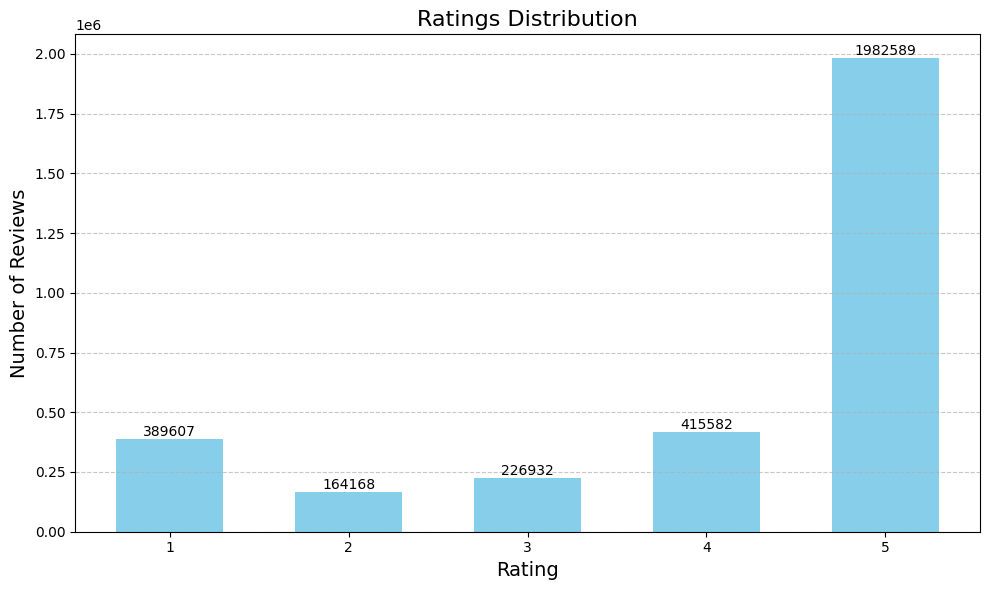

In [27]:
# Calculate the distribution of ratings
ratings_distribution = df_reviews['rating'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(ratings_distribution.index, ratings_distribution.values, color='skyblue', width=0.6)

# Add annotations (number of reviews) on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

# Customize the plot
plt.title('Ratings Distribution', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(ratings_distribution.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

The distribution of ratings reveals that the vast majority of reviews have a rating of **5.0** (1,982,589), significantly higher than the combined total for ratings of **1.0**, **2.0**, **3.0**, and **4.0** (1,196,289). This indicates a strong skew towards positive ratings, especially the **5.0** rating. Such a distribution could introduce bias in any models trained on this data, as the prevalence of highly positive ratings might overshadow other ratings.

Additionally, there is a relatively small number of ratings in the **2.0–3.0** range, suggesting that users tend to gravitate towards more extreme ratings (**1.0** or **5.0**) to express their satisfaction or dissatisfaction. This polarization in user feedback highlights the need for careful consideration when preprocessing and analyzing the data.

These findings should be taken into account in subsequent steps to mitigate potential bias and ensure more balanced model outcomes

We move to exanine the length of users reviews.

In [28]:
# Create a new column for review length
df_reviews['review_length'] = df_reviews['text'].str.len()

# Display the first few rows to verify
df_reviews[['text', 'review_length']].head()



text  review_length
332478   This game made Wii Fit so much better.  Its a ...            373
332479   I have been playing for a long time, but we to...            272
4412427  Yes I love it!!!!! Dramatically improved my ga...            636
3888692                                        Works great             11
4140148  I really enjoyed the original Left 4 Dead.  Th...            353

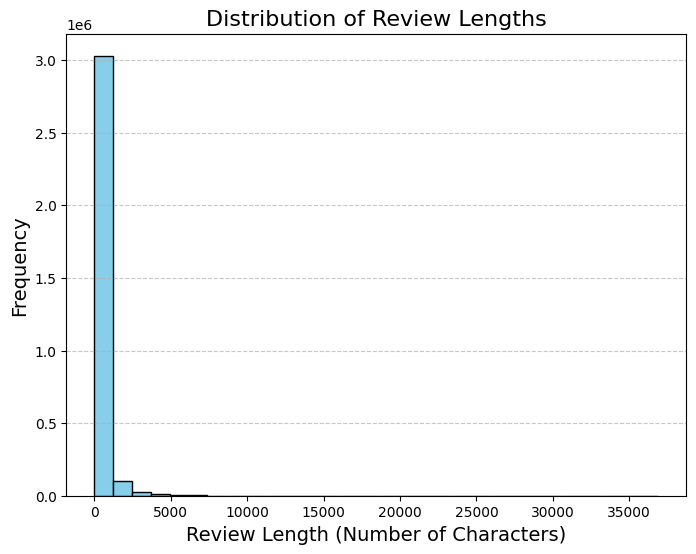

In [29]:

# Plot the histogram of review lengths
plt.figure(figsize=(8, 6))
plt.hist(df_reviews['review_length'], bins=30, edgecolor='black', color='skyblue')
plt.title('Distribution of Review Lengths', fontsize=16)
plt.xlabel('Review Length (Number of Characters)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




Clearly there are a very small number of reviews that are outliners in the data with above 5000 charachters.

We'll decide to find the limit that 95% of the reviews are shorther then and see the updated distributaion.

In [30]:
# Calculate the 95th percentile of review lengths
length_95th_percentile = df_reviews['review_length'].quantile(0.95)
print(f"95% of reviews are shorter than {length_95th_percentile} characters.")

95% of reviews are shorter than 1172.0 characters.


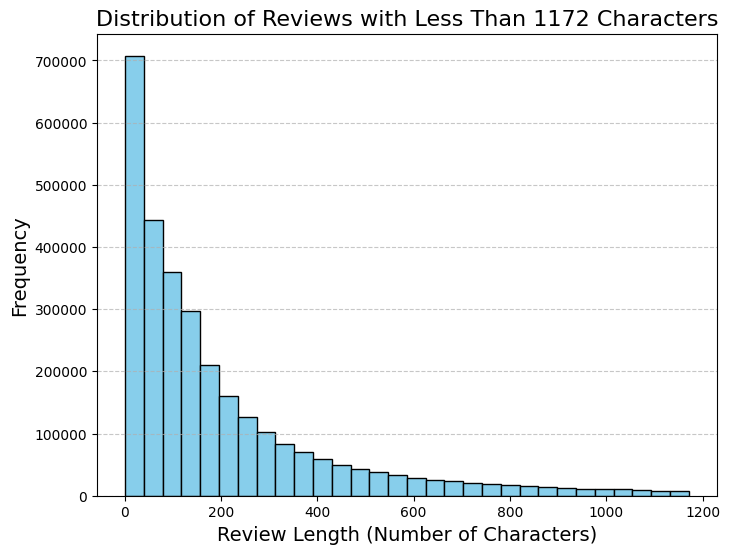

In [31]:

# Filter reviews with less than 1172 characters
filtered_reviews = df_reviews[df_reviews['review_length'] < 1172]

# Plot histogram of the filtered review lengths
plt.figure(figsize=(8, 6))
plt.hist(filtered_reviews['review_length'], bins=30, edgecolor='black', color='skyblue')
plt.title('Distribution of Reviews with Less Than 1172 Characters', fontsize=16)
plt.xlabel('Review Length (Number of Characters)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


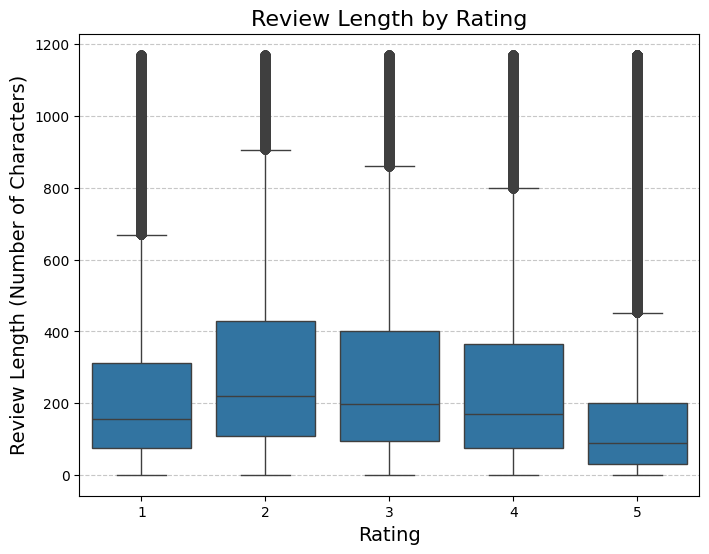

In [32]:

# Boxplot to analyze review length vs. rating
plt.figure(figsize=(8, 6))
sns.boxplot(x='rating', y=filtered_reviews['review_length'], data=filtered_reviews)
plt.title('Review Length by Rating', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Review Length (Number of Characters)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


From these results, we observe that reviews with ratings of **1** or **5** tend to be shorter compared to those with ratings of **2**, **3**, or **4**. This suggests that users are more descriptive when they have mixed feelings about a game, as they are likely elaborating on both positive and negative aspects.

Unsurprisingly, shorter reviews are more common than longer ones, a trend that is consistent across all ratings, as shown in the graph.

The insights gained from reviews with ratings of **2**, **3**, and **4** could be particularly useful for companies aiming to improve their products. These reviews are often more balanced and informative, providing valuable feedback from customers that highlights both strengths and areas for improvement.

We will now explore the relationship between the number of reviews submitted over time. This analysis can provide valuable insights into how different time periods influence review trends

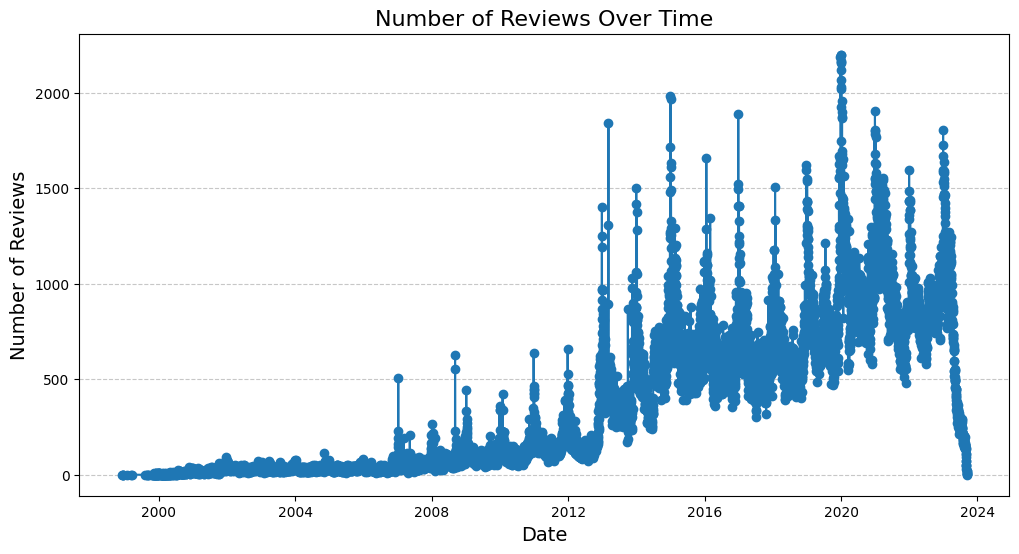

In [33]:

# Group by date and count the number of reviews per day
reviews_per_day = df_reviews.groupby(df_reviews['timestamp'].dt.date).size()

# Plot the time series of reviews per day
plt.figure(figsize=(12, 6))
reviews_per_day.plot(kind='line', marker='o', linestyle='-')
plt.title('Number of Reviews Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


It is clear that the majority of reviews have been submitted betweenn 2012 and 2022, lets look more spesificly on this time period and divide it by quarters to have more significant insights.

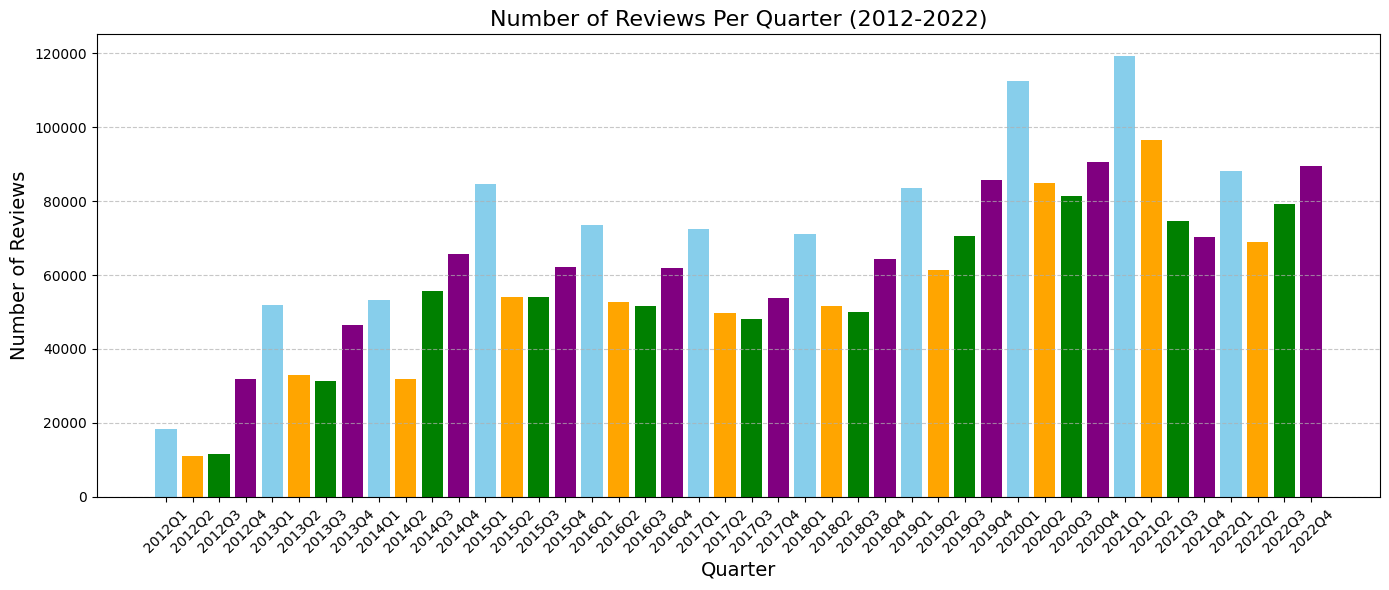

In [34]:
# Filter the dataset for reviews between 2012 and 2022
filtered_reviews = df_reviews[(df_reviews['timestamp'] >= '2012-01-01') & (df_reviews['timestamp'] <= '2022-12-31')]


# Group by quarter and count the number of reviews
reviews_per_quarter = filtered_reviews.groupby(filtered_reviews['timestamp'].dt.to_period('Q')).size()

# Create a bar chart with different colors for each quarter
quarters = reviews_per_quarter.index.astype(str)
values = reviews_per_quarter.values

# Define colors for the four quarters
colors = ['skyblue', 'orange', 'green', 'purple']
quarter_colors = [colors[int(q[-1])-1] for q in quarters]  # Assign color based on the quarter (Q1, Q2, etc.)

# Plot
plt.figure(figsize=(14, 6))
plt.bar(quarters, values, color=quarter_colors, width=0.8)
plt.title('Number of Reviews Per Quarter (2012-2022)', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



From this analysis, we can draw several insights:

1.  **Steady Growth**: The number of reviews increased steadily from 2012 to 2020, indicating significant growth in the platform's user base or the overall market during this period.

2.  **High Activity in Q1**: Q1 consistently shows the highest review activity across most years. This is likely due to its proximity to the holiday season and the impact of post-holiday sales, which drive increased user engagement.

3.  **Consistent Quarterly Patterns**: The relative distribution of reviews across quarters remains consistent, with Q1 and Q4 typically outperforming Q2 and Q3. These predictable, recurring trends can be valuable for companies planning game releases or marketing strategies to align with peak activity periods.

While these insights may not directly enhance our understanding of the data for building a recommendation system, they offer significant value from a business perspective. Companies can use this information to strategically schedule release dates and promotional events to maximize user engagement and the number of reviews.

Later, using the metadata, we will explore a more intriguing aspect: whether the timing of reviews has an impact on the ratings.

Next we will explore the relationship between the reviews ratings and how many helpful votes it got.



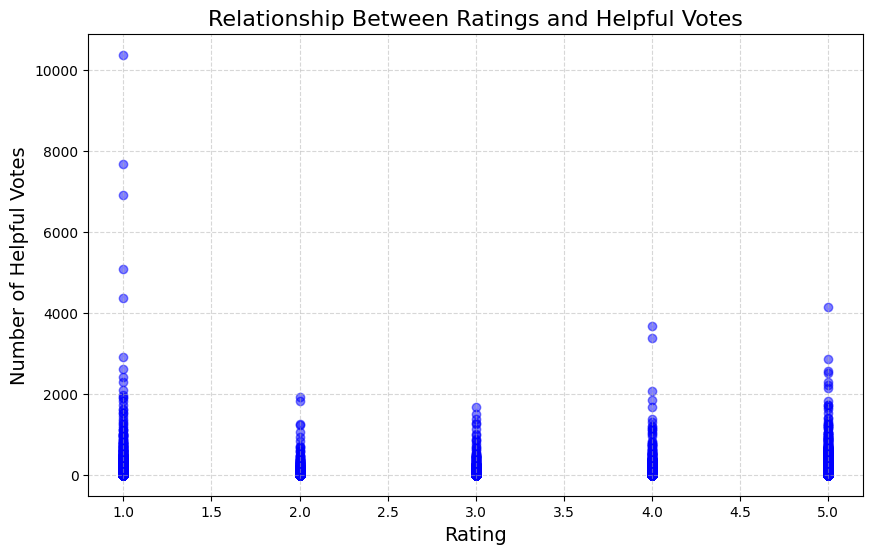

In [35]:

# Scatter plot of ratings vs. helpful votes
plt.figure(figsize=(10, 6))
plt.scatter(df_reviews['rating'], df_reviews['helpful_vote'], alpha=0.5, color='blue')
plt.title('Relationship Between Ratings and Helpful Votes', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Number of Helpful Votes', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


We see that some reviews, particularly for ratings of 1 and 5, have an extremely high number of helpful votes (e.g., above 4000). These likely represent reviews that resonated strongly with the community, either for being highly critical or highly positive. Most reviews, regardless of rating, tend to have low helpful vote counts (clustered near 0). This suggests that the majority of reviews receive little community feedback in terms of helpfulness.

No clear correlation can be observed between the number of votes and the rating, because of that we will look for a more aggregated analysis in the form of finding the average helpful votes per rating:


rating
1    2.477027
2    1.720195
3    1.600995
4    1.427316
5    0.889505
Name: helpful_vote, dtype: float64


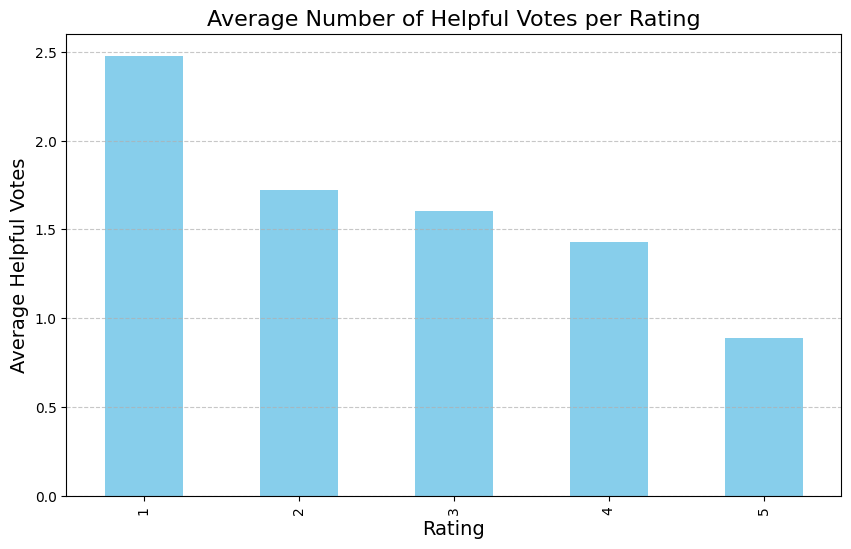

In [36]:
# Calculate average helpful votes per rating
avg_helpful_votes = df_reviews.groupby('rating')['helpful_vote'].mean()

print(avg_helpful_votes)

# Plot average helpful votes per rating
avg_helpful_votes.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Average Number of Helpful Votes per Rating', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Average Helpful Votes', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


From this, we can understand that the most helpful reviews, on average, are those with a rating of **1**, with a clear decreasing trend in helpful votes as ratings increase from **1** to **5**. This suggests that **negative reviews** tend to resonate more with users and garner more attention.

Additionally, the abundance of reviews with a rating of 5 as seen before may not solely reflect product quality or user satisfaction. Instead, it could also result from poorly rated products being purchased and reviewed less frequently, as negative reviews likely deter potential buyers.

This further supports the idea of implementing **weighted reviews**, where lower-rated reviews have greater influence than higher-rated ones. Moreover, incorporating helpful votes into the weighting process could enhance its effectiveness, as these votes indicate reviews that have a stronger impact on user decisions.

Additionally, at a later stage with a smaller, more refined dataset, conducting **sentiment** or **keyword analysis** on highly helpful reviews could prove informative. This approach would help identify recurring themes or specific issues that resonate with users, offering valuable insights for both product improvement and recommendation strategies. Given the size of the current dataset, performing such analysis now would be computationally problematic, making it more practical to focus on a reduced dataset for this purpose.

Now we move on to the meta dataset

### The MetaData Dataset

We will visualize the distribution of game ratings based on the metadata.

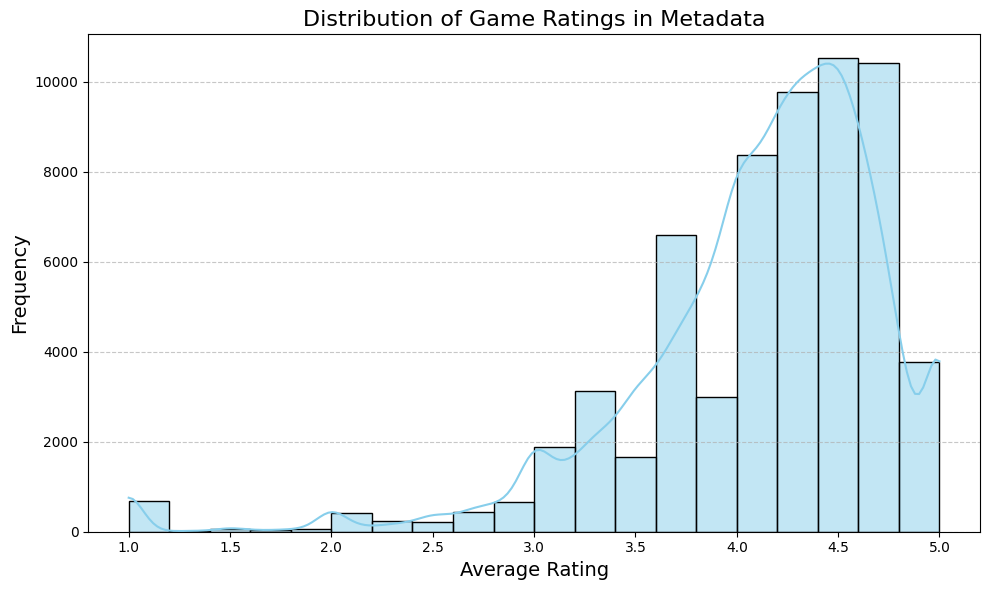

In [37]:
# Extract and plot the distribution of game ratings
plt.figure(figsize=(10, 6))
sns.histplot(df_meta['average_rating'], bins=20, kde=True, color='skyblue')

# Add titles and labels
plt.title('Distribution of Game Ratings in Metadata', fontsize=16)
plt.xlabel('Average Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


As expected from the reviews dataset, the results show a clear skew toward high ratings, with the majority of games rated between **4.0** and **4.75**. In contrast, lower ratings are much less frequent, with **1.0** being the most common among ratings below **3.0**. This suggests that while games are generally perceived positively, those that are poorly received tend to receive the lowest possible score from users.

These findings reinforce the suspicion that the dataset is biased toward higher ratings. This imbalance will need to be addressed in future steps, either by normalizing or balancing the dataset used for modeling or by applying weight adjustments during the modeling process to mitigate the impact of the skewed distribution.


Next we will inspect the column of "price".

In [38]:
print(df_meta['price'].dtype)  # Check the data type of the column


object


In [39]:
non_numeric_prices = df_meta[~df_meta['price'].astype(str).str.isnumeric()]
print(non_numeric_prices['price'])  # Display a sample of non-numeric values


2          58.0
3         37.42
6         33.98
7         17.59
10        20.95
          ...  
137253    19.99
137256     9.99
137257      6.1
137262     3.99
137264    31.04
Name: price, Length: 62007, dtype: object


In [40]:
# Convert 'price' to numeric, coercing errors to NaN
df_meta['price_numeric'] = pd.to_numeric(df_meta['price'], errors='coerce')

# Check the result
print(df_meta[['price', 'price_numeric']].head(10))


     price  price_numeric
2     58.0          58.00
3    37.42          37.42
6    33.98          33.98
7    17.59          17.59
10   20.95          20.95
11    4.97           4.97
12   46.99          46.99
13   13.99          13.99
14  182.93         182.93
15   29.95          29.95


We move now to inspecting the relatioship between games ratings and thire price.

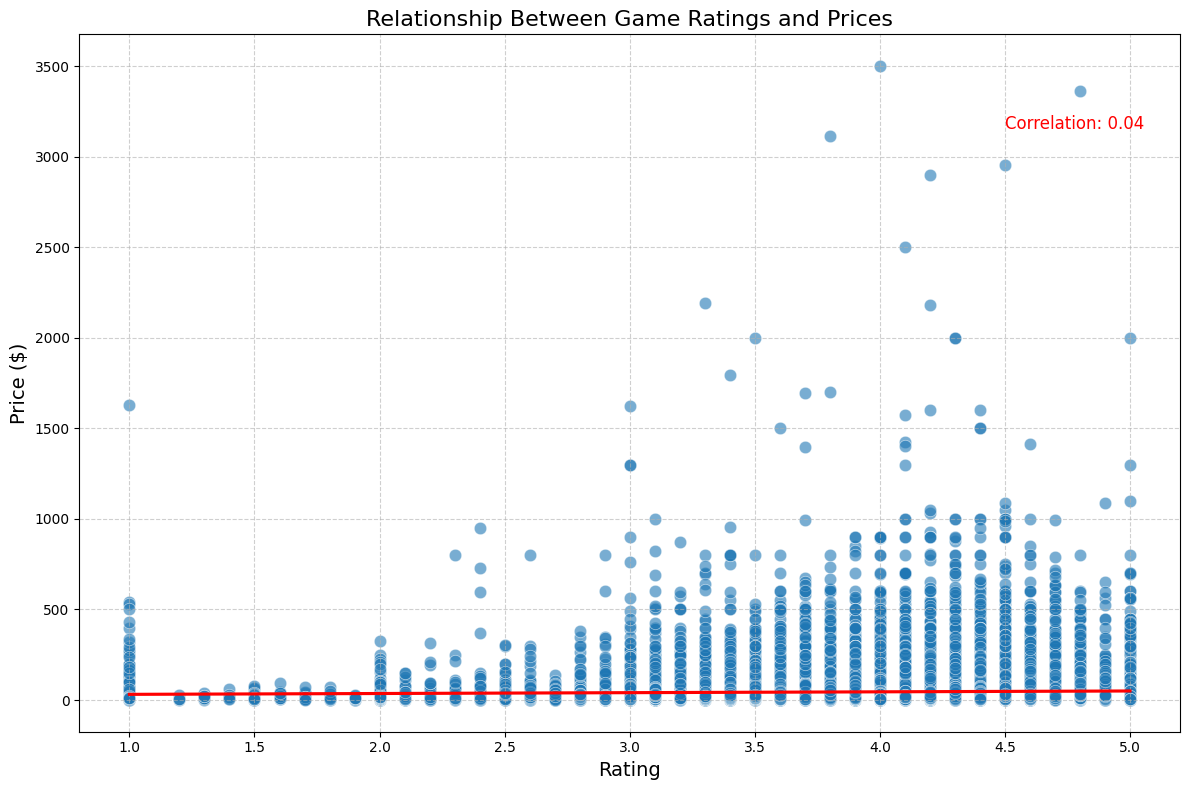

In [41]:
# Ensure ratings and prices are cleaned (drop missing or invalid data)
df_filtered = df_meta[['price_numeric', 'average_rating']].dropna()

# Scatter plot with a regression line
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_filtered, x='average_rating', y='price_numeric', alpha=0.6, s=80, edgecolor='w', linewidth=0.5)
sns.regplot(data=df_filtered, x='average_rating', y='price_numeric', scatter=False, color='red', ci=None)

# Add plot details
plt.title('Relationship Between Game Ratings and Prices', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# Calculate and display correlation coefficient
correlation = np.corrcoef(df_filtered['average_rating'], df_filtered['price_numeric'])[0, 1]
plt.text(4.5, max(df_filtered['price_numeric']) * 0.9, f'Correlation: {correlation:.2f}', fontsize=12, color='red')

plt.tight_layout()
plt.show()

We see the items range from **0** to **3500** USD in price, this range seems a bit too wide, especially considering the wide majority is under **500** USD. Due to this we will look for items over **500** USD more closly and see what we can understand from that.

In [42]:
high_price_items = df_meta[df_meta['price_numeric'] > 500]
high_price_items.head(20)

title  average_rating  \
918    Rock Band 4 Wireless Pro-Drum Kit for PlayStat...             3.4   
1427   PSP-3000 Kingdom Hearts Birth by Sleep Import ...             4.2   
2355                    Drakengard 3 Collector's Edition             4.5   
3152   HTC Vive Focus 3 Enterprise Virtual Reality He...             3.0   
3184   Pimax 5K Plus VR Headset with Wide 200 Degrees...             3.1   
3566   Nintendo New 3DS XL - Pikachu Yellow Edition [...             4.7   
3655                  Nintendo New 3DS XL - Galaxy Style             4.6   
3785   Bass Pro Shops Outdoor Mega Pack Bundle- Ninte...             4.1   
4065   PlayStation VR FPS Classic Bundle (5 Items): P...             5.0   
4143   PlayStation 4 1TB Final Fantasy XV ‑ limited E...             4.4   
5129        SteelSeries Merc Stealth USB Gaming Keyboard             4.5   
5493                             Sonic Jam - Sega Saturn             3.9   
6631   Rock Band 4 Band-In-A-Box Ps4 Software Bundle ...             3.2   
7748   Nintendo New 3DS XL - Pikachu Yellow Edition [...             3.4   
8372              Nintendo 3DS Pearl Pink - Nintendo 3DS             4.1   
8608   PlayStation 4 Pro 1TB Limited Edition The Last...             4.2   
8847   Legends Ultimate Arcade, Full Size Game Machin...             4.1   
9433                   Harvest Moon - Nintendo Super NES             3.6   
10006  Nintendo Wii Console with Just Dance 3 Bundle ...             3.9   
10058                    Haunting Ground - PlayStation 2             4.4   

       rating_number                                           features  \
918               45  [Unlock Pro Mode: These Rock Band 4 drums with...   
1427              23                        [Silver in great condition]   
2355              10  [Premium Packaging, featuring the Japanese Pro...   
3152              24  [Visualize your ideas beforehand in crystal-cl...   
3184             116  [VR RESOLUTION REDEFINED - Dual Custom Low Per...   
3566            1038  [This colorful yellow system sports a charming...   
3655            2034  [The New Nintendo 3DS XL system plays all Nint...   
3785              14  [Last-man-standing tournament structure, Limit...   
4065               3                                      [No Features]   
4143              14                                      [No Features]   
5129             621  [SteelSeries Z Engine enables programmability ...   
5493              19                                      [No Features]   
6631              11                                      [No Features]   
7748               7  [This colorful yellow system sports a charming...   
8372              97                    [Nintendo 3DS Pink New Package]   
8608              26                                      [No Features]   
8847              32  [Full-size multiplayer, connected home arcade ...   
9433              25  [Your chance to run a farm, You decide what to...   
10006             56  [Nintendo Wii, Just Dance 3, Component A/V Cab...   
10058            122  [ESRB Rating: M (Mature), Action/Adventure/Sur...   

                                             description    price  \
918    [Become a drum legend with the official Rock B...    957.4   
1427   [PSP- 300 gaming system with Kingdom Hearts Bi...   533.99   
2355   [A prequel to the original Drakengard, Drakeng...   569.95   
3152   [Prepare for the new era of business VR with t...   1300.0   
3184                                    [No Description]    509.0   
3566   [THE NEXT DIMENSION IN ENTERTAINMENT - This co...   994.98   
3655   [THE NEXT DIMENSION IN ENTERTAINMENT The New N...   1000.0   
3785   [The most realistic hunting experience availab...   699.99   
4065   [PlayStation VR FPS Classic Bundle (5 Items): ...   699.99   
4143   [Limited Deluxe Edition FINAL FANTASY XV PS4 B...  1499.98   
5129   [Product Description, The SteelSeries Merc Ste...   899.99   
5493                                    [very cool

Upon closer examination and further research, it becomes clear—particularly from some of the product names—that the primary driver of price in many cases is that the items are gaming consoles or accessories for gaming computers or consoles, rather than classic video games.

Later on using other features we will drop items that are not games, making the analysis based on price more informative.

Next on our meta data we will visualize the "store" information:

Total number of unique stores: 8776


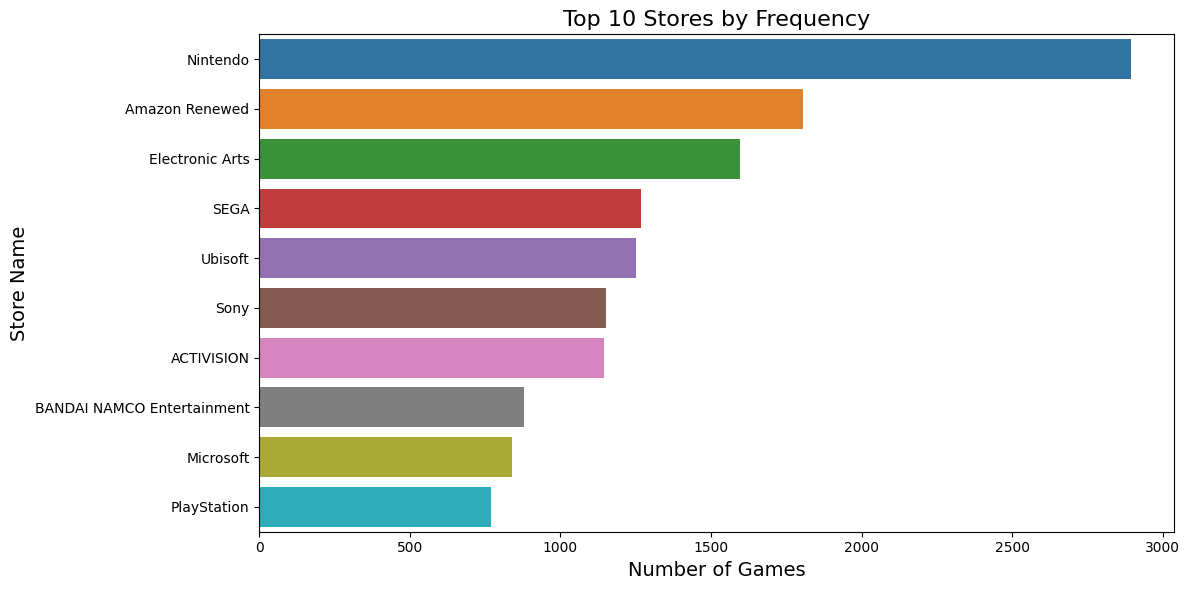

Total number of games in the top 10 stores: 13596


In [43]:
# Count the total number of unique stores
total_stores = df_meta['store'].nunique()
print(f"Total number of unique stores: {total_stores}")

# Identify the top 10 stores by frequency
top_stores = df_meta['store'].value_counts().head(10)

# Visualize the top 10 stores (adjusted to avoid the FutureWarning)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_stores.values, y=top_stores.index, hue=top_stores.index, dodge=False, legend=False)

# Add labels and title
plt.title('Top 10 Stores by Frequency', fontsize=16)
plt.xlabel('Number of Games', fontsize=14)
plt.ylabel('Store Name', fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()


# Print the total number of games in the top 10 stores
total_games_top_10 = top_stores.values.sum()
print(f"Total number of games in the top 10 stores: {total_games_top_10}")


The most common store in the dataset is the "Nintendo" store with almost double the amount of games as the second one. This can imply the high precence of Nintendo in the gaming market.

Additionally, the presence of well-known gaming companies in the top 10 stores provides valuable insights into which companies dominate the gaming industry and release the most titles.

Next we will see the relationship between the stores and their avarage game ratings in order to Identify stores associated with higher or lower user satisfaction. We will limit it to stores with above 50 games at least beacuse of the amount of stores needed to be taken into account and reducing bias due to small number of values to check on.


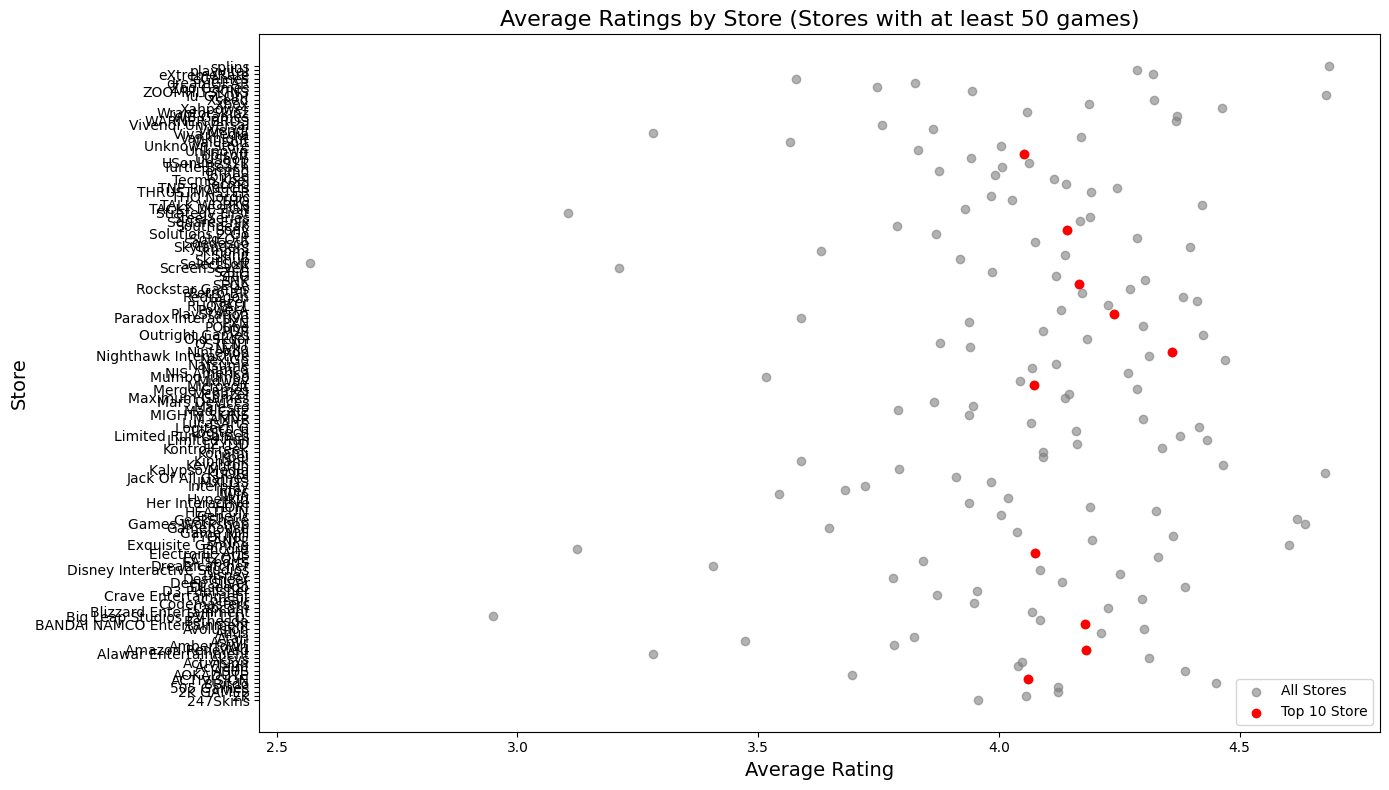

In [44]:
import matplotlib.pyplot as plt

# Step 1: Filter stores with at least 50 games
store_counts = df_meta['store'].value_counts()
stores_with_min_games = store_counts[store_counts >= 50].index
filtered_df = df_meta[df_meta['store'].isin(stores_with_min_games)]

# Step 2: Calculate the average rating for each store
avg_ratings_by_store = filtered_df.groupby('store')['average_rating'].mean()

# Step 3: Mark the top 10 stores from the previous analysis
top_10_stores = ['Nintendo', 'Amazon Renewed', 'Electronic Arts', 'SEGA',
                 'Ubisoft', 'Sony', 'ACTIVISION', 'BANDAI NAMCO Entertainment',
                 'Microsoft', 'PlayStation']

# Step 4: Create the dot chart
plt.figure(figsize=(14, 8))
all_stores = avg_ratings_by_store.index
plt.scatter(avg_ratings_by_store.values, all_stores, label='All Stores', alpha=0.6, color='gray')

# Highlight top 10 stores
for store in top_10_stores:
    if store in avg_ratings_by_store.index:
        plt.scatter(avg_ratings_by_store[store], store, color='red', label='Top 10 Store' if store == top_10_stores[0] else "")

# Add labels and title
plt.title('Average Ratings by Store (Stores with at least 50 games)', fontsize=16)
plt.xlabel('Average Rating', fontsize=14)
plt.ylabel('Store', fontsize=14)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


From this chart, we observe that all the top 10 stores have an average rating above **4.0**, suggesting that they not only offer a wide variety of games but also tend to sell games that are generally well-received by users.

Additionally, the majority of stores with at least 50 games maintain an average rating above **4.0**. This implies that stores with a relatively high number of games tend to achieve decent user satisfaction levels.

However, there are some outliers, with a few stores having an average rating below **3.25**. It may be beneficial to investigate these stores further to understand why their games are less well-received, as this could reveal issues such as poor game quality, mismatched user expectations, or other factors impacting user satisfaction.



Next, we will explore the relationship between the number of reviews and the average ratings for games over time.

To illustrate these trends, we will select a specific game as an example and analyze its data to gain insights into the potential connection between ratings and subsequent review volumes. Afterward, we will generalize this analysis across all products to uncover broader, global patterns.

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Keep only the desired columns in df_reviews
df_reviews_filtterd = df_reviews.filter(items=['parent_asin', 'rating', 'timestamp'])
df_meta_filtterd = df_meta.filter(items=['parent_asin', 'rating_number'])

df_merge = pd.merge(df_reviews_filtterd, df_meta_filtterd, on='parent_asin')

df_merge.head()

parent_asin  rating               timestamp  rating_number
0  B002BS47JE       5 2010-05-30 19:22:49.000           3061
1  B00400OFG6       4 2009-10-24 14:09:15.000            532
2  B0BH1ZL3G9       5 2014-09-04 05:34:30.000           4828
3  B01MQ0BGOL       5 2020-02-18 11:39:39.005           2002
4  B002BSH82M       5 2011-04-26 20:19:07.000            311

In [46]:


# Extract month and year for grouping
df_merge['month'] = df_merge['timestamp'].dt.to_period('M')


In [47]:
# Aggregate data by product and month
agg_data = df_merge.groupby(['parent_asin', 'month']).agg(
    num_reviews=('rating', 'count'),
    avg_rating=('rating', 'mean'),
    total_rating_number=('rating_number', 'first')  # Assume constant over time
).reset_index()


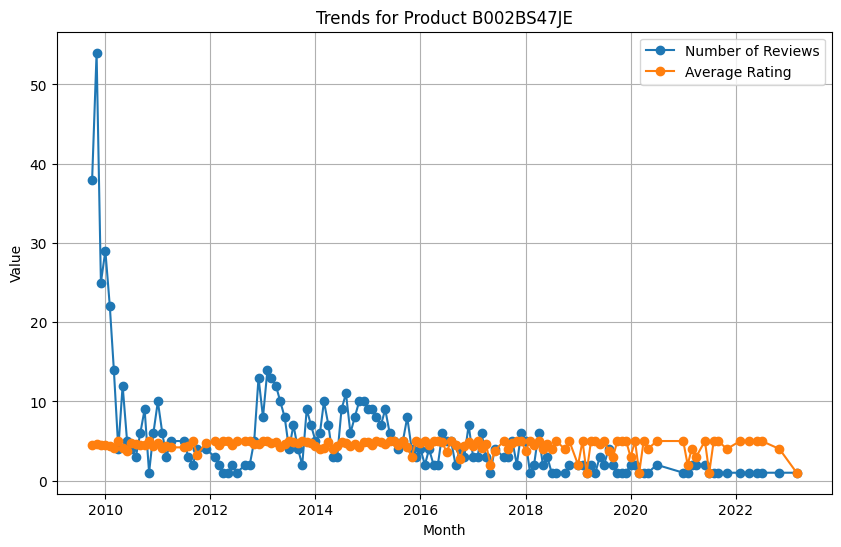

In [48]:
import matplotlib.pyplot as plt

# Plot trends for a specific product
asin = 'B002BS47JE'
product_data = agg_data[agg_data['parent_asin'] == asin]

plt.figure(figsize=(10, 6))
plt.plot(product_data['month'].dt.to_timestamp(), product_data['num_reviews'], label='Number of Reviews', marker='o')
plt.plot(product_data['month'].dt.to_timestamp(), product_data['avg_rating'], label='Average Rating', marker='o')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title(f'Trends for Product {asin}')
plt.legend()
plt.grid()
plt.show()


In [49]:
# Add lagged average rating
agg_data['lagged_avg_rating'] = agg_data.groupby('parent_asin')['avg_rating'].shift(1)

# Calculate correlation for a specific product
lagged_corr = agg_data[agg_data['parent_asin'] == asin][['num_reviews', 'lagged_avg_rating']].corr()
print(f"Lagged correlation for product {asin}:\n", lagged_corr)

# Group by product and calculate correlations
def compute_lagged_correlation(group):
    group['lagged_avg_rating'] = group['avg_rating'].shift(1)
    return group[['num_reviews', 'lagged_avg_rating']].corr().iloc[0, 1]  # Correlation value


correlation_results = agg_data.groupby('parent_asin', group_keys=False).apply(compute_lagged_correlation)
print("Overall lagged correlation across products:\n", correlation_results)


Lagged correlation for product B002BS47JE:
                    num_reviews  lagged_avg_rating
num_reviews           1.000000           0.104825
lagged_avg_rating     0.104825           1.000000
Overall lagged correlation across products:
 parent_asin
0008288194         NaN
0028179714         NaN
0060501960    0.045237
0063052164         NaN
0072826843   -0.220564
                ...   
B0CKMRL44N         NaN
B0CKNRZFMT         NaN
B0CKPC5CD1         NaN
B0CKQNJB3T         NaN
B0CKR257MD         NaN
Length: 61999, dtype: float64


<ipython-input-49-e43f73fabb64>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_results = agg_data.groupby('parent_asin', group_keys=False).apply(compute_lagged_correlation)


The results indicate that the lagged correlation (0.104825) between num_reviews and lagged_avg_rating is weakly positive. This suggests that higher ratings in a previous time period are marginally associated with an increase in the number of reviews in subsequent periods. While this relationship is not strong, it may point to a minor feedback loop where positive ratings encourage further engagement.

For the overall lagged correlations across all products, we observe variability:

*  The product with parent_asin **"0060501960"** shows a slightly positive correlation, indicating a weak positive relationship between previous ratings and future review volume. This could suggest that for some products, higher ratings slightly drive engagement.
*  Conversely, the product with parent_asin **"0072826843"** exhibits a slightly negative correlation, indicating a weak negative relationship. This suggests that for this product, higher ratings in one period may slightly decrease review engagement in subsequent periods.


A key observation is that many products have NaN correlations, indicating insufficient data to calculate lagged correlations (e.g., fewer than two time periods with reviews). This limits the ability to draw robust conclusions from the current dataset.

Given these limitations, the insights from this analysis are preliminary. To improve the reliability of the findings, future work should:

1.  **Filter Products with Insufficient Data**: Remove products with NaN correlations to ensure valid results.

2.  **Incorporate Additional Factors**: Perform sentiment analysis on the review text to explore the influence of customer sentiment on review volume and engagement.

These additional steps could help uncover stronger patterns and provide more actionable insights into the relationship between reviews and engagement.

Next we explore "catagories".

In [50]:

# Flatten the categories column to extract all unique categories
all_categories = [category for sublist in df_meta['categories'] for category in sublist]

# Count the frequency of each category
from collections import Counter
category_counts = Counter(all_categories)

# Total number of unique categories
total_unique_categories = len(category_counts)
print(f"Total number of unique categories: {total_unique_categories}")

Total number of unique categories: 166


In [51]:
# most common categories to least sorted presentation
most_common_categories = category_counts.most_common(166)
print("\nCategories sorted from most common to least:")
for category, count in most_common_categories:
    print(f"{category}: {count}")


Categories sorted from most common to least:
Video Games: 59090
Games: 28511
Legacy Systems: 27348
Accessories: 23286
PC: 14719
Nintendo Systems: 12276
PlayStation Systems: 8466
Nintendo Switch: 5727
PlayStation 4: 5275
Xbox Systems: 4374
Controllers: 3774
Xbox One: 3214
Missing Category: 2904
Faceplates, Protectors & Skins: 2719
Xbox 360: 2564
Wii: 2454
Headsets: 2450
PlayStation 2: 2316
PlayStation 3: 2282
Nintendo DS: 2271
Game Boy Systems: 1961
PlayStation: 1878
Cases & Storage: 1837
Nintendo 3DS & 2DS: 1806
Gaming Keyboards: 1787
Xbox: 1776
Gaming Mice: 1412
Virtual Reality: 1386
Sega Systems: 1337
Consoles: 1295
Accessory Kits: 1282
Gamepads & Standard Controllers: 1276
Game Boy Advance: 1187
Sony PSP: 1158
PlayStation 5: 1133
Cables & Adapters: 1110
Nintendo NES: 885
Batteries & Chargers: 883
GameCube: 751
Nintendo 64: 718
Super Nintendo: 678
Skins: 678
Sega Genesis: 628
PlayStation Vita: 615
Wii U: 572
Game Boy Color: 498
Cables: 485
Joysticks: 449
Xbox Series X & S: 425
Adapt

From these results we understand that we have 166 catagories for the items in total and we can see some similarity in them, because if that we will decide to group by items from related catagories in order to have a better generalization.

We will decide on 30 main catagories to group by and that being:

In [52]:
# Define the groups based on the suggested categories
category_groups = {
    "Core Video Games": ["Video Games", "Games", "Games - Retro Gaming & Classics", "Game Genre of the Month", "Best Simulation/Strategy",
                         "Video Games Clearance", "Bestselling in Renewed Video Games"],
    "Accessories": ["Accessories", "Headsets", "Accessory Kits", "Video Games Accessories" ,
                    "Gaming Headsets", "Cases", "Screen Protectors", "Cooling Systems"
                    "Fitness Accessories", "Sensor Bars", "Eligible Accessories for Digital Game Attach Promotion", "Skins",
                    "Remotes", "Protectors"],
    "Consoles": ["Consoles", "Handheld Game Systems", "NEOGEO Pocket", "Microconsoles", "GEM Box", "NVIDIA SHIELD"],
    "Nintendo Systems": ["Nintendo Systems", "Nintendo Switch", "Wii", "Nintendo DS", "Game Boy Systems", "Nintendo 3DS & 2DS",
                         "Nintendo NES", "Super Nintendo", "Nintendo 64", "Wii U" ],
    "PlayStation Systems": ["PlayStation Systems", "PlayStation 4", "PlayStation 2", "PlayStation 3", "PlayStation", "PlayStation 5",
                            "Sony PSP", "PlayStation Vita", "AMG PS Vita Test Node"],
    "Xbox Systems": ["Xbox Systems", "Xbox One", "Xbox 360", "Xbox", "Xbox Series X & S", "Video Games - Xbox 360 Kinect", "Xbox 360 Kinect Games"],
    "Legacy Systems": ["Legacy Systems", "Commodore Systems", "TurboGrafx 16", "Intellivision",
                       "3DO", "Ouya", "GameCube"],
    "PC Gaming": ["PC", "Video & PC Games", "Linux Games", "Mac", "PC Games"],
    "Sega Systems": ["Sega Systems", "Sega Genesis", "Sega Dreamcast", "Sega CD", "Sega Saturn", "Sega Master System", "Sega Game Gear"],
    "Atari Systems": ["Atari Systems", "Atari 2600", "Atari 5200", "Atari 7800", "Atari Jaguar", "Atari Lynx"],
    "Game Boy Systems": ["Game Boy Systems", 'Game Boy', 'Game Boy Color', "Game Boy Advance"],
    "Digital Content": ["Digital Games - International", "Downloadable Content", "Xbox Digital Content", "PlayStation Digital Content",
                        "Subscriptions", "Subscription Cards", "Store Currency Cards", "Points & Currency Cards", "Digital for the Holidays",
                        "Online Game Services", "Xbox Live", "PlayStation Network", "Nintendo eShop", "Store Currency & Points Cards",
                        "Digital Video Games"],
    "VR (Virtual Reality)": ["Virtual Reality", "PlayStation VR Hardware"],
    "Controllers & Input Devices": ["Controllers", "Gaming Mice", "Gaming Keyboards",  "Gamepads & Standard Controllers", "Keyboards",
                                    "Motion Controllers", "Joysticks", "Racing Wheels", "Flight Controls"],
    "Gaming Kits": ["Repair Tools & Replacement Parts", "Stylus Pens", "Hand Grips", "Thumb Grips"],
    "Power and Batteries": [ "Batteries & Chargers", "Battery & Charger Sets"],
    "Storage": ["Cases & Storage" ,"Memory" , "Storage"],
    "Retro Gaming": ["Commodore Systems", "Commodore Amiga", "Commodore 64"],
    "Game Genres": ["Command & Conquer", "Command & Conquer Merchandise", "The Sims", "The Sims Games", "Halo", "Ubisoft", "EA Games" ],
    "Gaming Figures and Collectibles": ["Interactive Gaming Figures"],
    "Kids and Family": ["Kids and Family"],
    "Faceplates and Skins": ["Faceplates, Protectors & Skins", "Skin & Protector Sets", "Faceplates"],
    "Game Music and Controllers": ["Music Controllers", "Drums", "Guitars", "Dance Pads"],
    "Standalone Hardware": ["Standalone Hardware"],
    "Cables and Adapters": ["Cables & Adapters", "Cables", "Adapters", "Chargers", "Batteries"],
    "Mounts and Stands": ["Mounts, Brackets & Stands"],
    "Game Awards and Guides": ["The Game Awards", "Gift Ideas", "Gift Guide - Action & Adventure", "Gift Guide - Sports Fanatic" ],
    "Promotions": ["Value Games Under $10", "Value Games Under $20", "Value Games Under $30",
                   "Spend $19.99 or above at checkout on select qualifying video games and receive the Apex Legends Starter Pack for free.",
                   "Special Deals", "Prime Member Pre-Orders in Video Games", "Deals on Nominations 12/18/2022-12/23/2022",
                   "The Best Holiday Deals in Video Games", "Save up to 30% on PowerA headsets", "2023 Most Anticipated"],
    "Geographical Categories": ["Michigan", "United States", "Geography", "Carleton"],
    "Miscellaneous": ["Disney Interactive Studios","Cameras", "Cameras & Webcams" ,"Kindle and Books", "Purchase Circles"],
    "Unkown": ["Missing Category"]
}

# Create a new column to assign the group based on the rules
def assign_group(categories):
    if categories and categories[0] == "Video Games" and len(categories) > 1:
      if categories and categories[1] == "Legacy Systems" and len(categories) > 2:
        category = categories[2]
      else:
        category = categories[1]
    else:
        category = categories[0] if categories else 'Miscellaneous'
    return next((group for group, items in category_groups.items() if category in items), 'Miscellaneous')

df_meta['Category_Group'] = df_meta['categories'].apply(assign_group)

# Display the updated DataFrame
df_meta.head()


title  average_rating  \
2    NBA 2K17 - Early Tip Off Edition - PlayStation 4             4.3   
3   Nintendo Selects: The Legend of Zelda Ocarina ...             4.9   
6                       Spongebob Squarepants, Vol. 1             4.4   
7   eXtremeRate Soft Touch Top Shell Front Housing...             4.5   
10  Tales of Vesperia - Definitive Edition - PlayS...             4.8   

    rating_number                                           features  \
2             223  [The #1 rated NBA video game simulation series...   
3              22  [Authentic Nintendo Selects: The Legend of Zel...   
6              32  [Bubblestand: SpongeBob shows Patrick and Squi...   
7            3061  [Compatibility Models: Ultra fits for Xbox One...   
10           1389  [A BELOVED TALE RETURNS! — The tale of a young...   

                                          description  price  \
2   [Following the record-breaking launch of NBA 2...   58.0   
3                                    [No Description]  37.42   
6   [Now you can watch the wild underwater antics ...  33.98   
7                                    [No Description]  17.59   
10  [A power struggle begins in a Civilization dep...  20.95   

                         store  \
2                           2K   
3               Amazon Renewed   
6                      Majesco   
7                  eXtremeRate   
10  BANDAI NAMCO Entertainment   

                                           categories  \
2                 [Video Games, PlayStation 4, Games]   
3   [Video Games, Legacy Systems, Nintendo Systems...   
6   [Video Games, Legacy Systems, Nintendo Systems...   
7   [Video Games, Xbox One, Accessories, Faceplate...   
10                [Video Games, PlayStation 4, Games]   

                                              details parent_asin  \
2   {'Release date': 'September 16, 2016', 'Best S...  B00Z9TLVK0   
3   {'Best Sellers Rank': {'Video Games': 51019, '...  B07SZJZV88   
6   {'Release date': 'August 15, 2004', 'Best Sell...  B0001ZNU56   
7   {'Best Sellers Rank': {'Video Games': 48130, '...  B07H93H878   
10  {'Release date': 'January 11, 2019', 'Best Sel...  B07DL353F8   

    price_numeric       Category_Group  
2           58.00  PlayStation Systems  
3           37.42     Nintendo Systems  
6           33.98     Nintendo Systems  
7           17.59         Xbox Systems  
10          20.95  PlayStation Systems

Category_Group
Nintendo Systems          18003
PC Gaming                 15147
PlayStation Systems       14875
Xbox Systems               8015
Unkown                     2904
Sega Systems               1337
Legacy Systems              392
Consoles                    328
Core Video Games            261
Atari Systems               167
Promotions                  163
VR (Virtual Reality)        129
Miscellaneous                83
Accessories                  68
Game Genres                  61
Digital Content              53
Kids and Family              11
Game Awards and Guides       10
Name: count, dtype: int64


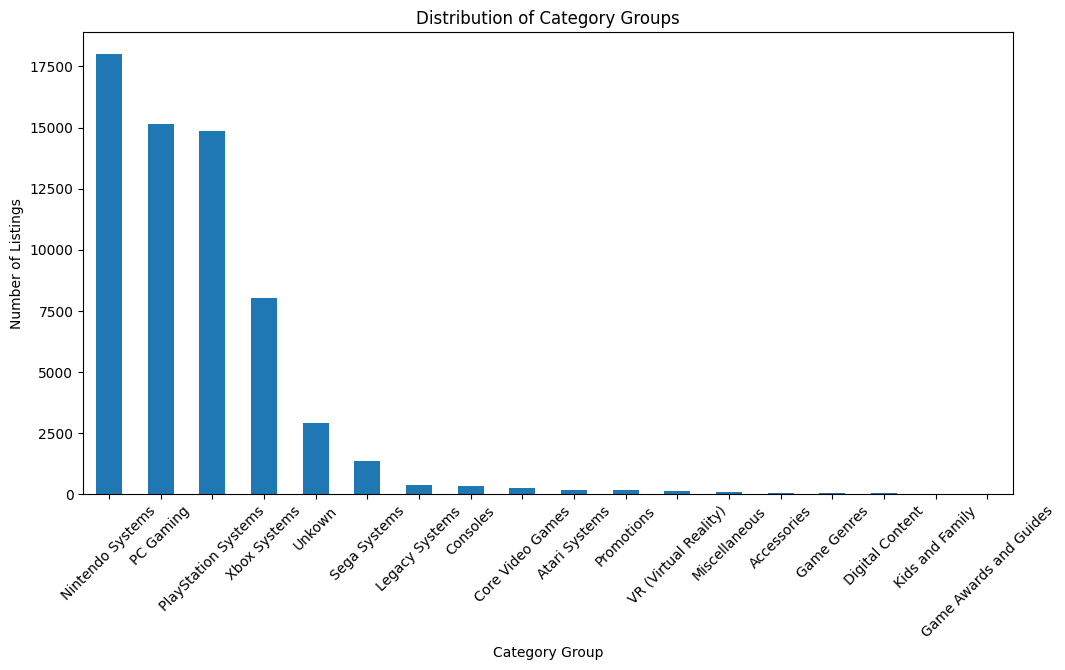

In [53]:
# View the distribution of the 'Category_Group' column
distribution = df_meta['Category_Group'].value_counts()

# Display the distribution
print(distribution)

plt.figure(figsize=(12, 6))
distribution.plot(kind='bar')
plt.title('Distribution of Category Groups')
plt.xlabel('Category Group')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.show()


We ultimately narrowed the dataset down to 18 category groups, with the primary factor distinguishing each group being related to a gaming systems (e.g., PC, Xbox, PlayStation, etc.). This structure aligns logically with both the data and the objectives of this project. Out of the 62,008 items, only 1167 (approximately 1.9%) are unrelated to any gaming platform. Given their negligible proportion and lack of relevance to our analysis, we have decided to exclude these items and proceed without them.

In addition, the 'Unknown' classification applies to about 4.5% of our items. Due to the relatively low number and the lack of information gain from this category, we have decided to drop these items as well.

In [54]:
# Define the groups to remove
groups_to_remove = [
    "Consoles", "Core Video Games", "Promotions",
    "VR (Virtual Reality)", "Miscellaneous", "Accessories",
    "Game Genres", "Digital Content", "Kids and Family", "Game Awards and Guides",
    "Unkown"
]

items_to_remove = df_meta[df_meta['Category_Group'].isin(groups_to_remove)]['parent_asin']

print(f"Original meta count: {len(df_meta)}")
df_meta = df_meta[~df_meta['parent_asin'].isin(items_to_remove)]
print(f"Updated meta count: {len(df_meta)}")

print(f"Original reviews count: {len(df_reviews)}")
df_reviews = df_reviews[~df_reviews['parent_asin'].isin(items_to_remove)]
print(f"Updated reviews count: {len(df_reviews)}")

Original meta count: 62007
Updated meta count: 57936
Original reviews count: 3178878
Updated reviews count: 3020989


Category_Group
Nintendo Systems       18003
PC Gaming              15147
PlayStation Systems    14875
Xbox Systems            8015
Sega Systems            1337
Legacy Systems           392
Atari Systems            167
Name: count, dtype: int64


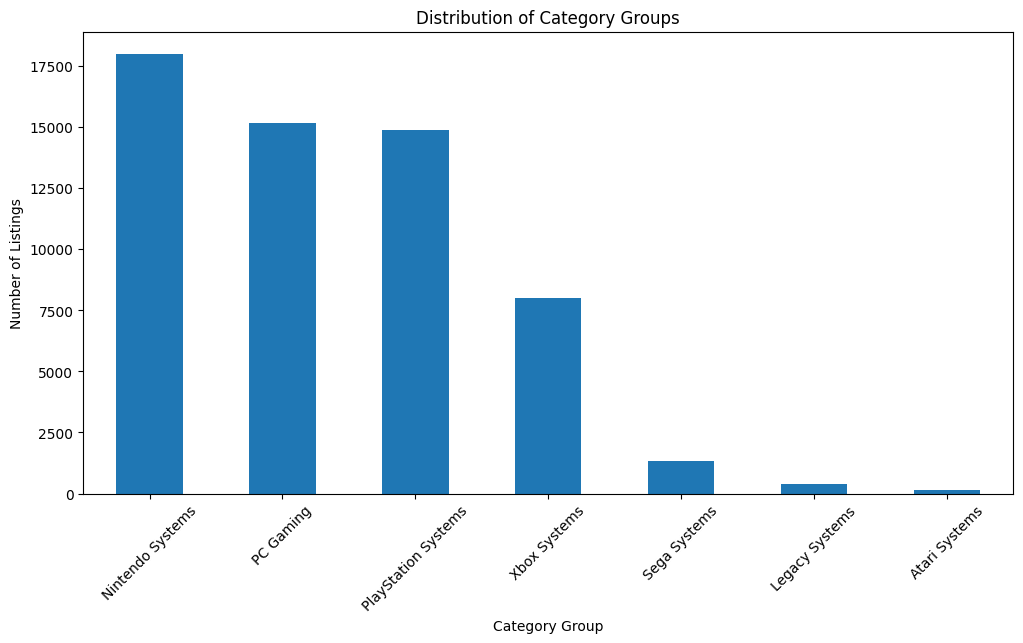

In [55]:
# View the distribution of the 'Category_Group' column
distribution = df_meta['Category_Group'].value_counts()

# Display the distribution
print(distribution)

plt.figure(figsize=(12, 6))
distribution.plot(kind='bar')
plt.title('Distribution of Category Groups')
plt.xlabel('Category Group')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.show()


Ultimately, due to the distribution inside of the game category lists, we consolidated our initial 166 categories into just 7. These simplified categories will serve us for our recommendation system in later stages.

In addition, the categories provide a key insight for achieving our goal: filtering out non-game items. Upon closer examination, we discovered a crucial pattern: **items classified as games consistently have the word "Games" as the last entry in their category list**. This characteristic distinguishes games from non-game items, allowing us to use it as a reliable filter. Leveraging this insight, we will refine our dataset to include only items classified as games.

In [56]:
def assign_games(categories):
  if not categories or len(categories) == 0:
        return None  # Handle empty or None lists
  return categories[-1]

df_meta['games_Group'] = df_meta['categories'].apply(assign_games)

df_meta = df_meta[df_meta['games_Group'] == 'Games']

df_meta.info()



<class 'pandas.core.frame.DataFrame'>
Index: 28488 entries, 2 to 137264
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           28488 non-null  object 
 1   average_rating  28488 non-null  float64
 2   rating_number   28488 non-null  int64  
 3   features        28488 non-null  object 
 4   description     28488 non-null  object 
 5   price           28488 non-null  object 
 6   store           28488 non-null  object 
 7   categories      28488 non-null  object 
 8   details         28488 non-null  object 
 9   parent_asin     28488 non-null  object 
 10  price_numeric   28474 non-null  float64
 11  Category_Group  28488 non-null  object 
 12  games_Group     28488 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 3.0+ MB


In [57]:
games_parent_asin_list = df_meta['parent_asin'].tolist()
df_reviews = df_reviews[df_reviews['parent_asin'].isin(games_parent_asin_list)]
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1189998 entries, 332478 to 2243065
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   rating             1189998 non-null  int64         
 1   title              1189998 non-null  object        
 2   text               1189998 non-null  object        
 3   asin               1189998 non-null  object        
 4   parent_asin        1189998 non-null  object        
 5   user_id            1189998 non-null  object        
 6   timestamp          1189998 non-null  datetime64[ns]
 7   helpful_vote       1189998 non-null  int64         
 8   verified_purchase  1189998 non-null  bool          
 9   review_length      1189998 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(3), object(5)
memory usage: 91.9+ MB


Next we will explore the "details" column.

In [58]:
# Flatten the all_details column to extract all unique all_details
all_details = [detail for sublist in df_meta['details'] for detail in sublist]

# Count the frequency of each all_detail
from collections import Counter
details_counts = Counter(all_details)

# Total number of unique details
total_unique_details = len(details_counts)
print(f"Total number of unique details: {total_unique_details}")

# most common details to least sorted presentation
most_common_details = details_counts.most_common(50)
print("\ndetails sorted from most common to least:")
for detail, count in most_common_details:
    print(f"{detail}: {count}")

Total number of unique details: 339

details sorted from most common to least:
Date First Available: 26381
Manufacturer: 26138
Pricing: 25037
Type of item: 24504
Best Sellers Rank: 23504
Item Weight: 23345
Rated: 21117
Is Discontinued By Manufacturer: 19588
Product Dimensions: 17120
Item model number: 15869
Release date: 15741
Package Dimensions: 6609
Language: 3486
Countries: 3075
Terms of Use: 3075
Return Policy: 3074
Brand: 992
Country of Origin: 784
Manufacturer recommended age: 680
Color: 372
Genre: 367
Hardware Platform: 358
Batteries: 353
Theme: 322
Material: 305
Number of Players: 268
Our Recommended age: 229
Operating System: 226
Age Range (Description): 212
Publisher: 209
Part Number: 191
Item Package Quantity: 169
Publication date: 165
File size: 162
Text to Speech: 162
Enhanced typesetting: 162
X Ray: 162
Word Wise: 162
Sticky notes: 162
Print length: 162
Format: 153
Publication Date: 152
Screen Reader: 151
Batteries Required?: 150
Number of Items: 146
Computer Platform: 14

The "details" column contains a large number of values that provide descriptive information about the listings, such as Date First Available, Manufacturer, and Item Weight. These values, while informative, add little value for building a recommendation system. Given their limited relevance and high redundancy, we have decided to drop this column to streamline the dataset and focus on more impactful features.

In [59]:
# Drop the 'details' column from df_meta
df_meta = df_meta.drop(columns=['details'])

Next we move to the "features" column.

In [60]:
# Flatten the all_features column to extract all unique all_features
all_features = [feature for sublist in df_meta['features'] for feature in sublist]

# Count the frequency of each all_features
from collections import Counter
features_counts = Counter(all_features)

# Total number of unique features
total_unique_features = len(features_counts)
print(f"Total number of unique features: {total_unique_features}")

# most common features to least sorted presentation
most_common_features = features_counts.most_common(50)
print("\nfeatures sorted from most common to least:")
for feature, count in most_common_features:
    print(f"{feature}: {count}")

Total number of unique features: 68444

features sorted from most common to least:
No Features: 6039
Compatible with US systems (region free): 252
Import Game - Japanese Version: 240
Manual and packaging in Japanese language: 221
Japanese language (other languages may be included): 211
Brand New in box. The product ships with all relevant accessories: 204
10 Fun Levels: 107
400 Hidden Objects to Find: 107
40 Objects Per Level: 106
Please check the system requirements to verify this game works with your computer and/or operating system before purchase.: 97
You can also shop for digital games on your mobile device.: 96
You can download your game or software order an unlimited number of times for personal use.: 85
Level Map will Save Progress: 83
This Certified Refurbished product is tested and certified to look and work like new. The refurbishing process includes functionality testing, basic cleaning, inspection, and repackaging. The product ships with all relevant accessories, a minimum

These features as seen in this can add information related to the product in form of bullet points. Because of the potential added information it will be best to keep them and inspect on the possible added value from them later on.

In [61]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28488 entries, 2 to 137264
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           28488 non-null  object 
 1   average_rating  28488 non-null  float64
 2   rating_number   28488 non-null  int64  
 3   features        28488 non-null  object 
 4   description     28488 non-null  object 
 5   price           28488 non-null  object 
 6   store           28488 non-null  object 
 7   categories      28488 non-null  object 
 8   parent_asin     28488 non-null  object 
 9   price_numeric   28474 non-null  float64
 10  Category_Group  28488 non-null  object 
 11  games_Group     28488 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 2.8+ MB


Next, we will focus on gaining a deeper understanding of the data to identify the most suitable subset for building our recommendation system.

## Data Refinement and Filtering

In this project, our goal is to create a recommendation system for video games based on users' previous interactions with games and the interactions of other players.

To develop models that generalize well, we need to examine several key factors:

-  The total number of games available.

-  The number of reviews each game has received.

-  The number of reviews submitted by each user (to build a "profile" for each player and understand their preferences).

-  Most importantly, how these factors interact with one another.

There is no universal rule for the minimum ratio between these factors required to achieve "good" results. However, through investigation, we aim to make informed assumptions to guide our work effectively.

First, we need to assess the sparsity of our dataset. Data sparsity affects the performance of recommendation models, and understanding the overall sparsity will serve as a baseline for comparison. We will strive to balance these factors to enhance the density and effectiveness of our dataset.

In [62]:
num_users = df_reviews['user_id'].nunique()
num_games = df_reviews['parent_asin'].nunique()

# Total reviews (interactions)
num_reviews = len(df_reviews)

# Compute density
matrix_density = num_reviews / (num_users * num_games)
print(f"Matrix Density: {matrix_density:.6f}")

Matrix Density: 0.000055


We want to analyze how many reviews each game has received. This is important because games with very few reviews may be heavily biased by the opinions of a small group of people.

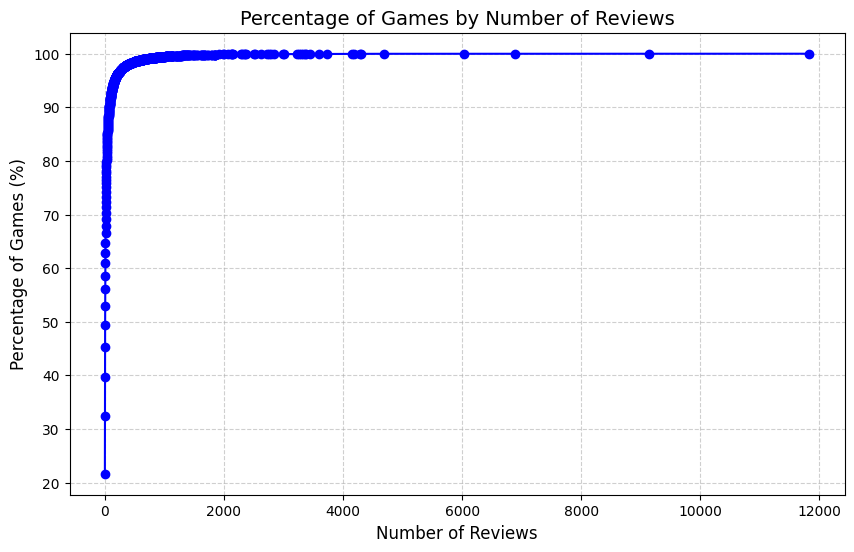

In [63]:
# Count the number of reviews per game
reviews_per_game = df_reviews.groupby('parent_asin').size()

# Calculate the cumulative percentage of games based on the number of reviews
review_counts = reviews_per_game.value_counts().sort_index()
cumulative_percentage = 100 * review_counts.cumsum() / review_counts.sum()

# Create a plot for the cumulative percentage
plt.figure(figsize=(10, 6))
plt.plot(review_counts.index, cumulative_percentage, marker='o', linestyle='-', color='b')
plt.title('Percentage of Games by Number of Reviews', fontsize=14)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Percentage of Games (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


The number of reviews per game spans a very wide range, from as few as 1 review to over 17,500 reviews. However, the vast majority of games have fewer than 200 reviews. Let's take a closer look at this distribution.

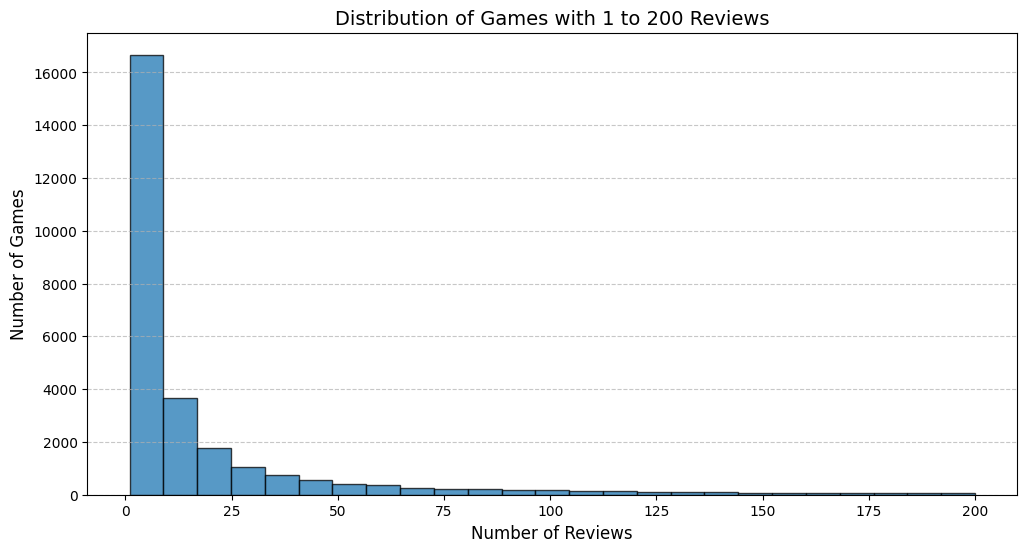

In [64]:
# Count reviews per game (parent_asin represents the game ID)
reviews_per_game = df_reviews['parent_asin'].value_counts()

# Filter games with reviews between 1 and 200
filtered_reviews_per_game = reviews_per_game[(reviews_per_game >= 1) & (reviews_per_game <= 200)]

# Plot the filtered distribution
plt.figure(figsize=(12, 6))
plt.hist(filtered_reviews_per_game, bins=25, edgecolor='black', alpha=0.75)
plt.title('Distribution of Games with 1 to 200 Reviews', fontsize=14)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It is evident that a large number of games have very few reviews. Deciding what constitutes 'too few' is a challenging task, as there is no general rule for this. However, as mentioned earlier, the relationship between various factors can guide us in making this decision.

To approach this, we will analyze the impact of filtering out games with fewer than 10 reviews, fewer than 20 reviews, and so on. By doing so, we aim to gain a deeper understanding of how these thresholds affect the dataset and guide our next steps.

In [65]:
reviews_per_game = df_reviews['parent_asin'].value_counts()

def print_games_with_reviews(reviews_per_game, start=10, end=200, step=50):
    for threshold in range(start, end + 1, step):
        games_with_reviews = reviews_per_game[reviews_per_game >= threshold]
        print(f"Number of games with at least {threshold} reviews: {len(games_with_reviews)}")

# Use the function to print results
print_games_with_reviews(reviews_per_game, start=10, end=200, step=10)


Number of games with at least 10 reviews: 11131
Number of games with at least 20 reviews: 7325
Number of games with at least 30 reviews: 5640
Number of games with at least 40 reviews: 4626
Number of games with at least 50 reviews: 3941
Number of games with at least 60 reviews: 3430
Number of games with at least 70 reviews: 3030
Number of games with at least 80 reviews: 2742
Number of games with at least 90 reviews: 2481
Number of games with at least 100 reviews: 2273
Number of games with at least 110 reviews: 2071
Number of games with at least 120 reviews: 1897
Number of games with at least 130 reviews: 1770
Number of games with at least 140 reviews: 1634
Number of games with at least 150 reviews: 1534
Number of games with at least 160 reviews: 1450
Number of games with at least 170 reviews: 1359
Number of games with at least 180 reviews: 1275
Number of games with at least 190 reviews: 1212
Number of games with at least 200 reviews: 1145


The relationship between increasing the minimum required number of reviews and the decreasing number of games is evident. To explore this further, we will focus on specific thresholds: 20, 40, 60, and 80 reviews. By narrowing our analysis to these groups, we aim to uncover insights and determine the most effective approach moving forward.

In [66]:
# Count reviews per game
reviews_per_game = df_reviews['parent_asin'].value_counts()

def filter_games_by_reviews(reviews_per_game, start=20, end=80, step=20):
    filtered_games = {}
    for threshold in range(start, end + 1, step):
        games = reviews_per_game[reviews_per_game >= threshold].index
        filtered_games[threshold] = games
        print(f"Number of games with at least {threshold} reviews: {len(games)}")
    return filtered_games

filtered_games = filter_games_by_reviews(reviews_per_game, start=20, end=80, step=20)


Number of games with at least 20 reviews: 7325
Number of games with at least 40 reviews: 4626
Number of games with at least 60 reviews: 3430
Number of games with at least 80 reviews: 2742


In [67]:
# Count reviews per game (asin represents the game ID)
reviews_per_game = df_reviews['parent_asin'].value_counts()

# Identify games with at least X reviews (up to 100 reviews)
games_with_more_than_10_reviews = reviews_per_game[reviews_per_game >= 10].index
games_with_more_than_20_reviews = reviews_per_game[reviews_per_game >= 20].index
games_with_more_than_40_reviews = reviews_per_game[reviews_per_game >= 40].index
games_with_more_than_60_reviews = reviews_per_game[reviews_per_game >= 60].index
games_with_more_than_80_reviews = reviews_per_game[reviews_per_game >= 80].index

# Filter the dataframe to keep only these games
filtered_10_df_reviews = df_reviews[df_reviews['parent_asin'].isin(games_with_more_than_10_reviews)]
filtered_20_df_reviews = df_reviews[df_reviews['parent_asin'].isin(games_with_more_than_20_reviews)]
filtered_40_df_reviews = df_reviews[df_reviews['parent_asin'].isin(games_with_more_than_40_reviews)]
filtered_60_df_reviews = df_reviews[df_reviews['parent_asin'].isin(games_with_more_than_60_reviews)]
filtered_80_df_reviews = df_reviews[df_reviews['parent_asin'].isin(games_with_more_than_80_reviews)]


# Display the shape of the filtered dataframes to confirm
print(f"Original dataset shape: {df_reviews.shape}")
print(f"Filtered dataset with 10 reviews at least shape: {filtered_10_df_reviews.shape}")
print(f"Filtered dataset with 20 reviews at least shape: {filtered_20_df_reviews.shape}")
print(f"Filtered dataset with 40 reviews at least shape: {filtered_40_df_reviews.shape}")
print(f"Filtered dataset with 60 reviews at least shape: {filtered_60_df_reviews.shape}")
print(f"Filtered dataset with 80 reviews at least shape: {filtered_80_df_reviews.shape}")


Original dataset shape: (1189998, 10)
Filtered dataset with 10 reviews at least shape: (1135289, 10)
Filtered dataset with 20 reviews at least shape: (1083025, 10)
Filtered dataset with 40 reviews at least shape: (1007879, 10)
Filtered dataset with 60 reviews at least shape: (949788, 10)
Filtered dataset with 80 reviews at least shape: (902695, 10)


**Understanding the Results:**

For the base situation, we now have **1,189,998** reviews for **28,488** games.

*  For games with at least **10** reviews, we have **1,135,289** reviews left, for **11,131** games, meaning about **95.4%** of reviews remain.

*  For games with at least **20** reviews, we have **1,083,025** reviews left, for **7,325** games, meaning about **91.0%** of reviews remain.

*  For games with at least **40** reviews, we have **1,007,879** reviews left, for **4,626** games, meaning about **84.7%** of reviews remain.

*  For games with at least **60** reviews, we have **949,788** reviews left, for **3,430** games, meaning about **79.8%** of reviews remain.

*  For games with at least **80** reviews, we have **902,695** reviews left, for **2,742** games, meaning about **75.8%** of reviews remain.

**Analysis:**

The **10-review threshold** improves the review-to-game ratio significantly while retaining **95.4%** of the data. However, thresholds of **40**, **60** and **80** reviews show further substantial improvements in this ratio while still preserving **75-85**% of the reviews.

**Decision:**

We will continue to focus on thresholds of **40**, **60** and **80** reviews, as they provide a balanced trade-off between retaining a significant portion of the data and improving the review-to-game ratio.

As discussed earlier, in addition to the number of reviews per game and the total number of games, a third critical factor is the **number of reviews each user has submitted**.

This factor significantly impacts our ability to learn user preferences effectively. In a recommendation system, achieving the best possible results for a user depends on having sufficient data to understand their preferences. Users with very few reviews differ drastically from those with many reviews in terms of how well we can model their behavior.

To address this, we will create a **separation between users with limited reviews** and those with a minimum required number of reviews. This separation allows us to build tailored models: one for users with sufficient data and another for those with limited data. A singular model for all users is likely to perform suboptimally for both groups.

Determining the minimum number of reviews a user should have to be considered "sufficient" is challenging, for the same reasons as with the other factors. Therefore, we will rely on insights derived from the data to determine a workable threshold.



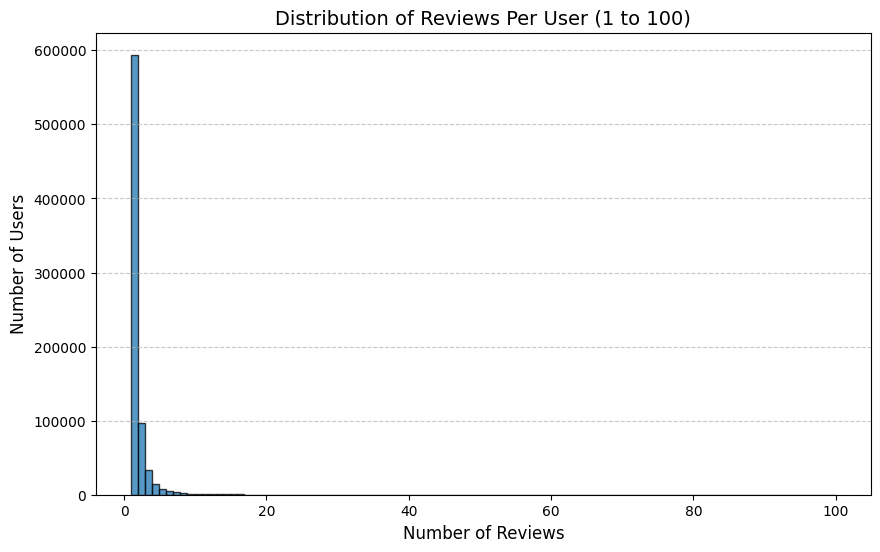

In [68]:
# Count reviews per user
reviews_per_user = df_reviews['user_id'].value_counts()

# Filter data to include users with reviews between 1 and 100
filtered_reviews_per_user = reviews_per_user[(reviews_per_user >= 1) & (reviews_per_user <= 100)]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(filtered_reviews_per_user, bins=100, edgecolor='black', alpha=0.75)
plt.title('Distribution of Reviews Per User (1 to 100)', fontsize=14)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It is easy to see that the vast majority of users have between 1 and 10 reviews. Let's focus our analysis on this group.

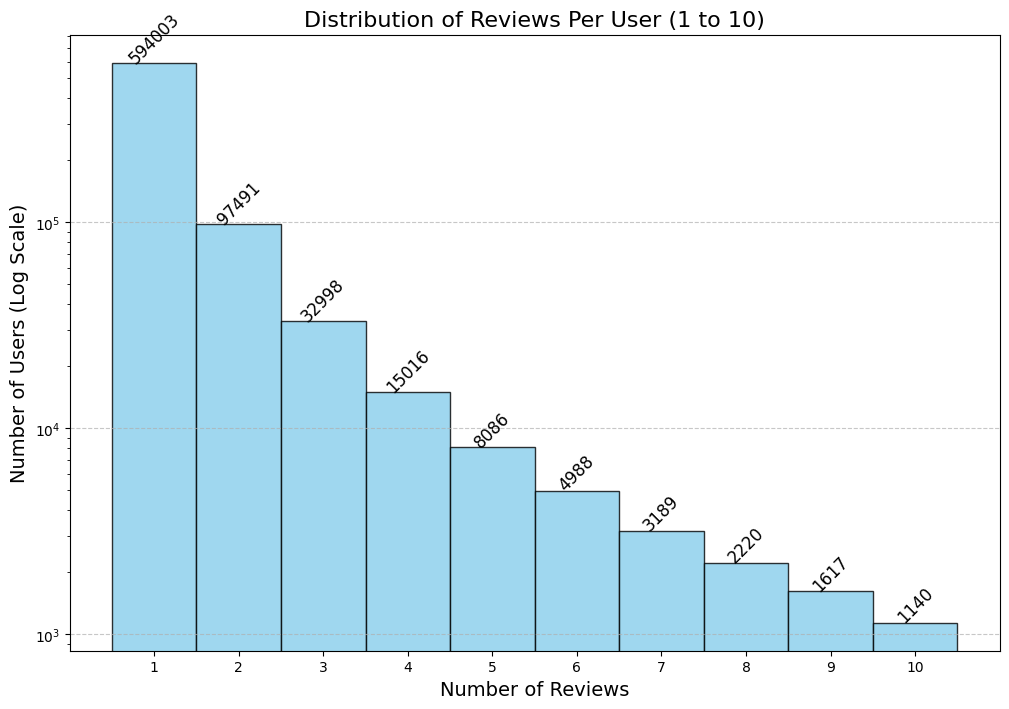

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Count reviews per user
reviews_per_user = df_reviews['user_id'].value_counts()

# Filter data to include users with reviews between 1 and 10
filtered_reviews_per_user = reviews_per_user[(reviews_per_user >= 1) & (reviews_per_user <= 10)]

# Plot the distribution
plt.figure(figsize=(12, 8))
bins = np.arange(1, 12)

plt.hist(filtered_reviews_per_user, bins=bins, edgecolor='black', alpha=0.8, color='skyblue', log=True)
plt.title('Distribution of Reviews Per User (1 to 10)', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=14)
plt.ylabel('Number of Users (Log Scale)', fontsize=14)

# Annotate bars with exact counts
for i in range(len(bins)-1):
    count = ((filtered_reviews_per_user >= bins[i]) & (filtered_reviews_per_user < bins[i+1])).sum()
    plt.text(bins[i] + 0.5, count + 10, str(count), ha='center', fontsize=12, rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(bins[:-1] + 0.5, bins[:-1])
plt.show()


Lets have a clear presentation of the number of users with different amount of minimum reviews:

In [70]:
# Calculate the number of reviews per user
reviews_per_user = df_reviews.groupby('user_id').size()

# Calculate the number of users with at least x reviews for x in range 1 to 10
users_with_at_least_x_reviews = {x: (reviews_per_user >= x).sum() for x in range(1, 11)}

# Create a DataFrame for better visualization
import pandas as pd
result_df = pd.DataFrame({
    "Minimum Reviews": list(users_with_at_least_x_reviews.keys()),
    "Number of Users": list(users_with_at_least_x_reviews.values())
})

# Display the result
print(result_df)


   Minimum Reviews  Number of Users
0                1           766104
1                2           172101
2                3            74610
3                4            41612
4                5            26596
5                6            18510
6                7            13522
7                8            10333
8                9             8113
9               10             6496


The threshold for the minimum number of reviews per user must strike a balance between retaining a sufficient number of users for meaningful analysis and ensuring enough "quality" data to understand user preferences effectively.

-  **1–3 reviews** : This is too few for advanced models that rely on user interactions to make accurate recommendations.

- **6 or more reviews** : This would leave us with only about **2.4%** of active users, which may not provide enough data to work with effectively.

- **4 reviews** : This threshold retains about **5.4%** of users, corresponding to approximately **42K** users.

-  **5 reviews** : This threshold retains about **3.4%** of users, corresponding to approximately **27K** users.

We will further examine the effects of other factors—such as the number of reviews per game and dataset sparsity—on these thresholds to decide on an optimal value for the minimum number of reviews per user.

In addition, we should limit the maximum number of reviews a user can have to mitigate the influence of highly active users (outliers) who might skew the recommendations.

We have decided to set the maximum limit at **40** reviews, as the vast majority of users have fewer than **40** reviews. This threshold strikes a sensible balance, ensuring a sufficient gap between the minimum requirement of **5/4** reviews and the maximum limit, while effectively excluding potential outliers

After filtering the datasets to include only **games with a minimum of X reviews** and then applying the additional requirement of **Y reviews per user**, the number of games is likely to decrease. This is because some games that initially met the **X reviews** threshold may now fall below it due to the removal of reviews from users who do not meet the **Y reviews** criterion.

To address this, we will apply another filtering process to ensure consistency. Finally, we will present a density matrix for all possible combinations of thresholds (datasets with 50 and 100 minimum reviews for games, and 4 and 5 minimum reviews for users).

In [71]:
def filter_data(df, min_game_reviews=100, min_user_reviews=5, max_user_reviews=40):
    stable = False
    while not stable:
        # Filter games with at least min_game_reviews
        game_counts = df['parent_asin'].value_counts()
        eligible_games = game_counts[game_counts >= min_game_reviews].index
        df = df[df['parent_asin'].isin(eligible_games)]

        # Filter users with at least min_user_reviews and at most max_user_reviews
        user_counts = df['user_id'].value_counts()
        eligible_users = user_counts[(user_counts >= min_user_reviews) & (user_counts <= max_user_reviews)].index
        df = df[df['user_id'].isin(eligible_users)]

        # Check stability
        new_game_counts = df['parent_asin'].value_counts()
        new_eligible_games = new_game_counts[new_game_counts >= min_game_reviews].index
        new_user_counts = df['user_id'].value_counts()
        new_eligible_users = new_user_counts[
            (new_user_counts >= min_user_reviews) & (new_user_counts <= max_user_reviews)
        ].index

        stable = (
            set(eligible_games) == set(new_eligible_games) and
            set(eligible_users) == set(new_eligible_users)
        )
    return df

# Apply the function
filtered_reviews_40_4 = filter_data(df_reviews, min_game_reviews=40, min_user_reviews=4)
filtered_reviews_60_4 = filter_data(df_reviews, min_game_reviews=60, min_user_reviews=4)
filtered_reviews_80_4 = filter_data(df_reviews, min_game_reviews=80, min_user_reviews=4)
filtered_reviews_40_5 = filter_data(df_reviews, min_game_reviews=40, min_user_reviews=5)
filtered_reviews_60_5 = filter_data(df_reviews, min_game_reviews=60, min_user_reviews=5)
filtered_reviews_80_5 = filter_data(df_reviews, min_game_reviews=80, min_user_reviews=5)


In [72]:
import pandas as pd

def analyze_dataset(filtered_dataset, dataset_name):
    # Calculate metrics
    num_users = filtered_dataset['user_id'].nunique()
    num_games = filtered_dataset['parent_asin'].nunique()
    num_reviews = len(filtered_dataset)

    # Calculate matrix density
    if num_users > 0 and num_games > 0:
        matrix_density = num_reviews / (num_users * num_games)
    else:
        matrix_density = 0  # Handle edge case with no users or games

    # Return metrics as a dictionary
    return {
        'Number of Users': num_users,
        'Number of Games': num_games,
        'Number of Reviews': num_reviews,
        'Matrix Density': matrix_density
    }

def analyze_multiple_datasets(datasets):
    results = {}
    for name, dataset in datasets.items():
        results[name] = analyze_dataset(dataset, name)

    # Convert results to DataFrame for better visualization
    summary_df = pd.DataFrame.from_dict(results, orient='index')
    return summary_df

# Analyze datasets
datasets = {
    '40 Reviews & 4+ User Reviews': filtered_reviews_40_4,
    '60 Reviews & 4+ User Reviews': filtered_reviews_60_4,
    '80 Reviews & 4+ User Reviews': filtered_reviews_80_4,
    '40 Reviews & 5+ User Reviews': filtered_reviews_40_5,
    '60 Reviews & 5+ User Reviews': filtered_reviews_60_5,
    '80 Reviews & 5+ User Reviews': filtered_reviews_80_5
}

density_summary = analyze_multiple_datasets(datasets)
density_summary

Number of Users  Number of Games  \
40 Reviews & 4+ User Reviews            17023              925   
60 Reviews & 4+ User Reviews            11331              481   
80 Reviews & 4+ User Reviews             6000              217   
40 Reviews & 5+ User Reviews             7234              541   
60 Reviews & 5+ User Reviews                0                0   
80 Reviews & 5+ User Reviews                0                0   

                              Number of Reviews  Matrix Density  
40 Reviews & 4+ User Reviews             105316        0.006688  
60 Reviews & 4+ User Reviews              67752        0.012431  
80 Reviews & 4+ User Reviews              33921        0.026053  
40 Reviews & 5+ User Reviews              53564        0.013687  
60 Reviews & 5+ User Reviews                  0        0.000000  
80 Reviews & 5+ User Reviews                  0        0.000000

Its clear that the limit of reviews isnt suting the 5+ users as well as it does for the 4+ users, so we will adjust for it a more suitable limits.

In [73]:
filtered_reviews_40_5 = filter_data(df_reviews, min_game_reviews=40, min_user_reviews=5)
filtered_reviews_45_5 = filter_data(df_reviews, min_game_reviews=45, min_user_reviews=5)
filtered_reviews_50_5 = filter_data(df_reviews, min_game_reviews=50, min_user_reviews=5)

def analyze_multiple_datasets(datasets):
    results = {}
    for name, dataset in datasets.items():
        results[name] = analyze_dataset(dataset, name)

    # Convert results to DataFrame for better visualization
    summary_df = pd.DataFrame.from_dict(results, orient='index')
    return summary_df

# Analyze datasets
datasets = {
    '40 Reviews & 4+ User Reviews': filtered_reviews_40_4,
    '60 Reviews & 4+ User Reviews': filtered_reviews_60_4,
    '80 Reviews & 4+ User Reviews': filtered_reviews_80_4,
    '40 Reviews & 5+ User Reviews': filtered_reviews_40_5,
    '45 Reviews & 5+ User Reviews': filtered_reviews_45_5,
    '50 Reviews & 5+ User Reviews': filtered_reviews_50_5
}

density_summary = analyze_multiple_datasets(datasets)
density_summary

Number of Users  Number of Games  \
40 Reviews & 4+ User Reviews            17023              925   
60 Reviews & 4+ User Reviews            11331              481   
80 Reviews & 4+ User Reviews             6000              217   
40 Reviews & 5+ User Reviews             7234              541   
45 Reviews & 5+ User Reviews             5963              420   
50 Reviews & 5+ User Reviews             4510              304   

                              Number of Reviews  Matrix Density  
40 Reviews & 4+ User Reviews             105316        0.006688  
60 Reviews & 4+ User Reviews              67752        0.012431  
80 Reviews & 4+ User Reviews              33921        0.026053  
40 Reviews & 5+ User Reviews              53564        0.013687  
45 Reviews & 5+ User Reviews              43510        0.017373  
50 Reviews & 5+ User Reviews              32323        0.023576

The main datasets under consideration are "**80 Reviews & 4+ User Reviews**" and "**50 Reviews & 5+ User Reviews**", as they offer the highest matrix density among the options.

Both datasets preserve a similar number of reviews, but they differ in the ratio of games to users. Considering our goal—to assess which games a user would likely be interested in based on previous purchases from the available catalog—we have selected the "**50 Reviews & 5+ User Reviews**" dataset. The reasons for this choice are as follows:

*  **High Matrix Density**: A density of 0.023576 ensures the recommendation system has sufficient interaction data to effectively learn patterns of likely purchases based on user reviews.

*  **Optimal Balance Between Size and Feasibility**: While this dataset has fewer users and games compared to others, the higher quality of data (more reviews per user) is crucial for building a robust model that accurately predicts user preferences.

* **Manageability and Efficiency**: The smaller size of this dataset reduces computational complexity, making it more suitable for iterative development and testing without compromising recommendation quality.

In conclusion, the **"50 Reviews & 5+ User Reviews"** dataset provides an excellent trade-off between density, size, and computational efficiency, making it the most suitable choice for our recommendation system.


The dataset achives a density of **0.023576** - compared to the initial **0.000055** it is showing an increas in density of over **428** times. While the data remains relatively sparse, this density is closer to typical conditions for employing advanced recommendation approaches, such as collaborative filtering, which depend on sufficient user interaction data.

This separation provides a strong foundation for enhancing our system, enabling us to better leverage user behavior and interactions to build more accurate recommendations.

In [74]:
filtered_reviews = filtered_reviews_50_5

filtered_parent_asins = filtered_reviews['parent_asin'].unique()

filtered_meta = df_meta[df_meta['parent_asin'].isin(filtered_parent_asins)]

# Display the result
print(f"Original df_meta size: {df_meta.shape}")
print(f"Filtered df_meta size: {filtered_meta.shape}")
filtered_meta.head()


Original df_meta size: (28488, 12)
Filtered df_meta size: (304, 12)


title  average_rating  \
106                Assassin's Creed IV Black Flag - PC             4.1   
179            Mass Effect Andromeda Deluxe - Xbox One             4.3   
181      LEGO Batman 2: DC Super Heroes - Nintendo 3DS             4.6   
457  Grand Theft Auto V: Premium Edition - Xbox One...             4.6   
590  Dead Island Riptide Special Edition - Playstat...             4.1   

     rating_number                                           features  \
106            286  [A BRASH REBEL ASSASSIN: Become Edward Kenway,...   
179           1142  [Deluxe includes: Pathfinder Casual Outfit, Sc...   
181            344  [Brand New in box. The product ships with all ...   
457            858  [When a young street hustler, a retired bank r...   
590            228  [Special Edition Includes Alternate Character ...   

                                           description  price  \
106  [From the Manufacturer, Assassin's Creed, ®, I...  43.89   
179  [Mass Effect: Andromeda pits you and your crew...  36.95   
181  [Product Description, The Dynamic Duo returns ...  28.05   
457  [The Grand Theft Auto V: Premium Edition inclu...   15.0   
590  [Product Description, Dead Island Riptide is a...  28.98   

               store                                         categories  \
106          Ubisoft                           [Video Games, PC, Games]   
179  Electronic Arts                     [Video Games, Xbox One, Games]   
181         WB Games  [Video Games, Legacy Systems, Nintendo Systems...   
457   Rockstar Games                     [Video Games, Xbox One, Games]   
590      Square Enix  [Video Games, Legacy Systems, PlayStation Syst...   

    parent_asin  price_numeric       Category_Group games_Group  
106  B00BN5T30E          43.89            PC Gaming       Games  
179  B01GY35HKE          36.95         Xbox Systems       Games  
181  B007YZCE94          28.05     Nintendo Systems       Games  
457  B0086VPUHI          15.00         Xbox Systems       Games  
590  B008B3QCJQ          28.98  PlayStation Systems       Games

Now, we will proceed to perform a more detailed EDA on the refined dataset to uncover deeper patterns and relationships. While the initial EDA provided a broad overview of the raw data, this stage focuses on specific trends, correlations, and interactions within the cleaned dataset. By leveraging advanced analytical techniques, we aim to extract actionable insights that directly align with the project’s objectives.

### Comparing the Raw and Refined Data

We'll start by seeing some of the distrubutions formerly presented on the raw data and see if there were any significant changes in the nature of the data

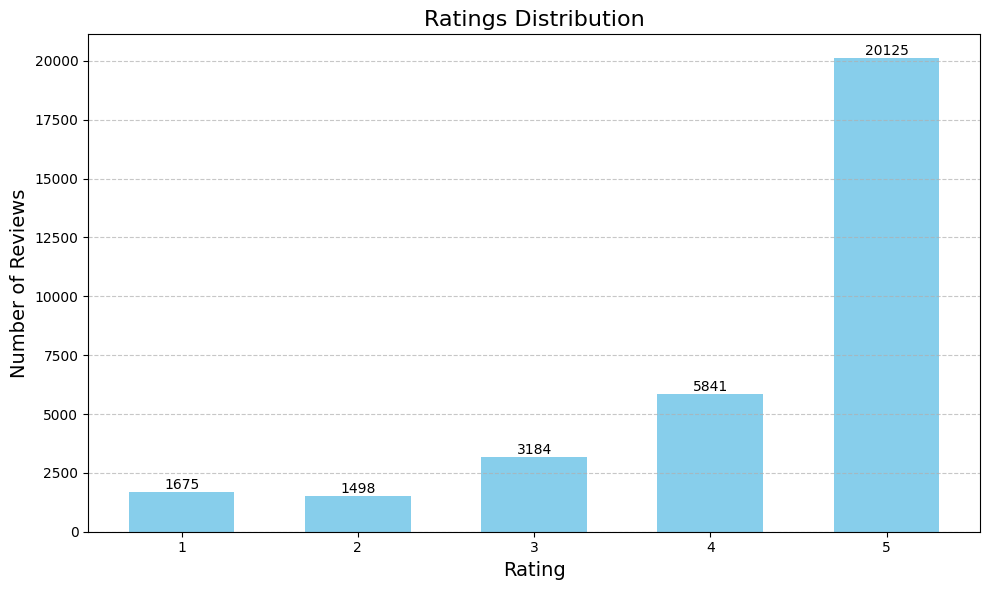

In [75]:
# Calculate the distribution of ratings
ratings_distribution = filtered_reviews['rating'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(ratings_distribution.index, ratings_distribution.values, color='skyblue', width=0.6)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

plt.title('Ratings Distribution', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(ratings_distribution.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

The trends observed in the refined dataset largely mirror those of the raw dataset, with some notable differences. While the 5-star rating remains the most common by a significant margin, there is a shift in the relative standings of other ratings. Specifically:

*  The **1-star** rating has moved from the 3rd most common position in the raw data to 4th in the refined dataset.

*  The **3-star** rating has risen from 4th to 3rd most common.

*  The **4-star** and **2-star** ratings remain in 2nd and 5th positions, respectively.

This shift likely reflects the filtering process, which focused on games with higher levels of interaction. Games with lower ratings typically attract fewer users and, consequently, fewer reviews, making them less likely to meet the inclusion criteria during refinement.

These observations further support the need to implement **weighting based on ratings** to address the imbalance between high and low ratings in the dataset. By compensating for the underrepresentation of lower ratings, we can ensure a more balanced perspective in the recommendation system, improving its fairness and effectiveness.

Now for the meta data game rating distribution.

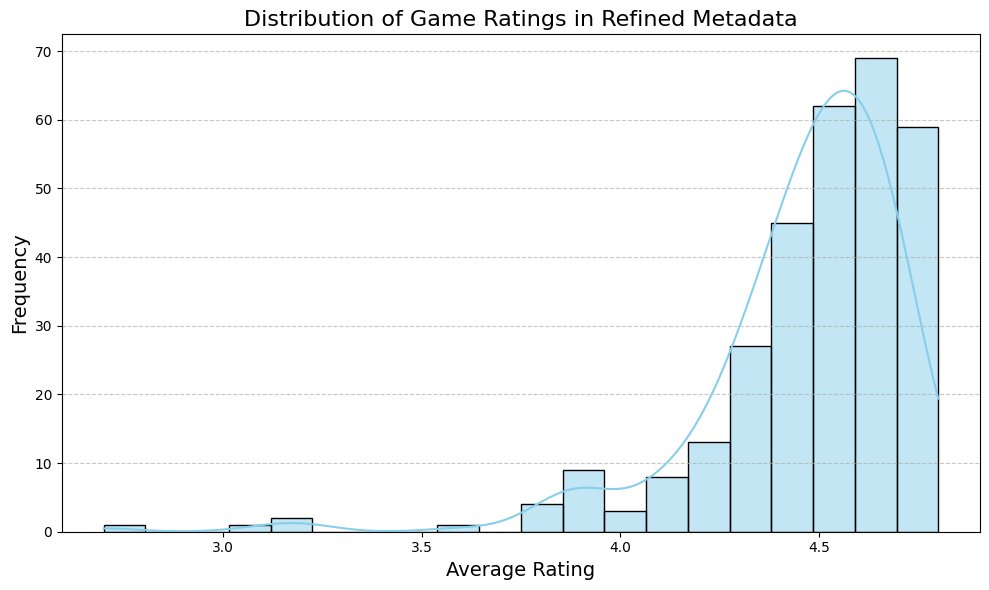

In [76]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_meta['average_rating'], bins=20, kde=True, color='skyblue')

plt.title('Distribution of Game Ratings in Refined Metadata', fontsize=16)
plt.xlabel('Average Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Both datasets show a right-skewed distribution with most ratings clustered between **4.25** and **5.0**, indicating a general tendency for favorable reviews. However after refinment ratings are now predominantly between 3.5 and 5.0, with very few ratings below 3.5. This indicates the removal of low-quality or irrelevant items, thus more suitable for building a recommendation system due to its focus on higher ratings and reduced noise.

The refined metadata is better aligned with the target audience's interests, as it focuses on highly rated games, and should lead to more accurate and relevant recommendations, as it emphasizes user preferences for well-reviewed items.



Now we will look for the average number of helpful votes for reviews per rating on the  refined data.

rating
1    6.443582
2    4.062083
3    3.034548
4    1.818867
5    1.582261
Name: helpful_vote, dtype: float64


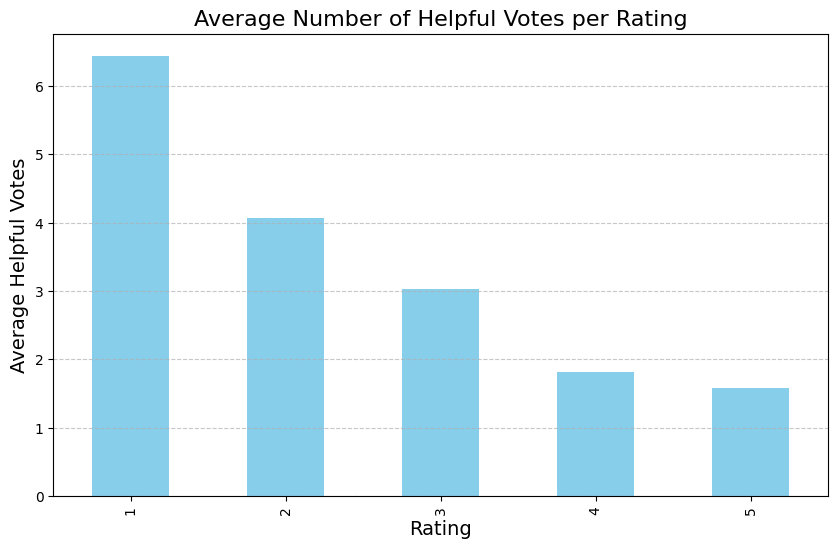

In [77]:

avg_helpful_votes = filtered_reviews.groupby('rating')['helpful_vote'].mean()
print(avg_helpful_votes)

# Plot average helpful votes per rating
avg_helpful_votes.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Average Number of Helpful Votes per Rating', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Average Helpful Votes', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In the refined dataset, reviews across all ratings show higher average helpful votes compared to the raw dataset, indicating that the refinement process prioritized more engaging and impactful feedback. Negative reviews (**1-star**) remain the most helpful, with the highest votes in both datasets, highlighting their importance in influencing user decisions. This shift makes the refined dataset more representative of meaningful user interactions and aligns well with the objectives of building a recommendation system that values review quality.

We now examine the distribution of category groups in our filtered data.



Category_Group
PlayStation Systems    139
Xbox Systems           101
Nintendo Systems        46
PC Gaming               18
Name: count, dtype: int64


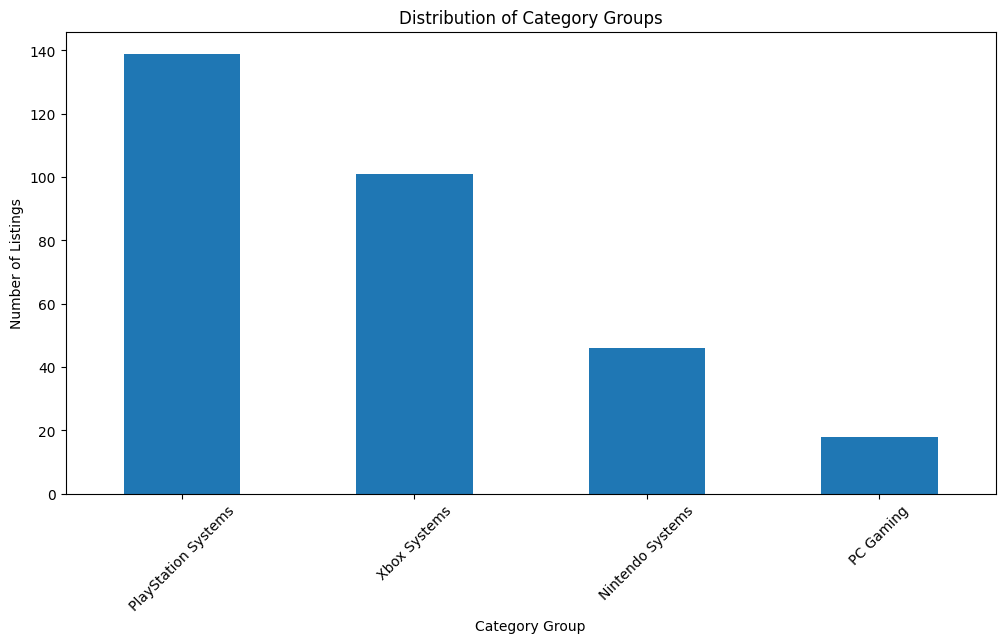

In [78]:

distribution = filtered_meta['Category_Group'].value_counts()

# Display the distribution
print(distribution)

plt.figure(figsize=(12, 6))
distribution.plot(kind='bar')
plt.title('Distribution of Category Groups')
plt.xlabel('Category Group')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.show()

The data reveals four possible values with a reasonable distribution. Each value linked to a gaming console, which makes the analysis more informative. For instance, if a user primarily purchases games for Nintendo systems, it is more likely that their future purchases will also target this platform, as they likely own a Nintendo console and not others.

We'll save the progress we made in order to save on ram for later usages.

In [79]:

# Save the file to Google Drive
filtered_reviews.to_csv('/content/drive/My Drive/filtered_reviews.csv', index=False)

filtered_meta.to_csv('/content/drive/My Drive/filtered_meta.csv', index=False)

## Advenced Data Exploration

Now, we will proceed to perform a more detailed EDA on the refined dataset to uncover deeper patterns and relationships. While the initial EDA provided a broad overview of the raw data, this stage focuses on specific trends, correlations, and interactions within the cleaned dataset. By leveraging advanced analytical techniques, we aim to extract actionable insights that directly align with the project’s objectives.

In [3]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

file_path_filtered_reviews = '/content/drive/My Drive/filtered_reviews.csv'
file_path_filtered_meta = '/content/drive/My Drive/filtered_meta.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
filtered_reviews = pd.read_csv(file_path_filtered_reviews)
filtered_meta = pd.read_csv(file_path_filtered_meta)

In [5]:
filtered_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32323 entries, 0 to 32322
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rating             32323 non-null  int64 
 1   title              32323 non-null  object
 2   text               32310 non-null  object
 3   asin               32323 non-null  object
 4   parent_asin        32323 non-null  object
 5   user_id            32323 non-null  object
 6   timestamp          32323 non-null  object
 7   helpful_vote       32323 non-null  int64 
 8   verified_purchase  32323 non-null  bool  
 9   review_length      32323 non-null  int64 
dtypes: bool(1), int64(3), object(6)
memory usage: 2.3+ MB


In [6]:
filtered_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           304 non-null    object 
 1   average_rating  304 non-null    float64
 2   rating_number   304 non-null    int64  
 3   features        304 non-null    object 
 4   description     304 non-null    object 
 5   price           304 non-null    float64
 6   store           304 non-null    object 
 7   categories      304 non-null    object 
 8   parent_asin     304 non-null    object 
 9   price_numeric   304 non-null    float64
 10  Category_Group  304 non-null    object 
 11  games_Group     304 non-null    object 
dtypes: float64(3), int64(1), object(8)
memory usage: 28.6+ KB


### Feature Selection and Dataset Dilution

As part of this project, we performed feature selection to ignore attributes that had little to no impact on predictive performance. Following the provided guidelines, we will exclude these features from further analysis to streamline the dataset and enhance model efficiency.

The decision to discard specific features was based on their low contribution to prediction accuracy, as determined through feature importance analysis in the later stages of this project. Removing these features helps reduce computational complexity while preserving model performance.

Although these features may still inform certain decisions, they will not be analyzed further concerning their relationships with other variables.

For the Reviews Data:

- asin
- helpful_vote

For the Meta Data:

- price
- price_numeric
- store
- categories
- Category_Group
- games_Group

#### Visualize Features Correlation

We now set to gain better insights on our refined dataset.

Lets explore the the trends of ratings over time of submitted reviews.



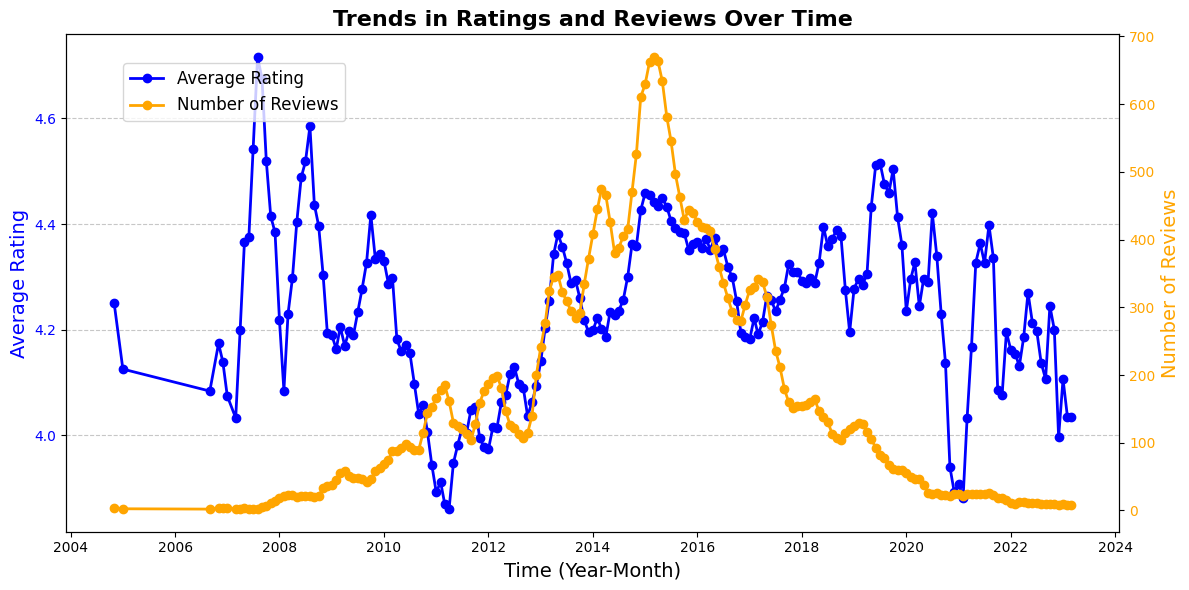

In [8]:
import matplotlib.pyplot as plt

filtered_reviews['year_month'] = pd.to_datetime(filtered_reviews['timestamp']).dt.to_period('M')

trend_data = filtered_reviews.groupby('year_month').agg(
    avg_rating=('rating', 'mean'),
    num_reviews=('rating', 'count')
).reset_index()

# Convert 'year_month' to a datetime format for plotting
trend_data['year_month'] = trend_data['year_month'].dt.to_timestamp()


# Apply a rolling mean for smoothing (optional, set window size based on data density)
trend_data['avg_rating_smooth'] = trend_data['avg_rating'].rolling(window=6, min_periods=1).mean()
trend_data['num_reviews_smooth'] = trend_data['num_reviews'].rolling(window=6, min_periods=1).mean()


fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average rating on the left y-axis
ax1.plot(
    trend_data['year_month'], trend_data['avg_rating_smooth'],
    label='Average Rating', color='blue', marker='o', linewidth=2
)
ax1.set_ylabel('Average Rating', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for number of reviews
ax2 = ax1.twinx()
ax2.plot(
    trend_data['year_month'], trend_data['num_reviews_smooth'],
    label='Number of Reviews', color='orange', marker='o', linewidth=2
)
ax2.set_ylabel('Number of Reviews', fontsize=14, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Trends in Ratings and Reviews Over Time', fontsize=16, fontweight='bold')
ax1.set_xlabel('Time (Year-Month)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), fontsize=12)
plt.tight_layout()

plt.show()


From these results, we observe a significant increase in the number of reviews starting around **2013**, peaking between **2014 and 2017**. This trend is likely influenced by the release of the "new-gen" consoles, **Xbox One** and **PlayStation 4**, in **2013**, followed by their "pro" versions launched in early **2017**.

To gain deeper insights, we will focus on three specific periods:

1.  "**Old-gen**" (**2005–2012**): Covers the era of Xbox 360, PS3, and Wii, preceding the "new-gen" wave.

2.  "**New-gen First Wave**" (**2013–2016**): Includes the initial release period of Xbox One and PS4.

3.  "**New-gen Second Wave**" (**2017–2023**): Represents the era of the "pro" versions and incremental upgrades.


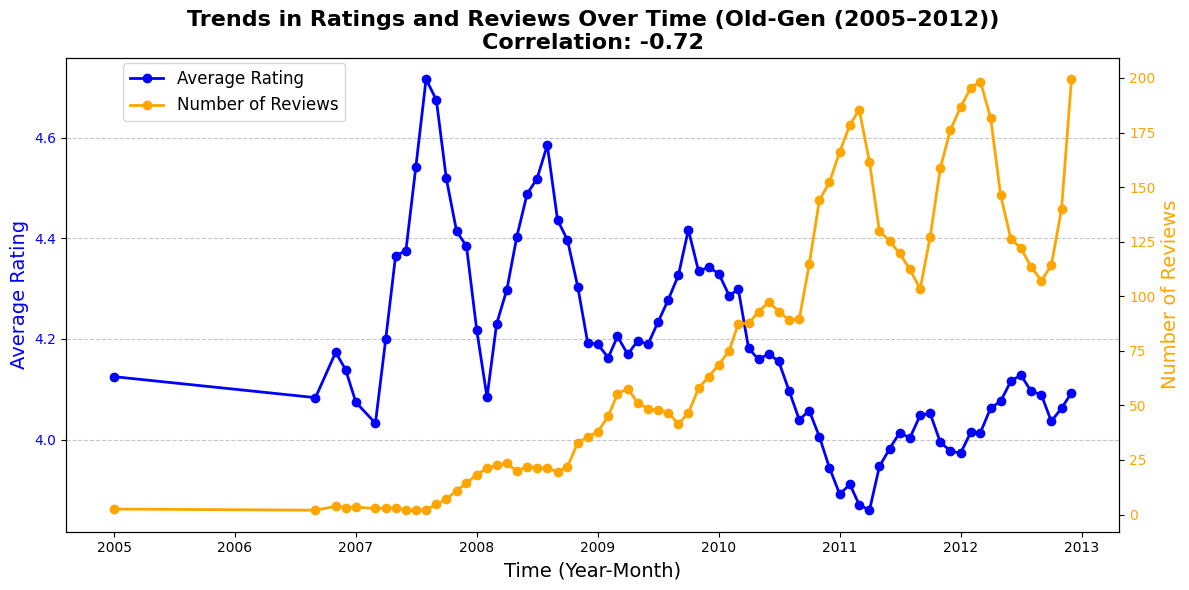

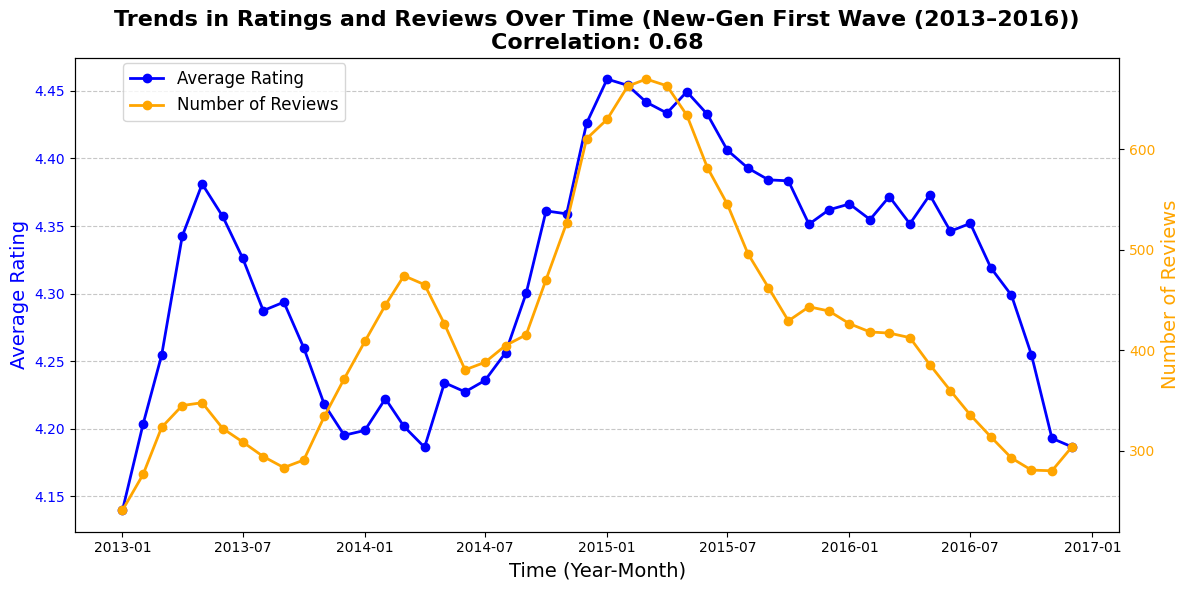

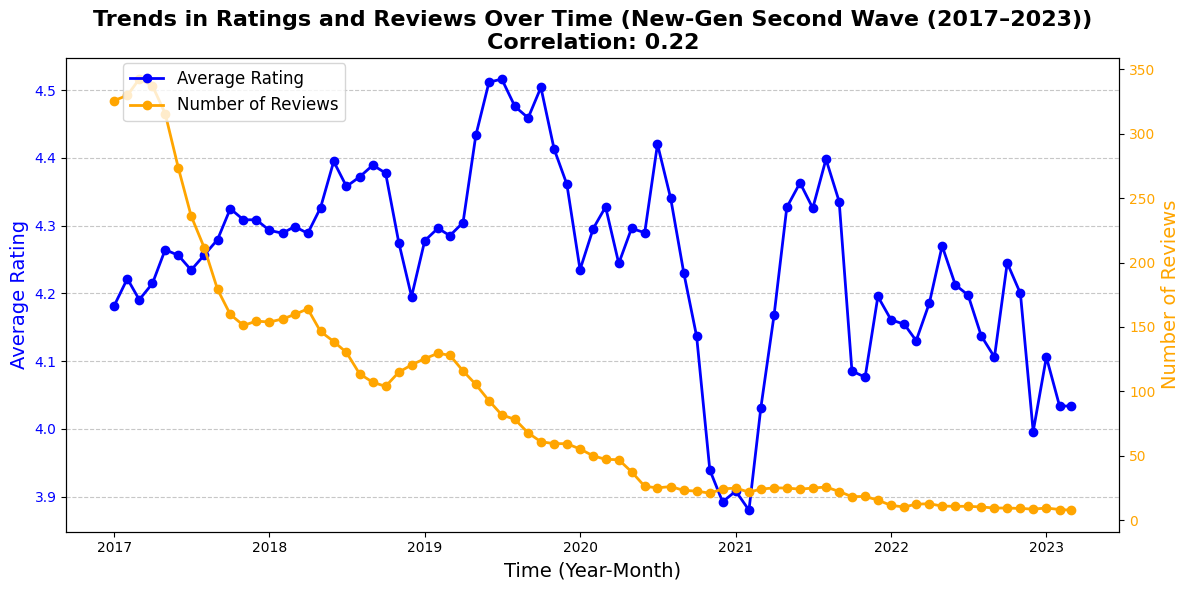

In [9]:
# Filter data into specified periods
old_gen = trend_data[(trend_data['year_month'] >= '2005-01') & (trend_data['year_month'] <= '2012-12')]
new_gen_first_wave = trend_data[(trend_data['year_month'] >= '2013-01') & (trend_data['year_month'] <= '2016-12')]
new_gen_second_wave = trend_data[(trend_data['year_month'] >= '2017-01') & (trend_data['year_month'] <= '2023-12')]

# Create a function to calculate correlation and visualize each period
def visualize_period_with_correlation(data, title):
    # Calculate the correlation between smoothed average rating and number of reviews
    correlation = data['avg_rating_smooth'].corr(data['num_reviews_smooth'])

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot average rating on the left y-axis
    ax1.plot(
        data['year_month'], data['avg_rating_smooth'],
        label='Average Rating', color='blue', marker='o', linewidth=2
    )
    ax1.set_ylabel('Average Rating', fontsize=14, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for number of reviews
    ax2 = ax1.twinx()
    ax2.plot(
        data['year_month'], data['num_reviews_smooth'],
        label='Number of Reviews', color='orange', marker='o', linewidth=2
    )
    ax2.set_ylabel('Number of Reviews', fontsize=14, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    plt.title(
        f'Trends in Ratings and Reviews Over Time ({title})\nCorrelation: {correlation:.2f}',
        fontsize=16, fontweight='bold'
    )
    ax1.set_xlabel('Time (Year-Month)', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), fontsize=12)
    plt.tight_layout()

    plt.show()

#Visualize each period with correlation
visualize_period_with_correlation(old_gen, 'Old-Gen (2005–2012)')
visualize_period_with_correlation(new_gen_first_wave, 'New-Gen First Wave (2013–2016)')
visualize_period_with_correlation(new_gen_second_wave, 'New-Gen Second Wave (2017–2023)')


We observe clear differences in trends across the defined periods, reflecting the lifecycle of gaming consoles and their influence on user engagement and opinions.

1. **Old-Gen Era** (**2005–2012**): A strong negative correlation (**-0.72**) exists between the number of reviews and the average ratings. This trend reflects the lifecycle of older-generation consoles: as the hardware aged, it became more affordable and accessible to a broader audience. With this broader reach, reviews likely became more diverse, resulting in lower average ratings over time.

2. **New-Gen Era – First Wave** (**2013–2016**): A strong positive correlation (**0.68**) is evident between the number of reviews and the average ratings. This likely corresponds to the excitement surrounding the release of new-generation consoles, which brought advancements in gaming quality and features. These innovations attracted new gamers, generating positive feedback and higher engagement. Early adopters, who are typically more enthusiastic, likely drove this increase in both the number of reviews and satisfaction levels.

3. **New-Gen Era – Second Wave** (**2017–2023**): A weak positive correlation (**0.22**) is observed during this period. While ratings remained relatively consistent, the number of reviews declined. This trend may reflect market saturation or reduced excitement as the console generation matured. Over time, as the user base stabilized, engagement (review counts) naturally decreased.


From that we understand that the lifecycle of gaming consoles significantly impacts audience sentiment and engagement. Early in a console's lifecycle, we see increased interactions and higher ratings due to enthusiasm and early adopters. Toward the end of the lifecycle, engagement declines, and ratings stabilize as broader, more diverse opinions shape the overall sentiment.

This analysis highlights how the timing of reviews correlates with average ratings, depending on the era.

Given this correlation between the time period and user sentiment, we will introduce a new feature that represents the era (e.g., **Old-Gen**, **New-Gen First Wave**, etc.) instead of relying solely on raw timestamps. This will simplify the integration of temporal data into the recommendation system while preserving meaningful context.



In [10]:
# Convert timestamp to datetime
filtered_reviews['timestamp'] = pd.to_datetime(filtered_reviews['timestamp'], errors='coerce')


def assign_era(timestamp):
    if timestamp <= pd.Timestamp('2012-12-31'):
        return 'Old-Gen'
    elif pd.Timestamp('2013-01-01') <= timestamp <= pd.Timestamp('2016-12-31'):
        return 'New-Gen First Wave'
    else:
        return 'New-Gen Second Wave'


filtered_reviews['era'] = filtered_reviews['timestamp'].apply(lambda x: assign_era(x))


filtered_reviews[['timestamp', 'era']].head(10)


timestamp                 era
0 2010-10-10 21:35:07             Old-Gen
1 2011-03-31 21:38:08             Old-Gen
2 2011-03-31 21:35:00             Old-Gen
3 2011-03-01 01:28:28             Old-Gen
4 2010-11-11 20:19:26             Old-Gen
5 2011-10-26 04:43:50             Old-Gen
6 2011-09-07 00:23:52             Old-Gen
7 2014-04-19 13:45:35  New-Gen First Wave
8 2014-07-02 03:05:58  New-Gen First Wave
9 2014-08-09 03:18:09  New-Gen First Wave

#### Extracting Additional Features

After visualizing the identified correlations, we aim to utilize the existing features, particularly those containing textual data, to create new features that enhance our understanding of the dataset. We will focus on leveraging and analyzing text-based features.

**From the review data:**

*  **title**: Represents the title of the review, typically summarizing the main points of the review.

*  **text**: Represents the full review text, providing detailed feedback from the user.

**From the metadata**:

*  **title**: The name of the game.

*  **features**: Key characteristics of the game, presented in a bullet-point format.

*  **description**: A detailed description of the game, offering insights into its gameplay, story, and other relevant aspects.


On the review data we aim to preform the following:
1.  Extracting Sentiment scores for reviews .
2.  Extract a dense vector embeddings for the review text and title.
3.  Extract key words from the reviews text.
4.  Combine the sentiment score with the actual rating user gave to adjust for bias in the ratings.


On the meta data we aim to preform the following:
1.  Extract embeddings for game titles.
2.  Parse bullet points into individual phrases and encode them.
3.  Extract semantic embeddings of the description using pre-trained models.


Due to the computational complexity of some tasks, performing them solely on a Colab CPU would be challenging and time-consuming. To address this, I executed certain tasks locally, leveraging my GPU to significantly speed up the process.

In this document, I will demonstrate the same process applied to a sample subset of the data. Meanwhile, the full dataset was processed locally using my GPU for better efficiency

Because of the usage of embeddings, and that CSV files may serialize NumPy arrays into a string that loses precision or truncates values, we will decide that instead of saving as a CSV, use a binary format that preserves the full structure of NumPy arrays, such as Parquet.

##### Review Data Features

**1. Extracting Sentiment scores for reviews**:

We will use the [dnzblgn/Sentiment-Analysis-Customer-Reviews](https://huggingface.co/dnzblgn/Sentiment-Analysis-Customer-Reviews) model for this.

In [11]:

# save the DataFrame as Parquet to Google Drive
filtered_reviews.to_parquet('/content/drive/My Drive/filtered_reviews_update.parquet', index=False, engine='pyarrow')
filtered_meta.to_parquet('/content/drive/My Drive/filtered_meta_update.parquet', index=False, engine='pyarrow')


In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the model and tokenizer
model_name = "dnzblgn/Sentiment-Analysis-Customer-Reviews"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [13]:
def get_sentiment_scores_in_batches(texts, batch_size=32, max_length=128):
    all_scores = []
    total_batches = len(texts) // batch_size + (1 if len(texts) % batch_size > 0 else 0)

    for batch_idx, i in enumerate(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        # Print the current batch number
        print(f"Processing batch {batch_idx + 1}/{total_batches}")

        # Tokenize the batch with a limit on the number of tokens
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=max_length  # Limit the number of tokens
        )

        # Disable gradient computation for inference
        with torch.no_grad():
            outputs = model(**inputs)

        # Apply softmax to logits to get probabilities
        scores = torch.nn.functional.softmax(outputs.logits, dim=-1)

        # Convert tensor scores to a list and add to results
        all_scores.extend(scores.tolist())

    return all_scores



In [14]:
filtered_reviews["text"] = filtered_reviews["text"].fillna("").astype(str)

# Randomly sample 32 rows from the DataFrame
sample_reviews = filtered_reviews.sample(n=32, random_state=42)

sample_texts = sample_reviews["text"].tolist()

# Process sentiment for the sample
sample_sentiment_scores = get_sentiment_scores_in_batches(
    sample_texts,
    batch_size=32,  # Set the batch size equal to the sample size
    max_length=128
)


Processing batch 1/1


In [15]:
sample_reviews["sentiment_scores"] = sample_sentiment_scores


In [16]:
# Define sentiment labels based on the model's output
labels = ["Positive", "Negative"]

# Add a column for predicted sentiment to the sample DataFrame
sample_reviews["predicted_sentiment"] = sample_reviews["sentiment_scores"].apply(
    lambda scores: labels[scores.index(max(scores))]  # Find the label with the highest probability
)

# Display the results
sample_reviews[["text","rating", "sentiment_scores", "predicted_sentiment"]].head(32)


text  rating  \
17687  If you played and loved Fable 2 and wanted to ...       2   
9747   I bought the original for PC, the day of relea...       5   
17235                  A classic  returns  beautifully .       5   
29339  I’ve been playing Xbox for a long time now. Al...       5   
16903  If this is anything like Rez Evil 4.......coun...       5   
31437                                         Good price       5   
7033   The graphics great. Stories good. But it's so ...       1   
8999   Forget what people are saying about this box s...       5   
13768  Great game for those that are familiar with th...       5   
28582  5 star, recommend this to anyone who has xbox....       5   
17243  I must start off by saying, I love this game s...       5   
15238  Great game, but if you've played the first one...       4   
10157  This device and bundle is very good, for what ...       5   
12680  If you are like me and loved the original Spli...       4   
24291  It's good..but boy is it a button smasher. If ...       3   
16761                             Great game, I like it!       5   
3383                                               GREAT       5   
9048                                             Awesome       5   
25346  Excellent DMC style action game with incredibl...       4   
4534   After buying the PC version, I immediately got...       5   
15885  One of the last great CoD games (in my opinion...       5   
1298   This game is great and back to the roots of RE...       4   
31251  Works pretty good now, 8 months after its rele...       4   
26899  Honestly the assassins creed series has been a...       2   
24988  The original Deus Ex was a masterpiece for its...       3   
9300   Only thing I didn't like about the cover was t...       5   
14724  You've probably read it by now.  This game fee...       2   
8051                                    exellent product       5   
1330   As close to a masterpiece of a trilogy as I ha...       5   
13052  I haven't finished the game yet (will update w...       5   
5219   I'm a huge AC fan and I liked some of the inno...       3   
11963  Sean lied there is no MP . He hyped this borin...       1   

                                   sentiment_scores predicted_sentiment  
17687   [9.807582682697102e-05, 0.9999018907546997]            Negative  
9747   [0.9995935559272766, 0.00040640588849782944]            Positive  
17235   [0.9999310970306396, 6.889500218676403e-05]            Positive  
29339  [0.9999871253967285, 1.2866066754213534e-05]            Positive  
16903   [0.9995877146720886, 0.0004123426915612072]            Positive  
31437    [0.999039351940155, 0.0009606407256796956]            Positive  
7033   [0.00016245624283328652, 0.9998375177383423]            Negative  
8999   [0.9999856948852539, 1.4321010894491337e-05]            Positive  
13768  [0.9999877214431763, 1.2329905985097867e-05]            Positive  
28582   [0.9999843835830688, 1.557476025482174e-05]            Positive  
17243     [0.05824330821633339, 0.9417566657066345]            Negative  
15238     [0.40730342268943787, 0.5926966071128845]            Negative  
10157   [0.9999829530715942, 1.706453986116685e-05]            Positive  
12680   [0.0007315939292311668, 0.9992683529853821]            Negative  
24291   [0.0014768140390515327, 0.9985231757164001]            Negative  
16761    [0.9999758005142212, 2.41474717768142e-05]            Positive  
3383    [0.9988595247268677, 0.0011404401157051325]            Positive  
9048    [0.9987805485725403, 0.0012194737792015076]            Positive  
25346   [0.999988317489624, 1.1694876775436569e-05]            Positive  
4534    [0.9999862909317017, 1.370888639939949e-05]            Positive  
15885    [0.9908945560455322, 0.009105485863983631]            Positive  
1298   [0.9999880790710449, 1.1921327313757502e-05]            Positive  
31251  [0.00014234089758247137, 0.9998576641082764]            Negative  
26899    [5.26661824551411e-05,

From this small sample, we observe that reviews with a 5-star rating predominantly have a positive sentiment. Reviews with a 4-star rating show inconsistency, with some being classified as positive and others as negative. Meanwhile, reviews with 3 stars or fewer tend to have a predominantly negative sentiment.

This sample represents only a small portion of the entire dataset, but it suggests an important pattern: sentiment predictions are generally accurate for reviews at the extremes of satisfaction — very high satisfaction (5 stars) or mild to extreme dissatisfaction (3 stars and below). However, for 4-star reviews, the model struggles to classify sentiment with the same level of certainty. This is understandable, as 4-star reviews often contain a mix of both positive and negative feedback about the game, making them more ambiguous and challenging to categorize.

In [17]:
file_path_reviews = '/content/drive/My Drive/filtered_reviews_new.parquet'

filtered_reviews = pd.read_parquet(file_path_reviews, engine="pyarrow")

filtered_reviews.head()


rating                                              title  \
0       3                                            average   
1       4                                          excellent   
2       3  below average : 20-25 frame per second gives y...   
3       3                                            average   
4       4                                          excellent   

                                                text        asin parent_asin  \
0  campaign - excellent story.  control is not as...  B000FQBF1M  B000FQBF1M   
1  campaign - excellent, absolutely love the stor...  B0016B28WU  B001EYUQTQ   
2  i am not crazy about stealth and armor mechani...  B002BRZ6UE  B002BSH3KE   
3  KZ2/3 is mostly a hip fire game play that i am...  B002I0K6DG  B002I0K6DG   
4  graphics not as good as MW or MW2, but excelle...  B003JVCA9Q  B003JVCA9Q   

                        user_id           timestamp  helpful_vote  \
0  AE25ZDXYBK3LHKCZ7XUODANPME4A 2010-10-10 21:35:07             0   
1  AE25ZDXYBK3LHKCZ7XUODANPME4A 2011-03-31 21:38:08             0   
2  AE25ZDXYBK3LHKCZ7XUODANPME4A 2011-03-31 21:35:00             2   
3  AE25ZDXYBK3LHKCZ7XUODANPME4A 2011-03-01 01:28:28             0   
4  AE25ZDXYBK3LHKCZ7XUODANPME4A 2010-11-11 20:19:26             0   

   verified_purchase  review_length year_month      era  \
0              False            110    2010-10  Old-Gen   
1              False            107    2011-03  Old-Gen   
2               True            898    2011-03  Old-Gen   
3              False            496    2011-03  Old-Gen   
4              False            190    2010-11  Old-Gen   

                               sentiment_scores predicted_sentiment  
0    [0.0003498005971778184, 0.999650239944458]            Negative  
1   [0.9999665021896362, 3.354275395395234e-05]            Positive  
2   [3.841663055936806e-05, 0.9999616146087646]            Negative  
3   [9.362378477817401e-05, 0.9999064207077026]            Negative  
4  [0.9998476505279541, 0.00015237307525239885]            Positive

**2. Extract a dense vector embeddings for the review text and title**

We will use the [hyp1231/blair-roberta-large](https://huggingface.co/hyp1231/blair-roberta-large) model for this.

The data used would be combined of both the text of the review and the title of it, this in order to ensures embeddings capture both context and summary. We will add normalization to each vector as well.

In [18]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch.nn.functional import normalize
from tqdm import tqdm

# Load the model and tokenizer
model_name = "hyp1231/blair-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()  # Set the model to evaluation mode


tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 1024, padding_idx=1)
    (position_embeddings): Embedding(514, 1024, padding_idx=1)
    (token_type_embeddings): Embedding(1, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-23): 24 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  

In [19]:
sample_reviews = filtered_reviews.sample(n=32, random_state=42)

# Prepare the data
texts = sample_reviews['text']  # Extract the 'text' column for embedding
titles = sample_reviews['title']  # Extract 'title' column if needed
combined_texts = titles + " " + texts  #  Combine title and text

In [20]:
# Function to extract embeddings
def get_embeddings(text_list, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Embedding Progress"):
        batch_texts = text_list[i:i+batch_size]
        inputs = tokenizer(
            batch_texts.tolist(),
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=512
        )
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding
        normalized = normalize(cls_embeddings, p=2, dim=1)  # L2 normalization
        embeddings.extend(normalized.cpu().numpy())
    return embeddings

In [21]:
# Generate embeddings for combined texts
sample_reviews['title_and_text_embeddings'] = get_embeddings(combined_texts)

Embedding Progress: 100%|██████████| 1/1 [03:51<00:00, 231.95s/it]


In [22]:
sample_reviews[["title", "text", "title_and_text_embeddings"]].head()

title  \
17687           Played the WHOLE game and HATED IT !!!!!   
9747                                       At $40. Worth   
17235                     A classic returns beautifully.   
29339                      Get PS4 just for this game!!!   
16903  Can't wait to play it!!(half way thru now on P...   

                                                    text  \
17687  If you played and loved Fable 2 and wanted to ...   
9747   I bought the original for PC, the day of relea...   
17235                  A classic  returns  beautifully .   
29339  I’ve been playing Xbox for a long time now. Al...   
16903  If this is anything like Rez Evil 4.......coun...   

                               title_and_text_embeddings  
17687  [0.020214016, 0.011126128, 0.0022278752, -0.04...  
9747   [0.00067281973, -0.010843653, 0.013978531, -0....  
17235  [0.0052040466, 0.029035028, -0.03131729, -0.01...  
29339  [-0.00043414696, -0.013151763, 0.013555918, -0...  
16903  [-0.0012881075, -0.015648384, 0.009972633, -0....

In [23]:
file_path_reviews = '/content/drive/My Drive/filtered_reviews_new2.parquet'

filtered_reviews = pd.read_parquet(file_path_reviews, engine="pyarrow")

filtered_reviews[["title", "text", "title_and_text_embeddings"]].head()

title  \
0                                            average   
1                                          excellent   
2  below average : 20-25 frame per second gives y...   
3                                            average   
4                                          excellent   

                                                text  \
0  campaign - excellent story.  control is not as...   
1  campaign - excellent, absolutely love the stor...   
2  i am not crazy about stealth and armor mechani...   
3  KZ2/3 is mostly a hip fire game play that i am...   
4  graphics not as good as MW or MW2, but excelle...   

                           title_and_text_embeddings  
0  [0.006147982, -0.0011016666, 0.006066651, -0.0...  
1  [0.021358658, -0.0027868252, 0.0005032796, -0....  
2  [-0.009511947, -0.012831048, 0.0153323095, -0....  
3  [0.0013867164, -0.0135066835, -0.0007743977, -...  
4  [-0.0047570067, 0.008976277, -0.00030486647, 0...

**3. Combine Sentiment Scores with User Ratings**

Integrating sentiment scores with user ratings can address biases stemming from inconsistencies in user reviews. For instance, a user might provide a low rating despite expressing positive sentiment in their review (e.g., "Great game! But too expensive."), or conversely, give a high or moderate rating while writing a predominantly negative review (e.g., "Not perfect, some issues, but definitely playable and gets the job done.").

By combining the actual rating with sentiment analysis, these inconsistencies can be mitigated, resulting in a more accurate and representative assessment of the user's true opinion.



In [24]:

# Define weights for rating and sentiment
w1, w2 = 0.7, 0.3  # Adjust weights- prioritize user rating over sentiment

# Extract the positive sentiment probability from the sentiment scores
filtered_reviews['positive_sentiment_prob'] = filtered_reviews['sentiment_scores'].apply(
    lambda x: eval(x)[0] if isinstance(x, str) else x[0]
)

# Adjust positive sentiment probabilities to match the rating scale
max_rating = 5
filtered_reviews['scaled_sentiment'] = filtered_reviews['positive_sentiment_prob'] * max_rating

# Compute the adjusted rating
filtered_reviews['adjusted_rating'] = (
    w1 * filtered_reviews['rating'] + w2 * filtered_reviews['scaled_sentiment']
)


In [25]:
filtered_reviews[["rating", "positive_sentiment_prob", "scaled_sentiment", "adjusted_rating"  ]].head(35)

rating  positive_sentiment_prob  scaled_sentiment  adjusted_rating
0        3                 0.000350          0.001749         2.100525
1        4                 0.999967          4.999833         4.299950
2        3                 0.000038          0.000192         2.100058
3        3                 0.000094          0.000468         2.100140
4        4                 0.999848          4.999238         4.299771
5        1                 0.000038          0.000189         0.700057
6        3                 0.001514          0.007570         2.102271
7        1                 0.000194          0.000972         0.700292
8        1                 0.000065          0.000323         0.700097
9        1                 0.000671          0.003356         0.701007
10       1                 0.000045          0.000227         0.700068
11       3                 0.000881          0.004406         2.101322
12       1                 0.000099          0.000495         0.700149
13       1                 0.000099          0.000495         0.700149
14       1                 0.000422          0.002111         0.700633
15       1                 0.000073          0.000364         0.700109
16       1                 0.000052          0.000260         0.700078
17       1                 0.000053          0.000264         0.700079
18       1                 0.000110          0.000550         0.700165
19       1                 0.000130          0.000648         0.700194
20       1                 0.000045          0.000226         0.700068
21       1                 0.000203          0.001014         0.700304
22       1                 0.000099          0.000495         0.700148
23       1                 0.000051          0.000255         0.700077
24       4                 0.999939          4.999696         4.299909
25       5                 0.999986          4.999930         4.999979
26       1                 0.000040          0.000202         0.700061
27       5                 0.999986          4.999930         4.999979
28       3                 0.000039          0.000195         2.100059
29       3                 0.000262          0.001311         2.100393
30       5                 0.999986          4.999932         4.999980
31       5                 0.999987          4.999936         4.999981
32       2                 0.000180          0.000901         1.400270
33       4                 0.999983          4.999914         4.299974
34       3                 0.000382          0.001908         2.100572

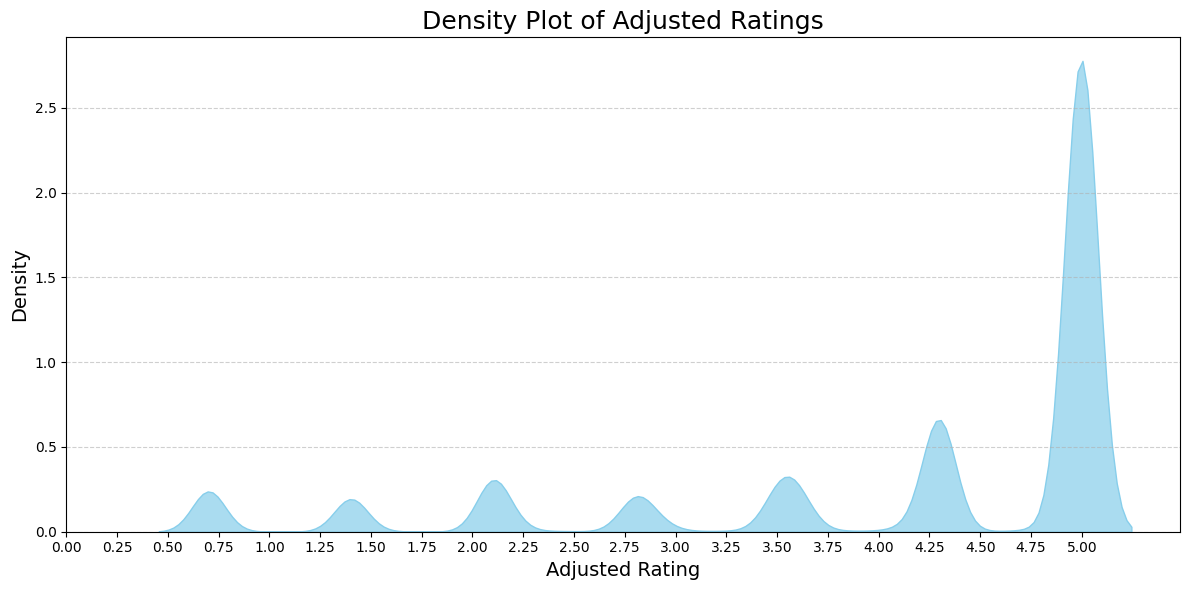

In [28]:
import numpy as np
import seaborn as sns
# Define quarter intervals for the X-axis
x_ticks = np.arange(0, 5.25, 0.25)  # Quarter intervals from 0 to 5

# Create a KDE plot for the adjusted ratings
plt.figure(figsize=(12, 6))
sns.kdeplot(filtered_reviews['adjusted_rating'], fill=True, color="skyblue", alpha=0.7, bw_adjust=0.5)
plt.title("Density Plot of Adjusted Ratings", fontsize=18)
plt.xlabel("Adjusted Rating", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(ticks=x_ticks, labels=[f"{tick:.2f}" for tick in x_ticks])  # Format labels with 2 decimal places
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()  # Adjust layout for clarity
plt.show()



We observe a broader distribution of ratings within the adjusted rating range. This variation arises because reviews with the same original rating may carry either positive or negative sentiment, influencing their corresponding adjusted scores.

##### Meta Data Features



In [29]:
file_path_meta = '/content/drive/My Drive/filtered_meta_update.parquet'

filtered_meta = pd.read_parquet(file_path_meta, engine="pyarrow")


**1. Embedding video game titles**

Instead of the previously used model, we will opt for a more generic model specifically trained on sentences, which aligns well with the nature of video game titles. The SBERT model is particularly suited for this purpose as it is designed to generate meaningful embeddings for sentences or short texts, making it an excellent choice for capturing the essence of game titles.

Game titles often carry nuanced meanings that cannot be effectively represented by integer IDs or traditional categorical encodings. For example, "**FIFA 23**" and "**FIFA 22**" are closely related as they belong to the same game series. By embedding video game titles, we can uncover these subtle relationships, making it a powerful approach for tasks like similarity analysis and recommendation systems.

In [30]:
from sentence_transformers import SentenceTransformer

# Load the SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

filtered_meta['title_embeddings'] = filtered_meta['title'].apply(lambda x: sbert_model.encode(x).tolist())



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [31]:
filtered_meta[["title", "title_embeddings"]].head()

title  \
0                Assassin's Creed IV Black Flag - PC   
1            Mass Effect Andromeda Deluxe - Xbox One   
2      LEGO Batman 2: DC Super Heroes - Nintendo 3DS   
3  Grand Theft Auto V: Premium Edition - Xbox One...   
4  Dead Island Riptide Special Edition - Playstat...   

                                    title_embeddings  
0  [-0.003220567014068365, 0.046798862516880035, ...  
1  [0.0469626821577549, -0.08388175070285797, 0.0...  
2  [-0.07791230827569962, 0.01947767660021782, -0...  
3  [-0.05649198591709137, 0.01896056719124317, -0...  
4  [-0.01736215502023697, -0.014361448585987091, ...

In [32]:
filtered_meta.to_parquet('/content/drive/My Drive/filtered_meta_new.parquet', index=False, engine='pyarrow')

**2.  Parse Bullet Points and Encode Them**

Parsing bullet points in the features column and then encoding them is usful for improving understanding on these features similarity, we would use the [hyp1231/blair-roberta-large](https://huggingface.co/hyp1231/blair-roberta-large) model for creating the embedings.

Due to high comutional complexity we will show implementation of it on a sample of items from the meta data.

In [33]:
sample_meta = filtered_meta.sample(n=16, random_state=42)

In [34]:
def parse_bullet_points(feature_column):
    """
    Parses bullet points stored as strings into individual phrases.
    Expects feature_column as a string representation of a list.
    """
    try:
        parsed_features = eval(feature_column) if isinstance(feature_column, str) else []
        return " ".join(parsed_features)  # Combine all bullet points into one string
    except:
        return ""

sample_meta['parsed_features'] = sample_meta['features'].apply(parse_bullet_points)

In [35]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load Blair-RoBERTa model and tokenizer
model_name = "hyp1231/blair-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [36]:
def generate_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    # Mean pooling for sentence-level embedding
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.squeeze().numpy()


In [37]:
sample_meta['features_embeddings'] = sample_meta['parsed_features'].apply(lambda x: generate_embedding(x, tokenizer, model))


In [38]:
sample_meta[["title", "parsed_features", "features_embeddings"]].head(16)

title  \
180              Medal of Honor Warfighter - Xbox 360   
154                              Homefront - Xbox 360   
111                               Super Mario 3D Land   
247  Lightning Returns: Final Fantasy XIII - Xbox 360   
60              Resident Evil: Revelations - Xbox 360   
9      Dark Souls Collector's Edition - Playstation 3   
119        Witcher 3: Wild Hunt Complete Edition - PC   
157        Uncharted: The Lost Legacy - PlayStation 4   
167          Call of Duty Modern Warfare 2 - Xbox 360   
33                                     Thief Xbox one   
5                 Star Wars Battlefront II - Xbox One   
101           God of War 3 Remastered - PlayStation 4   
45                                 FIFA 14 - Xbox 360   
176          PS3 God of War: Saga Collection - 2 Disc   
118                          Madden NFL 16 - Xbox One   
46               Battlefield Hardline - PlayStation 4   

                                       parsed_features  \
180  Dotted Line to Real World Events - From rescui...   
154  Take the battle online, experiencing large sca...   
111  Mario can perform a rolling somersault attack ...   
247  Your own Lightning - Upgrade Lightning's look,...   
60   Explore the dark, sinister areas of the cruise...   
9    Extremely Deep, Dark & Difficult - Unforgiving...   
119  Play as a highly trained monster slayer for hi...   
157  Critically-acclaimed developer Naughty Dog's s...   
167  Call of Duty: Modern Warfare 2 Video Game for ...   
33   Step into the silent shoes of Garrett, a dark ...   
5    A New Hero, a Story Untold In an emotionally g...   
101  NOW ON THE PS4 SYSTEM Gameplay is beautifully ...   
45   Pure Shot - Shooting has been transformed. Pla...   
176  Includes God of War collections 1 and 2 God of...   
118  Total Control Passing – Place the ball where o...   
46   Cops & Criminals Meet in a World Full of Crime...   

                                   features_embeddings  
180  [-0.021548051, -0.15001392, 0.071955666, 0.076...  
154  [-0.015494926, -0.22249675, 0.21541974, 0.0798...  
111  [0.19317597, -0.10482001, -0.15490244, 0.09079...  
247  [0.14862357, -0.19082357, 0.11471444, 0.056538...  
60   [0.081107736, 0.09785392, -0.061994974, -0.072...  
9    [0.45178214, -0.09340603, -0.03771879, -0.1018...  
119  [0.08007167, 0.012531434, 0.057239052, -0.0235...  
157  [-0.021312717, -0.3112421, -0.013260675, -0.14...  
167  [0.0038972746, 0.07430403, 0.0011392353, 0.126...  
33   [-0.07839687, -0.248418, 0.12079504, -0.008131...  
5    [0.15831858, -0.05569291, -0.058338195, 0.0545...  
101  [-0.096785344, -0.15392123, -0.0085425265, 0.1...  
45   [-0.049414728, -0.36219314, -0.08362347, -0.00...  
176  [0.06742789, -0.031718705, -0.0011543211, 0.04...  
118  [-0.051833384, -0.33889472, -0.108534425, -0.0...  
46   [-0.16703886, -0.37449688, 0.12813015, -0.1950...

In [39]:
file_path_meta = '/content/drive/My Drive/filtered_meta_new2.parquet'

filtered_meta = pd.read_parquet(file_path_meta, engine="pyarrow")

filtered_meta[["title", "parsed_features", "features_embeddings"]].head()

title  \
0                Assassin's Creed IV Black Flag - PC   
1            Mass Effect Andromeda Deluxe - Xbox One   
2      LEGO Batman 2: DC Super Heroes - Nintendo 3DS   
3  Grand Theft Auto V: Premium Edition - Xbox One...   
4  Dead Island Riptide Special Edition - Playstat...   

                                     parsed_features  \
0  A BRASH REBEL ASSASSIN: Become Edward Kenway, ...   
1  Deluxe includes: Pathfinder Casual Outfit, Sca...   
2  Brand New in box. The product ships with all r...   
3  When a young street hustler, a retired bank ro...   
4  Special Edition Includes Alternate Character S...   

                                 features_embeddings  
0  [0.080163315, -0.052779596, 0.05158046, 0.0262...  
1  [0.005770601, -0.24006855, 0.15395077, -0.0382...  
2  [0.05597514, 0.009959414, 0.0060962546, -0.026...  
3  [0.0011726338, -0.17010686, 0.21740168, -0.146...  
4  [-0.0042527495, -0.048563775, 0.08905381, 0.00...

**3. Semantic Embeddings of The Description**

We'll use the pre-trained model [hyp1231/blair-roberta-large](https://huggingface.co/hyp1231/blair-roberta-large) to extract the description embedding for later use to find sementic similarities between the available games.

In [40]:
from transformers import AutoTokenizer, AutoModel
import torch

meta_sample = filtered_meta.sample(n=8, random_state=42)
description_sample = meta_sample['description'].astype(str).tolist()

# Load the tokenizer and model
model_name = "hyp1231/blair-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)



In [41]:
def generate_embeddings(descriptions, tokenizer, model, batch_size=8):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, len(descriptions), batch_size)):
            batch = descriptions[i:i+batch_size]
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=512)
            outputs = model(**inputs)
            # Use the mean pooling of the token embeddings
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).tolist()
            embeddings.extend(batch_embeddings)
    return embeddings

In [42]:
# Generate embeddings for the descriptions
embeddings = generate_embeddings(description_sample, tokenizer, model)

100%|██████████| 1/1 [00:55<00:00, 55.27s/it]


In [43]:
meta_sample['description_embeddings'] = embeddings

meta_sample[["title", "description", "description_embeddings"]].head(8)

title  \
180              Medal of Honor Warfighter - Xbox 360   
154                              Homefront - Xbox 360   
111                               Super Mario 3D Land   
247  Lightning Returns: Final Fantasy XIII - Xbox 360   
60              Resident Evil: Revelations - Xbox 360   
9      Dark Souls Collector's Edition - Playstation 3   
119        Witcher 3: Wild Hunt Complete Edition - PC   
157        Uncharted: The Lost Legacy - PlayStation 4   

                                           description  \
180  ['Product Description', 'Written by active U.S...   
154  ['Product Description', 'The year is 2027. The...   
111  ['Past Mario games have let the blue-suspender...   
247  ["The world of Gran Pulse is sinking into the ...   
60   ["The fear that was originally brought to play...   
9    ['Product Description', "Live Through A Millio...   
119  ['Become a professional monster slayer and emb...   
157  ["From critically acclaimed developers Naughty...   

                                description_embeddings  
180  [0.03788221254944801, 0.021886039525270462, -0...  
154  [0.03772026300430298, 0.09070729464292526, 0.1...  
111  [0.17274148762226105, 0.017782732844352722, -0...  
247  [0.2136760652065277, -0.1768263578414917, -0.0...  
60   [-0.050006527453660965, -0.12176329642534256, ...  
9    [0.0637906938791275, 0.03204667568206787, -0.0...  
119  [0.22108615934848785, 0.004145481623709202, 0....  
157  [-0.11750967800617218, -0.3624679446220398, -0...

In [44]:
file_path_meta = '/content/drive/My Drive/filtered_meta_new3.parquet'

filtered_meta = pd.read_parquet(file_path_meta, engine="pyarrow")

filtered_meta[["title", "description", "description_embeddings"]].head()

title  \
0                Assassin's Creed IV Black Flag - PC   
1            Mass Effect Andromeda Deluxe - Xbox One   
2      LEGO Batman 2: DC Super Heroes - Nintendo 3DS   
3  Grand Theft Auto V: Premium Edition - Xbox One...   
4  Dead Island Riptide Special Edition - Playstat...   

                                         description  \
0  ['From the Manufacturer', "Assassin's Creed", ...   
1  ['Mass Effect: Andromeda pits you and your cre...   
2  ['Product Description', "The Dynamic Duo retur...   
3  ['The Grand Theft Auto V: Premium Edition incl...   
4  ['Product Description', "Dead Island Riptide i...   

                              description_embeddings  
0  [0.09119907021522522, 0.10038165003061295, 0.0...  
1  [-0.017229901626706123, -0.10814885795116425, ...  
2  [0.13787400722503662, 0.01819632761180401, -0....  
3  [0.008390186354517937, -0.030142607167363167, ...  
4  [0.035485804080963135, -0.03860778361558914, 0...

In [45]:
# save the DataFrame as Parquet to Google Drive
filtered_reviews.to_parquet('/content/drive/My Drive/filtered_reviews_with_added_features.parquet', index=False, engine='pyarrow')
filtered_meta.to_parquet('/content/drive/My Drive/filtered_meta_with_added_features.parquet', index=False, engine='pyarrow')

####Final Visual Analysis With Added Features

In [46]:
filtered_meta_path = '/content/drive/My Drive/filtered_meta_with_added_features.parquet'
filtered_reviews_path = '/content/drive/My Drive/filtered_reviews_with_added_features.parquet'

filtered_meta = pd.read_parquet(filtered_meta_path, engine="pyarrow")
filtered_reviews = pd.read_parquet(filtered_reviews_path, engine="pyarrow")

To improve the accuracy and granularity of the sentiment scores in the dataset, I propose redefining the sentiment classification to include **four distinct sentiment categories** instead of the binary "Positive" and "Negative." The goal is to account not only for the decided sentiment but also the decisiveness of the classification, measured by the positive sentiment score.

**Proposed Sentiment Categories:**

1. **Very Positive:** Strongly positive sentiment, with high confidence and likely to align with maximum ratings.

2.  **Somewhat Positive:** Positive sentiment but with some reservations, indicating less decisiveness or mixed feedback.

3.  **Somewhat Negative:** Negative sentiment but not overwhelmingly so, suggesting a mix of drawbacks and positives.

4.  **Very Negative:** Strongly negative sentiment, with high confidence and likely to align with minimum ratings.

Reviews with scores near the threshold boundaries will help differentiate decisive opinions from more mixed feedback, allowing us to gain a clearer understanding of user sentiment.

This refinement enables us to have better alignment between sentiment and ratings by capturing nuances in user feedback. And improved classification that highlights drawbacks in mostly positive reviews or redeeming qualities in mostly negative reviews.

In [47]:

# Define sentiment categories
def classify_sentiment(row):
    positive_sentiment_score = row['positive_sentiment_prob']
    sentiment = row['predicted_sentiment']

    if sentiment == 'Positive':
        if positive_sentiment_score > 0.99:
            return "Very Positive"
        else:
            return "Somewhat Positive"
    elif sentiment == 'Negative':
        if positive_sentiment_score < 0.01:
            return "Very Negative"
        else:
            return "Somewhat Negative"

filtered_reviews['sentiment_category'] = filtered_reviews.apply(classify_sentiment, axis=1)



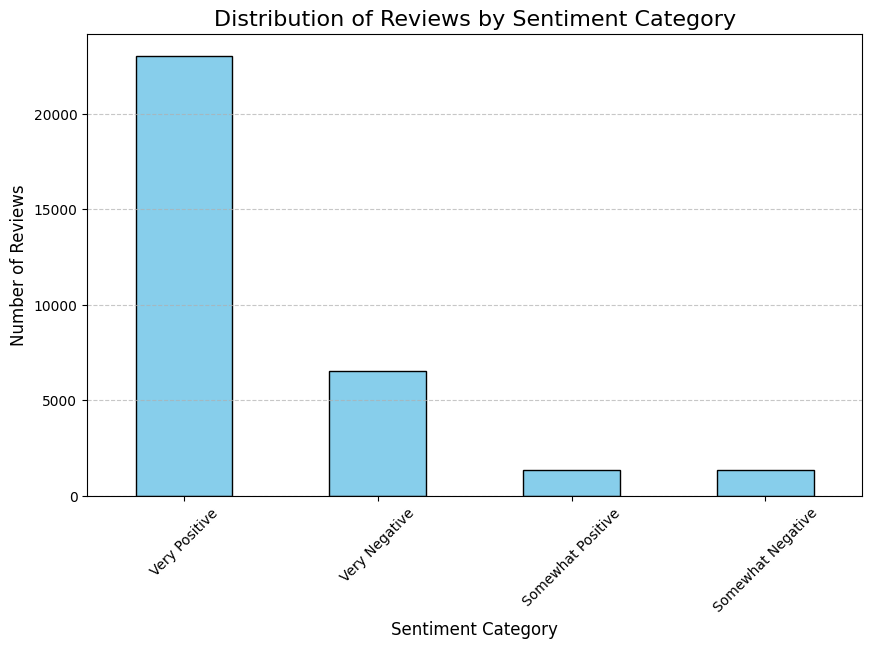

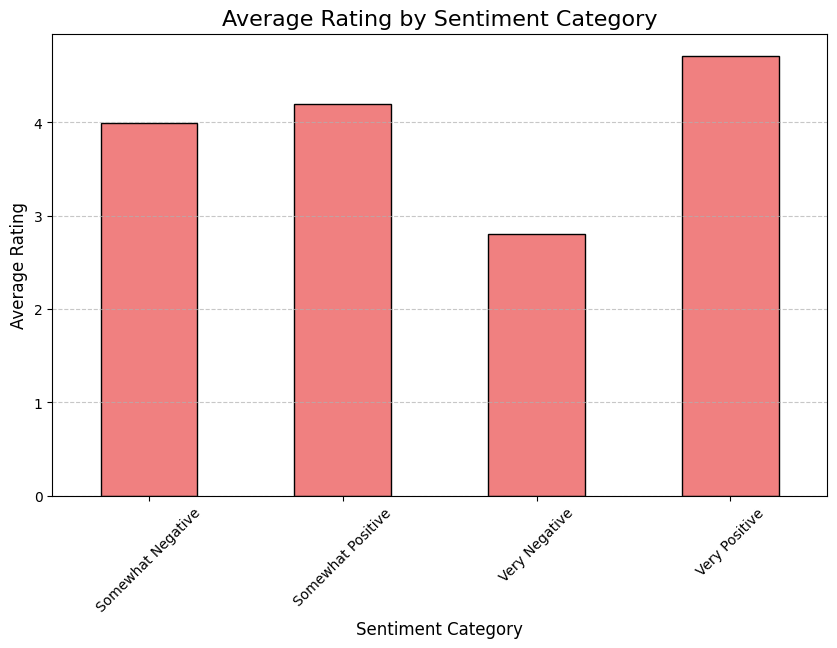

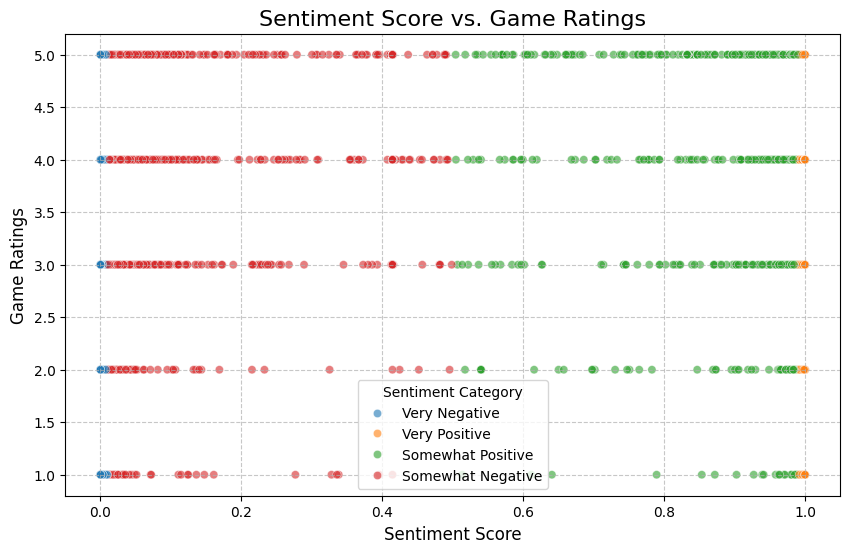

In [48]:
# Count the number of reviews in each sentiment category
sentiment_distribution = filtered_reviews['sentiment_category'].value_counts()

# Bar plot for sentiment category distribution
plt.figure(figsize=(10, 6))
sentiment_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Reviews by Sentiment Category', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Group by sentiment category and calculate average rating
sentiment_rating = filtered_reviews.groupby('sentiment_category')['rating'].mean()

# Bar chart for sentiment category vs. average rating
plt.figure(figsize=(10, 6))
sentiment_rating.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Average Rating by Sentiment Category', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Scatter plot: sentiment score vs. rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x=filtered_reviews['positive_sentiment_prob'], y=filtered_reviews['rating'], hue=filtered_reviews['sentiment_category'], alpha=0.6)
plt.title('Sentiment Score vs. Game Ratings', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Game Ratings', fontsize=12)
plt.legend(title='Sentiment Category')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


After generating the visualizations, we conduct Spearman's Rank Correlation test to statistically validate the relationship between sentiment scores and user ratings.

In [49]:
import scipy.stats as stats

# Extract ratings for each sentiment category
very_positive_ratings = filtered_reviews[filtered_reviews['sentiment_category'] == 'Very Positive']['rating']
somewhat_positive_ratings = filtered_reviews[filtered_reviews['sentiment_category'] == 'Somewhat Positive']['rating']
somewhat_negative_ratings = filtered_reviews[filtered_reviews['sentiment_category'] == 'Somewhat Negative']['rating']
very_negative_ratings = filtered_reviews[filtered_reviews['sentiment_category'] == 'Very Negative']['rating']

# Spearman correlation between sentiment score and rating
spearman_corr, spearman_p = stats.spearmanr(filtered_reviews['positive_sentiment_prob'], filtered_reviews['rating'])
print(f"Spearman Correlation: ρ = {spearman_corr:.3f}, p-value = {spearman_p:.5f}")


Spearman Correlation: ρ = 0.552, p-value = 0.00000


**The Results:**

Spearman Correlation: ρ = **0.552**, p-value = **0.00000**

*  The positive correlation (ρ = 0.552) suggests a moderate-to-strong monotonic relationship between sentiment score and rating.

*  The p-value < 0.00001 confirms that this relationship is statistically significant, meaning the observed trend is unlikely due to random chance.

**Interpretation & Insights:**

Sentiment categories align well with expectations:

*  Very Positive reviews are associated with the highest average ratings.

*  Very Negative reviews correspond to significantly lower average ratings.

*  Somewhat Positive & Somewhat Negative reviews fall in between, reflecting a gradual sentiment influence.

**Statistical validation**: The Spearman correlation test reinforces our visual observations, providing a numerical measure of the strength of the relationship between sentiment score and rating.

However, anomalies are evident in the data. For instance, there are cases where Very Negative sentiment is paired with a perfect rating of 5, and similarly, Somewhat Positive sentiment appears with lower ratings. These outliers suggest a disconnect between textual sentiment and numerical ratings, warranting further investigation to uncover potential reasons behind these inconsistencies. This analysis could help refine the sentiment classification model and identify patterns specific to user behavior or review contexts.

In [50]:
inconsistent_positive_reviews = filtered_reviews[(filtered_reviews['sentiment_category'] == 'Very Negative')
 & (filtered_reviews['rating'] == 5)]
inconsistent_negative_reviews = filtered_reviews[(filtered_reviews['sentiment_category'] == 'Very Positive')
 & (filtered_reviews['rating'] == 1)]


In [51]:
print (inconsistent_positive_reviews.iloc[0]['text'])

The negative reviews for this game are kind of an exaggeration so let me try to address the main complaints.<br /><br />First negative thing you will hear is that the animations and facial expressions are horrible. Well they are kind of right about that. You see right ofits  the bat on the default Ryder both male and female and they look kind of ugly, especially the default female Ryder who looks like she had too many botox injections... Well thank god for character creator, otherwise you would be cringing the entire game. There is even a form on reddit to help you make a good looking Ryder, granted I made my own and he doesn't look that bad. Just play with the character creator and you can get an attractive Ryder.<br /><br />The voices do the job, nothing spectacular like previous titles but not as horrible as that biker game that shall not be named. They sound like normal people. Though you can hear this werid filter voices from like the krogens or the turians... yes they did sound l

In [52]:
print(inconsistent_negative_reviews.iloc[0]['text'])

So here is the review after playing for 28 hours.<br /><br />Let’s start and say Fallout and Fallout 2 was and will be my favorite games of all time (now I can add Witcher 3 to that list)<br /><br />I did not like Fallout 3 for lack of being Fallout and being Oblivion with guns, but I enjoyed Fallout New Vegas a lot.<br /><br />I love TES series, but it’s not TES series we will be talking about here.<br /><br />Character System:<br /><br />We don’t have skill anymore just perks.<br />The SPECIAL system became even more casual then Fallout 3.<br /><br />Combat:<br /><br />It not interesting and very outdated.<br />Combat stopped being tactical.<br />Super mutants don’t feel threatening at all. I play on hard.<br /><br />Dialogue system:<br /><br />There is no need to invest points into speech (there is not speech skill). Dialogue has only 4 options.<br />1) Yes<br />2) No<br />3) Question?<br />4) Sarcasm<br /><br />There is no writing involved. Dialogues are not fun. You dot need to us

These two reviews illustrate a critical challenge in accurately identifying sentiment in user text, especially within the context of limited computational resources for processing large amounts of text.

The first review is clearly **positive** in nature, as the writer supports playing the game and provides counterarguments to negative feedback from other players. However, because the text focuses heavily on addressing and validating the negative aspects of the game before presenting positive arguments, the model incorrectly categorizes it as **"Very Negative"**. This misclassification arises because the model struggles to understand the reviewer’s intent: to confront and refute the negative points raised by others.

Conversely, the second review is clearly **negative** in sentiment. The writer emphasizes dissatisfaction with the game and extensively compares it to previous franchise installments, highlighting how earlier games excelled where this one falls short. Despite this strong negative tone, the review occasionally acknowledges positive features as comparison points, which could confuse a sentiment analysis model into interpreting it as partially positive.

These two reviews, with their contradictory scores and sentiment classifications, exemplify a common issue in sentiment analysis: the challenge of identifying the true semantic intent behind a review.

Because of that, we need to incorporating more robust techniques to analyze intent rather than relying solely on word-level or sentence-level sentiment.

Next Step: Exploring Added Embeddings

To uncover deeper insights, we will focus on the embeddings added to our dataset. These embeddings encode semantic and contextual relationships in a high-dimensional space, allowing us to visualize and analyze hidden patterns. The following embeddings are available:

* *title_and_text_embeddings* : Captures context from the review titles and text.

* *features_embeddings* : Encodes semantic information from the game's features.

* *description_embeddings* : Encodes details from the game's description.

* *title_embeddings* : Encodes information about the game's title.

Plan of Action:

1. **Dimensionality Reduction**: Use PCA, t-SNE, or UMAP to project these high-dimensional embeddings into 2D or 3D spaces for visualization.

2. **Visualization**: Cluster similar games or reviews to see how well embeddings group them.
Compare sentiment trends or user behavior with the reduced embeddings.

3. **Analysis**: Identify patterns, clusters, or outliers in the embeddings.

**title_and_text_embeddings :**

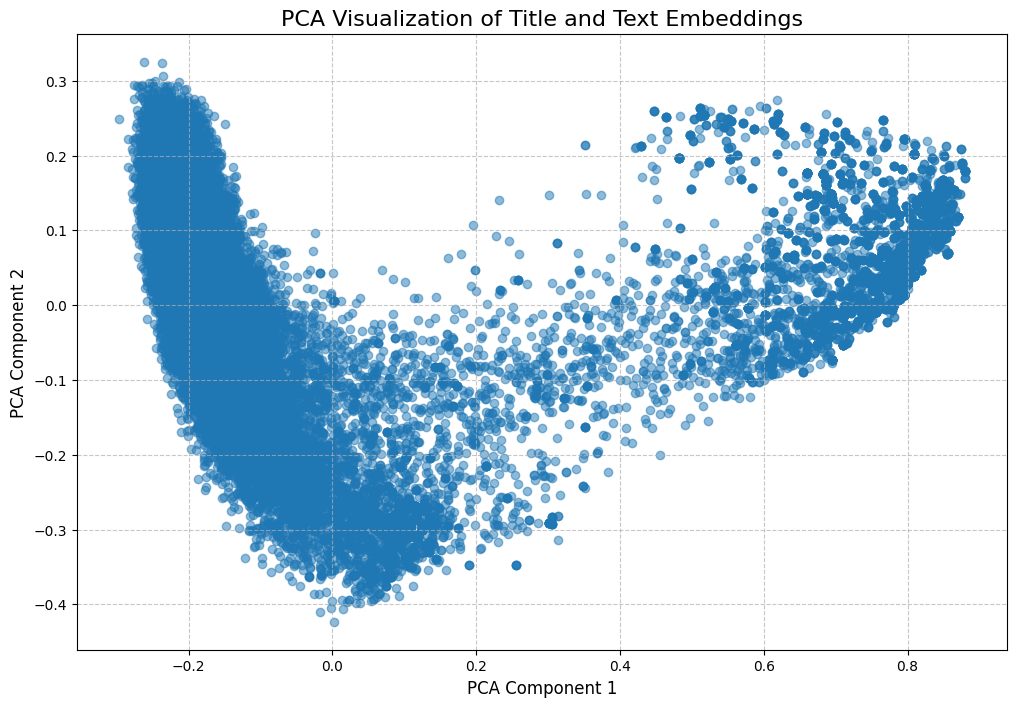

In [53]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


embeddings = np.stack(filtered_reviews['title_and_text_embeddings'])

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Add PCA results to the DataFrame
filtered_reviews['pca_1'] = reduced_embeddings[:, 0]
filtered_reviews['pca_2'] = reduced_embeddings[:, 1]

# Visualize the reduced embeddings
plt.figure(figsize=(12, 8))
plt.scatter(filtered_reviews['pca_1'], filtered_reviews['pca_2'], alpha=0.5)
plt.title('PCA Visualization of Title and Text Embeddings', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


From this visualization with 2 PCA components, there is a clear dense cluster on the left and a more spread-out structure on the right. This may indicate reviews with similar semantics are grouped closer together in the embedding space.

Because of that we will want to assign sentiment labels to the points (e.g., "Very Positive," "Negative") and color them in the plot to see if sentiment aligns with the clusters.

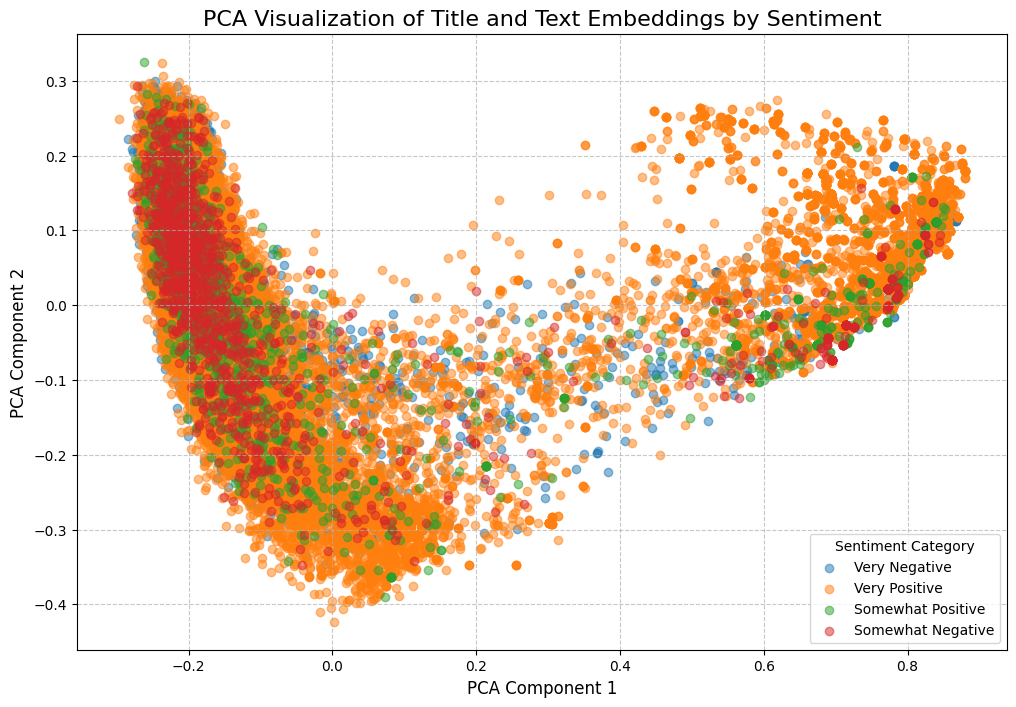

In [54]:
# Scatter plot with sentiment category coloring
plt.figure(figsize=(12, 8))
for sentiment in filtered_reviews['sentiment_category'].unique():
    subset = filtered_reviews[filtered_reviews['sentiment_category'] == sentiment]
    plt.scatter(subset['pca_1'], subset['pca_2'], label=sentiment, alpha=0.5)

plt.title('PCA Visualization of Title and Text Embeddings by Sentiment', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Sentiment Category', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


PCA captures clear clusters of sentiment, with highly polarized sentiments like "Very Positive" and "Very Negative" forming separate regions, and the more in-the-middle sentiments tend to overlap more.

Lets preform clustring with K-means on the PCA components to indentify distinct groups.

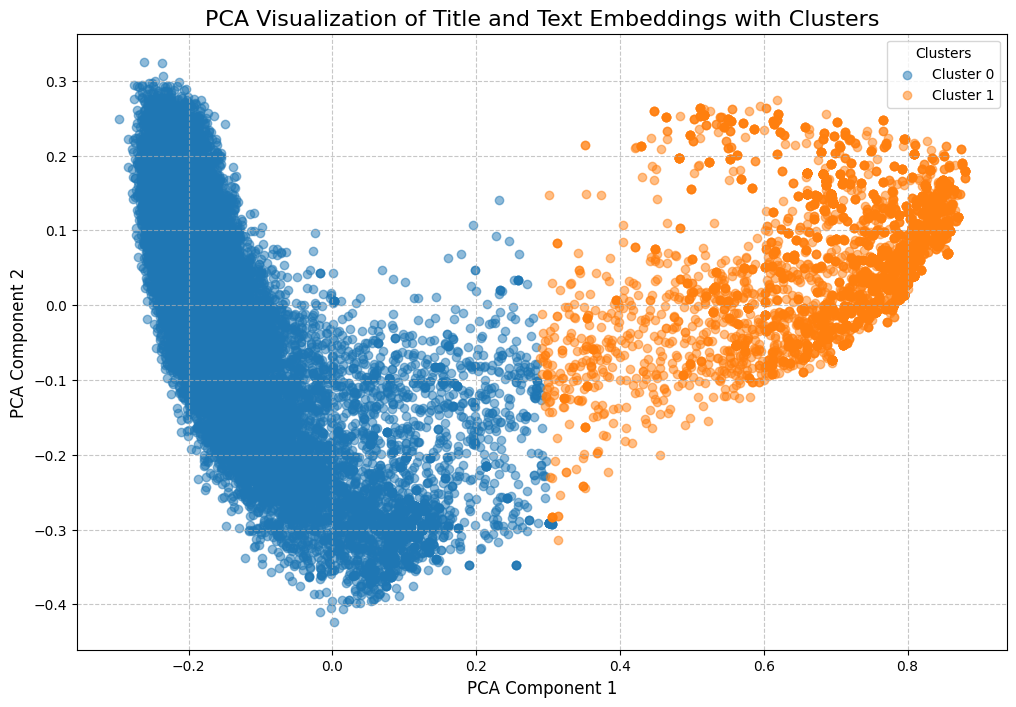

In [55]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


num_clusters = 2

# Apply K-Means clustering to PCA components
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
filtered_reviews['cluster'] = kmeans.fit_predict(filtered_reviews[['pca_1', 'pca_2']])

# Visualize clusters
plt.figure(figsize=(12, 8))
for cluster in range(num_clusters):
    subset = filtered_reviews[filtered_reviews['cluster'] == cluster]
    plt.scatter(subset['pca_1'], subset['pca_2'], label=f'Cluster {cluster}', alpha=0.5)

plt.title('PCA Visualization of Title and Text Embeddings with Clusters', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Clusters', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Thats a clear seperation but lets increase it to 4 groups that suit more of our 4 possible sentiment groups.

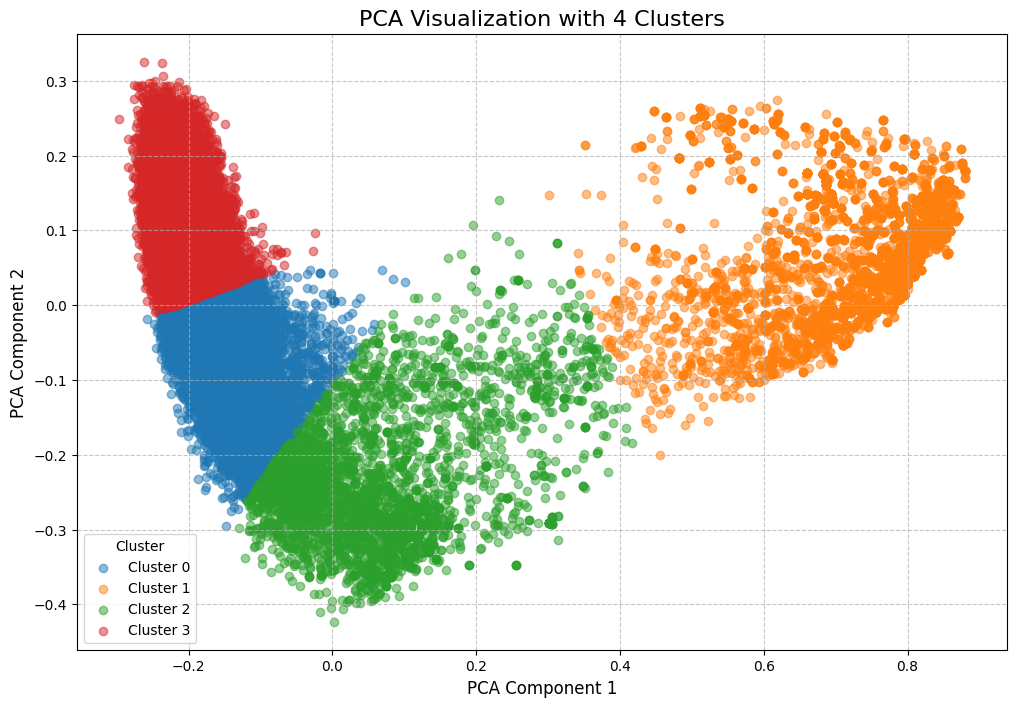

In [56]:
# Apply K-Means for 4 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=42)
filtered_reviews['title_and_text_cluster'] = kmeans_4.fit_predict(filtered_reviews[['pca_1', 'pca_2']])

# Visualization for 4 Clusters
plt.figure(figsize=(12, 8))
for cluster in range(4):
    subset = filtered_reviews[filtered_reviews['title_and_text_cluster'] == cluster]
    plt.scatter(subset['pca_1'], subset['pca_2'], label=f'Cluster {cluster}', alpha=0.5)
plt.title('PCA Visualization with 4 Clusters', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Cluster', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [57]:
cluster_sentiment_summary = filtered_reviews.groupby('title_and_text_cluster')['positive_sentiment_prob'].mean()
print(cluster_sentiment_summary)


title_and_text_cluster
0    0.735453
1    0.927772
2    0.873808
3    0.665995
Name: positive_sentiment_prob, dtype: float64


From this we see The clusters are naturally ordered by increasing positive sentiment probability, showing that the PCA components and K-means clustering capture a meaningful semantic progression.

Cluster 3 is most likely representing more critical and generally negative reviews in comparrision to the others.

Cluster 1 represents highly positive reviews, potentially with enthusiastic or overwhelmingly positive language.

Clusters 0 and 2 likely represent intermediate groups, balancing positive and neutral/mixed feedback.

Now we will observe the actual ratings and see if the trend alligns:

In [58]:
cluster_rating_summary = filtered_reviews.groupby('title_and_text_cluster')['rating'].mean()
print(cluster_rating_summary)


title_and_text_cluster
0    4.186492
1    4.800746
2    4.562060
3    4.039435
Name: rating, dtype: float64


Cluster 1 has the highest average rating, consistent with its high positive sentiment (0.927772).

Cluster 3 has the lowest average rating and aligns with the lowest sentiment probability (0.665595).

Cluster 2 has a moderately high rating and aligns with its sentiment probability (0.873088).

Cluster 0 has a more moderate rating, reflecting its intermediate sentiment probability (0.735453).

Next, we apply statistical tests to verify the alignment of our findings with the data.

In [59]:
import scipy.stats as stats

# Kruskal-Wallis test for sentiment probability across clusters
kruskal_sentiment = stats.kruskal(
    filtered_reviews[filtered_reviews['title_and_text_cluster'] == 0]['positive_sentiment_prob'],
    filtered_reviews[filtered_reviews['title_and_text_cluster'] == 1]['positive_sentiment_prob'],
    filtered_reviews[filtered_reviews['title_and_text_cluster'] == 2]['positive_sentiment_prob'],
    filtered_reviews[filtered_reviews['title_and_text_cluster'] == 3]['positive_sentiment_prob']
)

# Kruskal-Wallis test for rating across clusters
kruskal_rating = stats.kruskal(
    filtered_reviews[filtered_reviews['title_and_text_cluster'] == 0]['rating'],
    filtered_reviews[filtered_reviews['title_and_text_cluster'] == 1]['rating'],
    filtered_reviews[filtered_reviews['title_and_text_cluster'] == 2]['rating'],
    filtered_reviews[filtered_reviews['title_and_text_cluster'] == 3]['rating']
)


print(f"Kruskal-Wallis Test for Sentiment: H = {kruskal_sentiment.statistic:.3f}, p-value = {kruskal_sentiment.pvalue:.5f}")
print(f"Kruskal-Wallis Test for Ratings: H = {kruskal_rating.statistic:.3f}, p-value = {kruskal_rating.pvalue:.5f}")


Kruskal-Wallis Test for Sentiment: H = 459.803, p-value = 0.00000
Kruskal-Wallis Test for Ratings: H = 2594.444, p-value = 0.00000


From these results, we conclude that:

1.  Significant Differences in Both Sentiment and Rating:
  
  *  Since p-values are < 0.00001, we reject the null hypothesis (H₀) for both sentiment and rating distributions.
  
  *  This confirms that at least one cluster differs significantly in both sentiment and rating.

2.  Ratings Show Much Stronger Separation than Sentiment:
  
  *  The H-value for sentiment is ~460, while for ratings, it is ~2600.
  
  *  This indicates that while clusters capture meaningful and statistically significant differences in both sentiment and ratings, the separation is much more pronounced for ratings.

In conclusion, there is a clear alignment between sentiment probabilities and average ratings. Clusters with higher sentiment probabilities also tend to have higher ratings, indicating that the embeddings capture meaningful patterns in review sentiment. Furthermore, statistical analysis confirms that the identified clusters provide a strong and reliable separation, making them suitable for further use.

In [60]:
filtered_reviews.drop(columns=['cluster'], inplace=True)

**features_embeddings :**

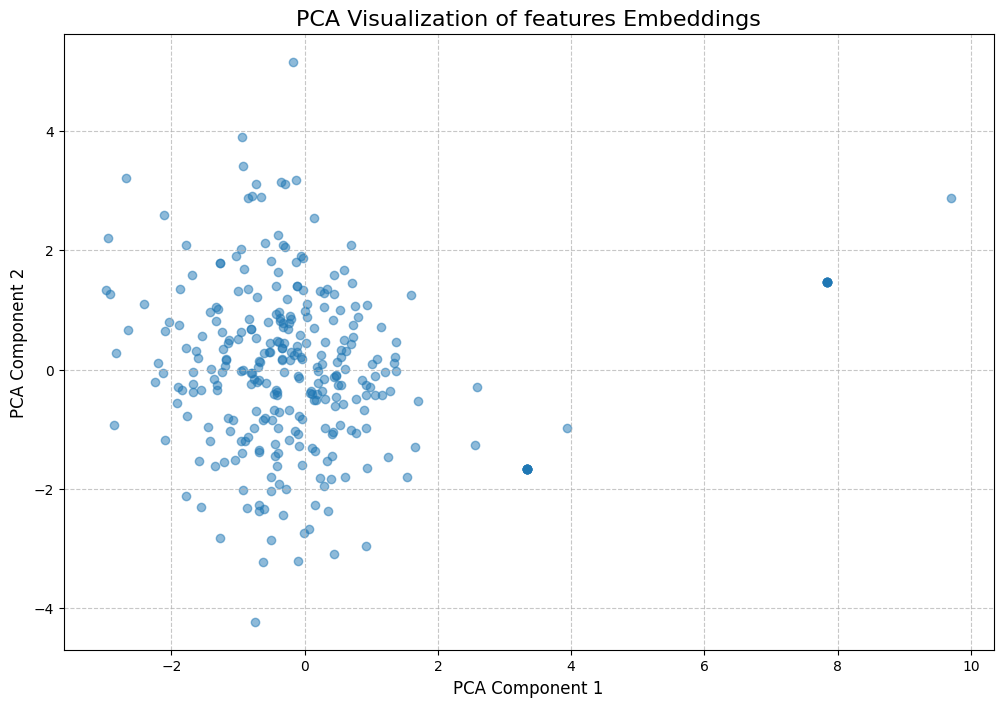

In [61]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

embeddings = np.stack(filtered_meta['features_embeddings'])

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Add PCA results to the DataFrame
filtered_meta['pca_1'] = reduced_embeddings[:, 0]
filtered_meta['pca_2'] = reduced_embeddings[:, 1]

# Visualize the reduced embeddings
plt.figure(figsize=(12, 8))
plt.scatter(filtered_meta['pca_1'], filtered_meta['pca_2'], alpha=0.5)
plt.title('PCA Visualization of features Embeddings', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Because of the small size of this dataset relative to the reviews (only 304 games to take into account) we could use more computational heavy approch that will handle nonlinier relatiosnips better such as t-SNE and UMAP.

In [62]:
!pip install umap-learn


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


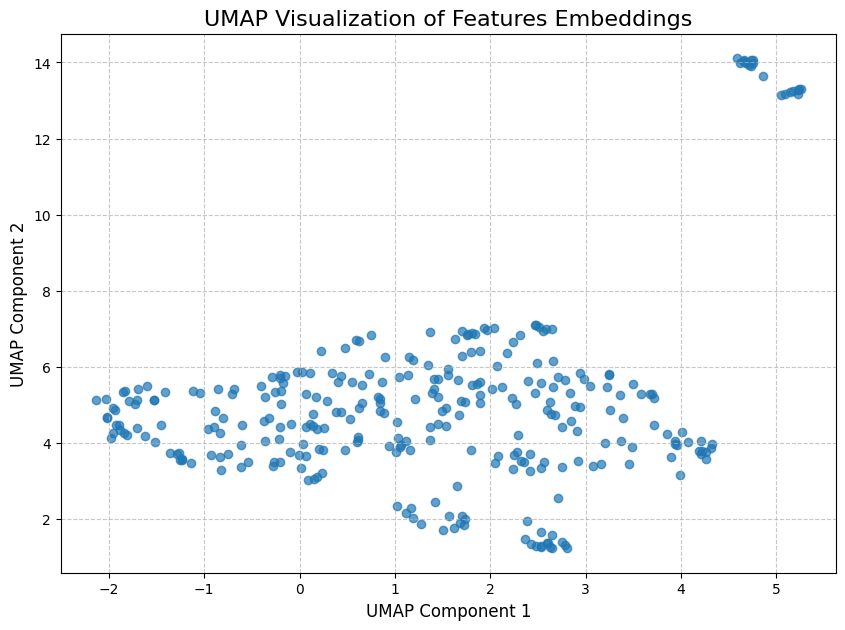

In [63]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Apply UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Add UMAP results to DataFrame
filtered_meta['umap_1'] = umap_embeddings[:, 0]
filtered_meta['umap_2'] = umap_embeddings[:, 1]

# Plot UMAP results
plt.figure(figsize=(10, 7))
plt.scatter(filtered_meta['umap_1'], filtered_meta['umap_2'], alpha=0.7)
plt.title('UMAP Visualization of Features Embeddings', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


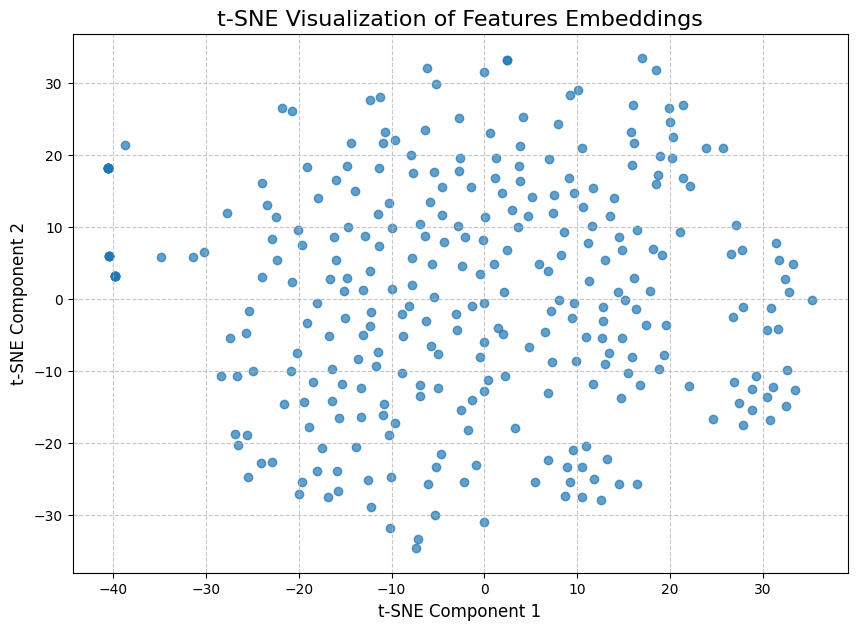

In [64]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embeddings = tsne_model.fit_transform(embeddings)

# Add t-SNE results to DataFrame
filtered_meta['tsne_1'] = tsne_embeddings[:, 0]
filtered_meta['tsne_2'] = tsne_embeddings[:, 1]

# Plot t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(filtered_meta['tsne_1'], filtered_meta['tsne_2'], alpha=0.7)
plt.title('t-SNE Visualization of Features Embeddings', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Our PCA visualization shows that most of the points are clusterd in one dense region with a few outliner scattered farther away, potentially representing embeddings that are significantly different from the rest.

The UMAP visualization on the other hand shows a clear group of embeddings thats separated in the top-right corner, indicating a distinct cluster. With the remaining points spread horizontally, showing some variation in the structure.

And thet t-SNE visualization showing the points spread more uniformly, without obvious clusters or separations.

Additionally we will add statistical tests to help our decision on what method to choose:

In [65]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import f_oneway
from scipy.spatial.distance import pdist
import numpy as np

# Extract embeddings
pca_embeddings = filtered_meta[['pca_1', 'pca_2']].values
tsne_embeddings = filtered_meta[['tsne_1', 'tsne_2']].values
umap_embeddings = filtered_meta[['umap_1', 'umap_2']].values

# Define number of clusters
num_clusters = 3

# Apply K-Means clustering to each embedding type
kmeans_pca = KMeans(n_clusters=num_clusters, random_state=42).fit(pca_embeddings)
kmeans_tsne = KMeans(n_clusters=num_clusters, random_state=42).fit(tsne_embeddings)
kmeans_umap = KMeans(n_clusters=num_clusters, random_state=42).fit(umap_embeddings)

# Extract cluster labels
labels_pca = kmeans_pca.labels_
labels_tsne = kmeans_tsne.labels_
labels_umap = kmeans_umap.labels_

# Compute clustering quality metrics
metrics = {
    'PCA': {
        'Silhouette Score': silhouette_score(pca_embeddings, labels_pca),
        'Calinski-Harabasz Index': calinski_harabasz_score(pca_embeddings, labels_pca),
        'Davies-Bouldin Index': davies_bouldin_score(pca_embeddings, labels_pca),
    },
    't-SNE': {
        'Silhouette Score': silhouette_score(tsne_embeddings, labels_tsne),
        'Calinski-Harabasz Index': calinski_harabasz_score(tsne_embeddings, labels_tsne),
        'Davies-Bouldin Index': davies_bouldin_score(tsne_embeddings, labels_tsne),
    },
    'UMAP': {
        'Silhouette Score': silhouette_score(umap_embeddings, labels_umap),
        'Calinski-Harabasz Index': calinski_harabasz_score(umap_embeddings, labels_umap),
        'Davies-Bouldin Index': davies_bouldin_score(umap_embeddings, labels_umap),
    }
}

# Pairwise Euclidean Distance Analysis
pca_distances = pdist(pca_embeddings)
tsne_distances = pdist(tsne_embeddings)
umap_distances = pdist(umap_embeddings)

# Display Results
print("Dimensionality Reduction Performance Metrics:")
for method, values in metrics.items():
    print(f"\n{method}:")
    for metric, score in values.items():
        print(f"  {metric}: {score:.4f}")



Dimensionality Reduction Performance Metrics:

PCA:
  Silhouette Score: 0.3617
  Calinski-Harabasz Index: 236.9269
  Davies-Bouldin Index: 0.7957

t-SNE:
  Silhouette Score: 0.3658
  Calinski-Harabasz Index: 224.5422
  Davies-Bouldin Index: 0.8947

UMAP:
  Silhouette Score: 0.4242
  Calinski-Harabasz Index: 475.8643
  Davies-Bouldin Index: 0.7456


The statistical analysis confirms that UMAP is the optimal dimensionality reduction method for feature embeddings. UMAP achieves the highest Silhouette Score (**0.4242**), the best cluster compactness (Calinski-Harabasz Index: **475.86**), and the lowest Davies-Bouldin Index (**0.7456**), indicating stronger cluster separation and lower overlap compared to PCA and t-SNE.

Based on these results, UMAP is the best choice for clustering and recommendation tasks, providing clearer, more interpretable groupings.

Well start with k-MEANS clustring and for that we will want to find out what n_clusters should be:

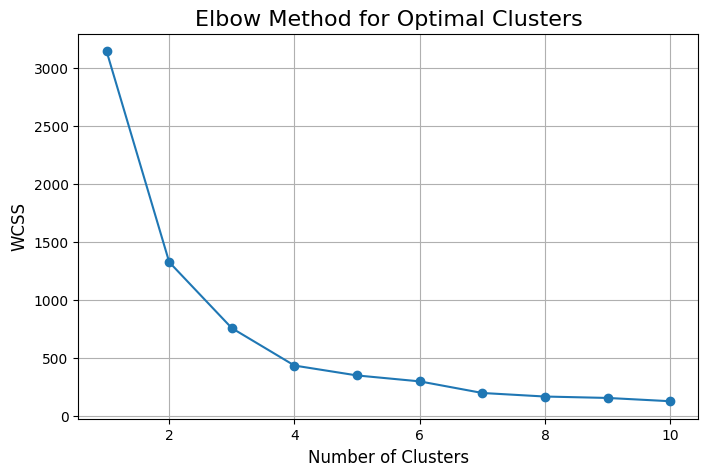

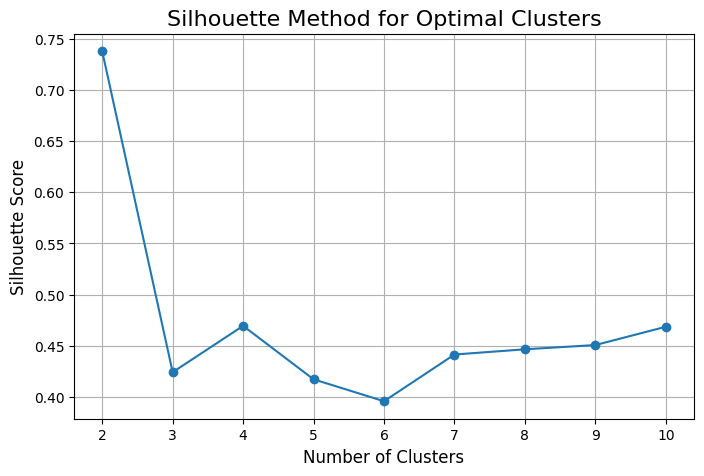

In [66]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Calculate WCSS for different numbers of clusters
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(umap_embeddings)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
plt.grid(True)
plt.show()

# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(umap_embeddings)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(umap_embeddings, labels))

# Plot the Silhouette Method
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Method for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True)
plt.show()

Based on the elbow method 3 clusters seems to be the elbow point and while the silhouette score for 2 clusters is clearly the highest the drop to 3 is understandable based on the structure and not too large for it to be problematic, therfore we will select 3 clusters.

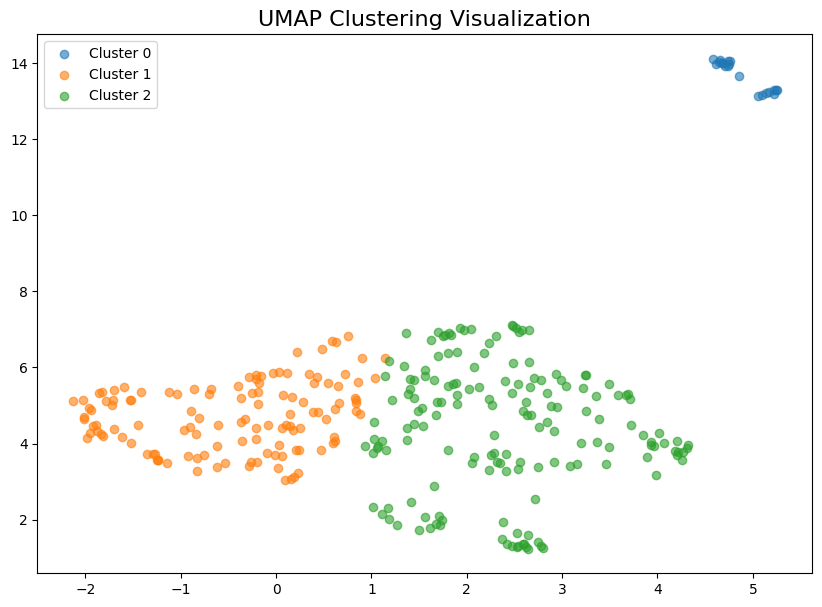

In [67]:
from sklearn.cluster import KMeans

# Perform clustering on UMAP embeddings
kmeans = KMeans(n_clusters=3, random_state=42)
filtered_meta['features_cluster'] = kmeans.fit_predict(umap_embeddings)

# Visualize clusters
plt.figure(figsize=(10, 7))
for cluster in range(3):
    subset = filtered_meta[filtered_meta['features_cluster'] == cluster]
    plt.scatter(subset['umap_1'], subset['umap_2'], label=f'Cluster {cluster}', alpha=0.6)
plt.title('UMAP Clustering Visualization', fontsize=16)
plt.legend()
plt.show()


In [68]:
import plotly.express as px
import pandas as pd

# Prepare data for Plotly
filtered_meta['features_cluster'] = kmeans.labels_

# Create a Plotly scatter plot
fig = px.scatter(
    filtered_meta,
    x='umap_1',
    y='umap_2',
    color='features_cluster',
    title='Interactive K-MEANS Clustering Visualization',
    labels={'umap_1': 'UMAP Component 1', 'umap_2': 'UMAP Component 2', 'features_cluster': 'Cluster'},
    hover_data=['title', 'average_rating'],
    color_discrete_sequence=px.colors.qualitative.Set1
)

fig.update_layout(
    title_font_size=20,
    legend_title_text='Cluster',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()


In [69]:
# Summary statistics for each cluster
cluster_summary = filtered_meta.groupby('features_cluster').agg({
    'average_rating': ['mean', 'std'],
    'rating_number': ['mean', 'std'],
    'price_numeric': ['mean', 'std'],
    'Category_Group': lambda x: x.value_counts().idxmax()
})

cluster_summary.head()


average_rating           rating_number               \
                           mean       std          mean          std   
features_cluster                                                       
0                      4.375000  0.456387   1250.200000  1263.346167   
1                      4.409756  0.271128   1254.048780  1639.295685   
2                      4.499379  0.232244   1658.652174  2833.964393   

                 price_numeric                  Category_Group  
                          mean        std             <lambda>  
features_cluster                                                
0                    36.750500  17.867310         Xbox Systems  
1                    35.765447  57.968758  PlayStation Systems  
2                    48.746087  69.416056  PlayStation Systems

In [70]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.stats import permutation_test

# Extract embeddings and cluster labels
umap_embeddings = filtered_meta[['umap_1', 'umap_2']].values
cluster_labels = filtered_meta['features_cluster']

# Compute cluster quality metrics
silhouette = silhouette_score(umap_embeddings, cluster_labels)
davies_bouldin = davies_bouldin_score(umap_embeddings, cluster_labels)

# Permutation test for cluster stability
perm_test = permutation_test(
    (cluster_labels,), lambda labels: silhouette_score(umap_embeddings, labels),
    permutation_type='pairings', alternative='greater',
    random_state=42
)

# Print final results
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"Permutation Test p-value: {perm_test.pvalue:.4f}")


Silhouette Score: 0.4242
Davies-Bouldin Index: 0.7456
Permutation Test p-value: 0.0001


Our clustering analysis, based on UMAP and K-Means, reveals three distinct groups of games with meaningful differences in rating, popularity, and pricing.

- **Cluster 2** consists of the most highly rated and frequently reviewed games, suggesting they are premium-quality and widely popular.

- **Cluster 0** has the lowest average rating and review count, indicating a niche or less engaging selection.

- **Cluster 1** falls in between.

Statistical validation confirms the robustness of these clusters, with a Silhouette Score of **0.4242**, indicating moderate-to-strong separation, and a Davies-Bouldin Index of **0.7456**, reflecting well-defined, compact groups. The permutation test p-value of **0.0001** provides strong evidence that the clusters are statistically significant and not formed randomly, reinforcing that UMAP successfully captured meaningful relationships in the feature space.

From these observations, we can conclude that Cluster 2 consists of more premium-quality games compared to Cluster 0, with Cluster 1 falling somewhere in between

**description_embeddings:**

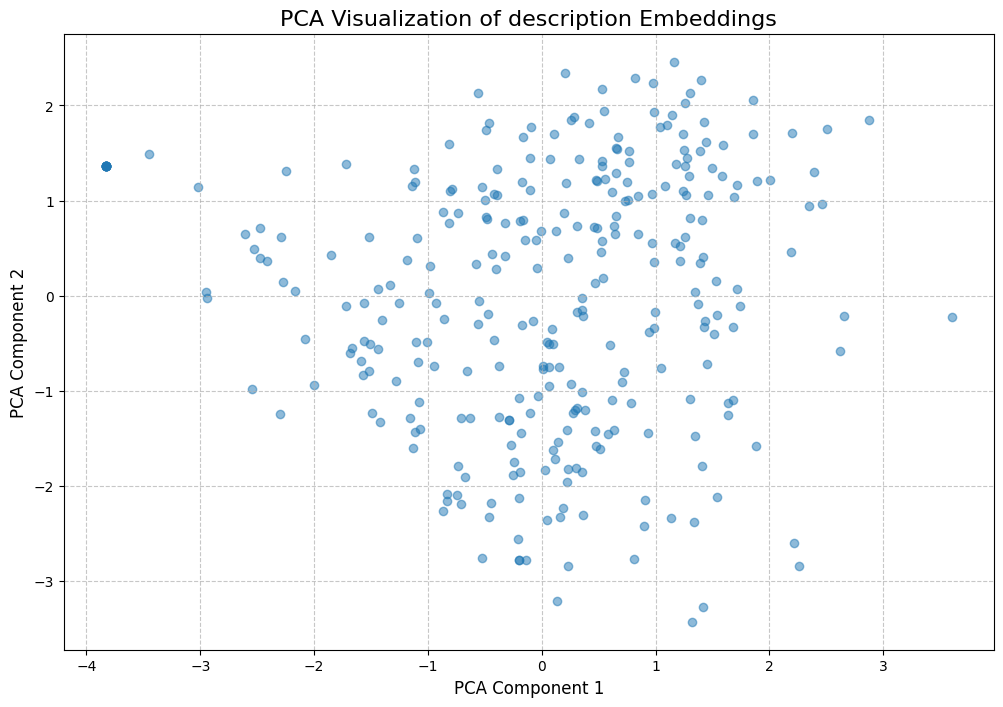

In [71]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

embeddings = np.stack(filtered_meta['description_embeddings'])

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Add PCA results to the DataFrame
filtered_meta['pca_1'] = reduced_embeddings[:, 0]
filtered_meta['pca_2'] = reduced_embeddings[:, 1]

# Visualize the reduced embeddings
plt.figure(figsize=(12, 8))
plt.scatter(filtered_meta['pca_1'], filtered_meta['pca_2'], alpha=0.5)
plt.title('PCA Visualization of description Embeddings', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



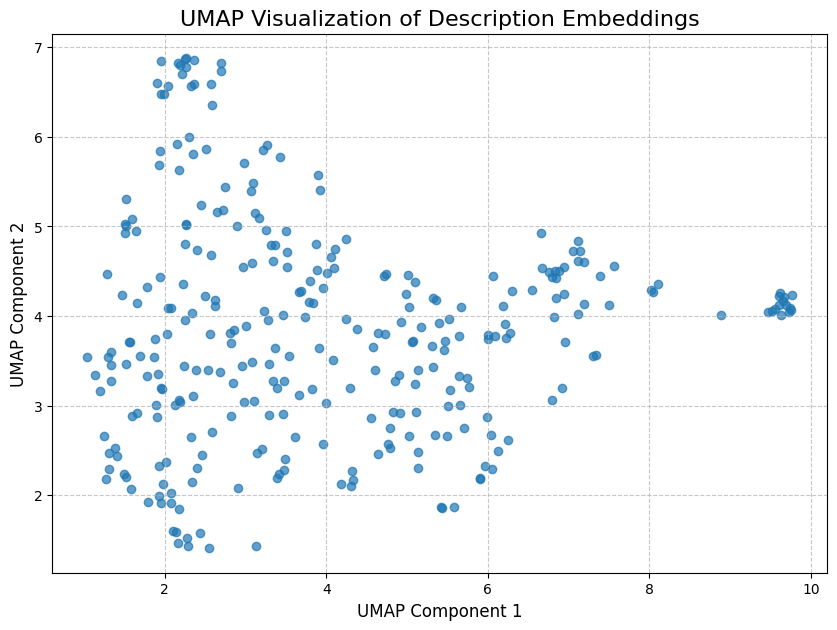

In [72]:
import umap.umap_ as umap
import matplotlib.pyplot as plt


# Apply UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Add UMAP results to DataFrame
filtered_meta['umap_1'] = umap_embeddings[:, 0]
filtered_meta['umap_2'] = umap_embeddings[:, 1]

# Plot UMAP results
plt.figure(figsize=(10, 7))
plt.scatter(filtered_meta['umap_1'], filtered_meta['umap_2'], alpha=0.7)
plt.title('UMAP Visualization of Description Embeddings', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

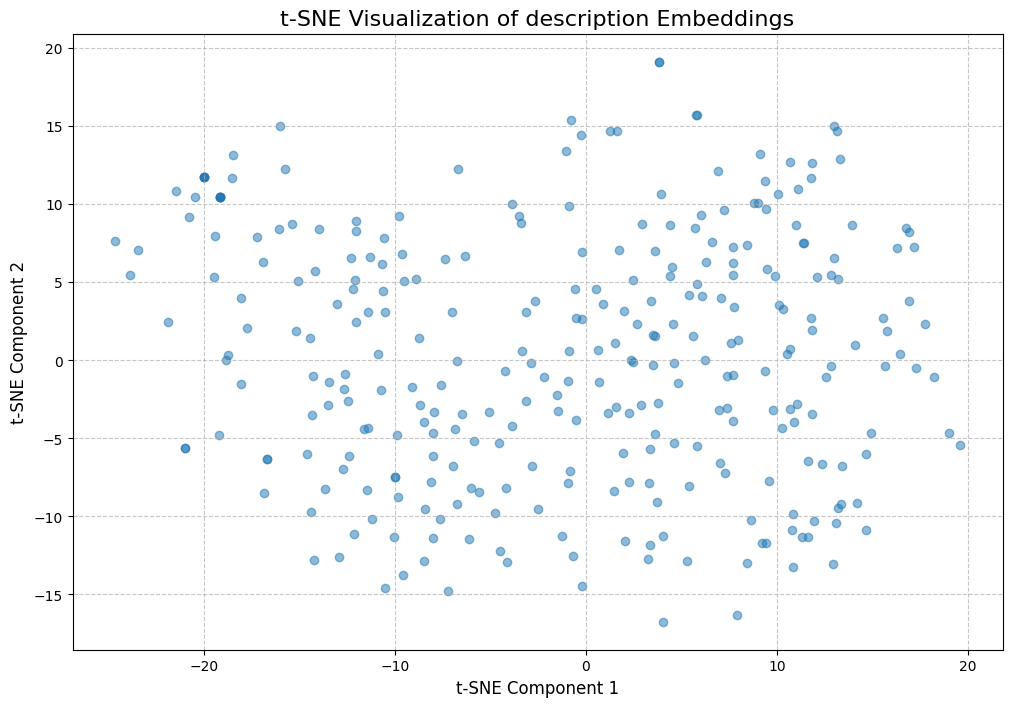

In [73]:
from sklearn.manifold import TSNE


# Reduce dimensions to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_embeddings = tsne.fit_transform(embeddings)

# Add t-SNE results back to the DataFrame
filtered_meta['tsne_1'] = tsne_embeddings[:, 0]
filtered_meta['tsne_2'] = tsne_embeddings[:, 1]

# Plot the embeddings
plt.figure(figsize=(12, 8))
plt.scatter(filtered_meta['tsne_1'], filtered_meta['tsne_2'], alpha=0.5)
plt.title('t-SNE Visualization of description Embeddings', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Both **PCA** and **t-SNE** visualizations show less distinct cluster separation, making it harder to interpret patterns and groupings in the data. In contrast, **UMAP** provides a more defined cluster structure, with well-separated groups that are easier to analyze.

Additionally we will add statistical tests to help our decision on what method to choose:


In [74]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import f_oneway
from scipy.spatial.distance import pdist
import numpy as np

# Extract embeddings
pca_embeddings = filtered_meta[['pca_1', 'pca_2']].values
tsne_embeddings = filtered_meta[['tsne_1', 'tsne_2']].values
umap_embeddings = filtered_meta[['umap_1', 'umap_2']].values

# Define number of clusters
num_clusters = 4

# Apply K-Means clustering to each embedding type
kmeans_pca = KMeans(n_clusters=num_clusters, random_state=42).fit(pca_embeddings)
kmeans_tsne = KMeans(n_clusters=num_clusters, random_state=42).fit(tsne_embeddings)
kmeans_umap = KMeans(n_clusters=num_clusters, random_state=42).fit(umap_embeddings)

# Extract cluster labels
labels_pca = kmeans_pca.labels_
labels_tsne = kmeans_tsne.labels_
labels_umap = kmeans_umap.labels_

# Compute clustering quality metrics
metrics = {
    'PCA': {
        'Silhouette Score': silhouette_score(pca_embeddings, labels_pca),
        'Calinski-Harabasz Index': calinski_harabasz_score(pca_embeddings, labels_pca),
        'Davies-Bouldin Index': davies_bouldin_score(pca_embeddings, labels_pca),
    },
    't-SNE': {
        'Silhouette Score': silhouette_score(tsne_embeddings, labels_tsne),
        'Calinski-Harabasz Index': calinski_harabasz_score(tsne_embeddings, labels_tsne),
        'Davies-Bouldin Index': davies_bouldin_score(tsne_embeddings, labels_tsne),
    },
    'UMAP': {
        'Silhouette Score': silhouette_score(umap_embeddings, labels_umap),
        'Calinski-Harabasz Index': calinski_harabasz_score(umap_embeddings, labels_umap),
        'Davies-Bouldin Index': davies_bouldin_score(umap_embeddings, labels_umap),
    }
}

# Pairwise Euclidean Distance Analysis
pca_distances = pdist(pca_embeddings)
tsne_distances = pdist(tsne_embeddings)
umap_distances = pdist(umap_embeddings)

# Display Results
print("Dimensionality Reduction Performance Metrics:")
for method, values in metrics.items():
    print(f"\n{method}:")
    for metric, score in values.items():
        print(f"  {metric}: {score:.4f}")


Dimensionality Reduction Performance Metrics:

PCA:
  Silhouette Score: 0.4012
  Calinski-Harabasz Index: 272.6617
  Davies-Bouldin Index: 0.8368

t-SNE:
  Silhouette Score: 0.4009
  Calinski-Harabasz Index: 319.3540
  Davies-Bouldin Index: 0.8528

UMAP:
  Silhouette Score: 0.4473
  Calinski-Harabasz Index: 416.0931
  Davies-Bouldin Index: 0.7355


The results confirm that **UMA**P is the best choice for dimensionality reduction on description embeddings. **UMAP** achieves the highest Silhouette Score (**0.4473**), the best cluster compactness (Calinski-Harabasz Index: **416.09**), and the lowest Davies-Bouldin Index (**0.7355**), indicating stronger cluster separation and well-defined groupings compared to **PCA** and **t-SNE**.

These metrics collectively demonstrate that **UMAP** provides the most meaningful and distinct representation of description embeddings, making it the preferred choice for clustering and further analysis.

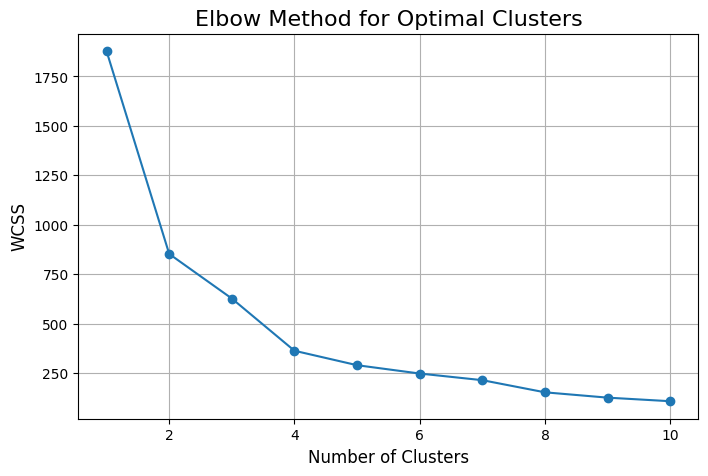

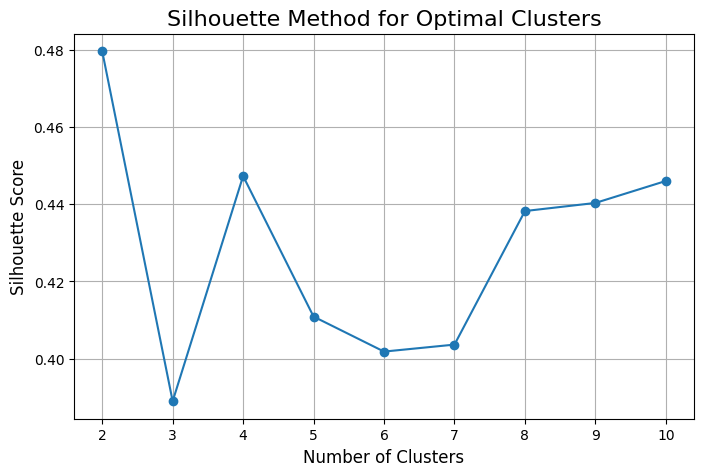

In [75]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Calculate WCSS for different numbers of clusters
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(umap_embeddings)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
plt.grid(True)
plt.show()

# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(umap_embeddings)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(umap_embeddings, labels))

# Plot the Silhouette Method
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Method for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True)
plt.show()

From this analysis, the 'elbow point' appears to lie within the 3–4 cluster range. While the silhouette score is highest for 2 clusters, the score for 4 clusters is the second highest and aligns well with the elbow method. Considering this balance between simplicity and granularity, we have chosen to proceed with 4 clusters as it provides a more detailed yet meaningful grouping of the data.

In [76]:
from sklearn.cluster import KMeans

# Apply KMeans with 4 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=42)
filtered_meta['description_cluster_kmeans'] = kmeans_4.fit_predict(filtered_meta[['umap_1', 'umap_2']])

# Visualize clusters interactively
import plotly.express as px

fig = px.scatter(
    filtered_meta,
    x='umap_1',
    y='umap_2',
    color='description_cluster_kmeans',
    title='Interactive KMeans (4 Clusters) Visualization',
    labels={'umap_1': 'UMAP Component 1', 'umap_2': 'UMAP Component 2', 'description_cluster_kmeans': 'Cluster'},
    hover_data=['title', 'average_rating'],
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_layout(
    title_font_size=20,
    legend_title_text='Cluster',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)
fig.show()

# Generate summary statistics for each cluster
cluster_summary_4 = filtered_meta.groupby('description_cluster_kmeans').agg({
    'average_rating': ['mean', 'std'],
    'rating_number': ['mean', 'std'],
    'price_numeric': ['mean', 'std'],
    'Category_Group': lambda x: x.value_counts().idxmax()  # Most common category group
})

cluster_summary_4.head()


average_rating           rating_number  \
                                     mean       std          mean   
description_cluster_kmeans                                          
0                                4.380392  0.307671    917.372549   
1                                4.473118  0.256710   1983.881720   
2                                4.542222  0.167181   1658.555556   
3                                4.485938  0.264195   1462.296875   

                                        price_numeric             \
                                    std          mean        std   
description_cluster_kmeans                                         
0                           1064.804253     46.992647  80.035662   
1                           3751.467153     41.568495  65.571609   
2                           1152.908763     32.912667  27.606113   
3                           1439.511488     44.407656  43.084048   

                                 Category_Group  
                                       <lambda>  
description_cluster_kmeans                       
0                           PlayStation Systems  
1                           PlayStation Systems  
2                           PlayStation Systems  
3                              Nintendo Systems

Lets compare these results with another clustring method - Spectral clustring:

In [77]:
from sklearn.cluster import SpectralClustering

# Apply Spectral Clustering
spectral_4 = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42)
filtered_meta['description_cluster_spectral'] = spectral_4.fit_predict(filtered_meta[['umap_1', 'umap_2']])

# Visualize spectral clustering
fig = px.scatter(
    filtered_meta,
    x='umap_1',
    y='umap_2',
    color='description_cluster_spectral',
    title='Interactive Spectral Clustering (4 Clusters) Visualization',
    labels={'umap_1': 'UMAP Component 1', 'umap_2': 'UMAP Component 2', 'description_cluster_spectral': 'Cluster'},
    hover_data=['title', 'average_rating'],
    color_discrete_sequence=px.colors.qualitative.Set3
)
fig.update_layout(
    title_font_size=20,
    legend_title_text='Cluster',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)
fig.show()

# Generate summary statistics for each cluster
cluster_summary_4 = filtered_meta.groupby('description_cluster_spectral').agg({
    'average_rating': ['mean', 'std'],
    'rating_number': ['mean', 'std'],
    'price_numeric': ['mean', 'std'],
    'Category_Group': lambda x: x.value_counts().idxmax()  # Most common category group
})

cluster_summary_4.head()

average_rating           rating_number  \
                                       mean       std          mean   
description_cluster_spectral                                          
0                                  4.358678  0.321369    876.090909   
1                                  4.536449  0.169011   2159.635514   
2                                  4.491803  0.262866   1504.278689   
3                                  4.500000  0.229907   1163.066667   

                                          price_numeric             \
                                      std          mean        std   
description_cluster_spectral                                         
0                             1020.049549     50.159256  90.592686   
1                             3499.775457     35.124579  29.943787   
2                             1458.397375     42.450984  39.020614   
3                              834.972495     37.678000  32.749507   

                                   Category_Group  
                                         <lambda>  
description_cluster_spectral                       
0                             PlayStation Systems  
1                             PlayStation Systems  
2                                Nintendo Systems  
3                                    Xbox Systems

**Insights from Clustering Methods:**


**K-Means Clustering:**

* Cluster 0: Lowest average rating and rating count, with the highest average price.

* Cluster 1: Highest rating count with moderate average ratings.

* Cluster 2: Premium cluster, characterized by the highest average rating and a relatively high price.

* Cluster 3: Represents Nintendo games, with moderate ratings and pricing.

**Spectral Clustering:**


* Cluster 0: Lowest average rating and rating count, paired with the highest average price. This may suggest mainstream games that achieve financial success despite receiving less critical acclaim

* Cluster 1: Highest average rating and rating count, with the lowest average price. This cluster may represent "hidden gems" — affordable, high-quality games.

* Cluster 2: High ratings and moderate price, primarily consisting of Nintendo games.

* Cluster 3: High ratings and moderate price, primarily consisting of Xbox games.

**Conclusion:**

While K-Means clustering provides a clear and interpretable separation of clusters, Spectral Clustering offers additional insights into the characteristics of the groups. For example, it highlights "hidden gems" in Cluster 1 and better distinguishes platform-specific groups (Nintendo and Xbox games).

Given the richer information derived from Spectral Clustering, it is preferred for analyzing these groups of games based on their descriptions.

**title_embeddings:**

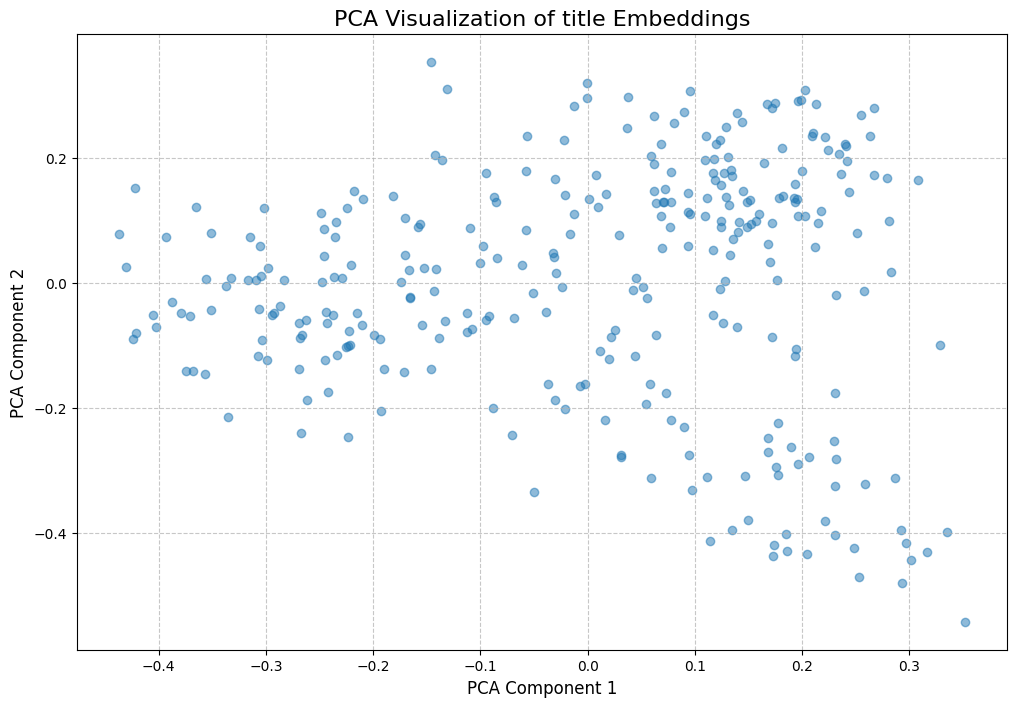

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



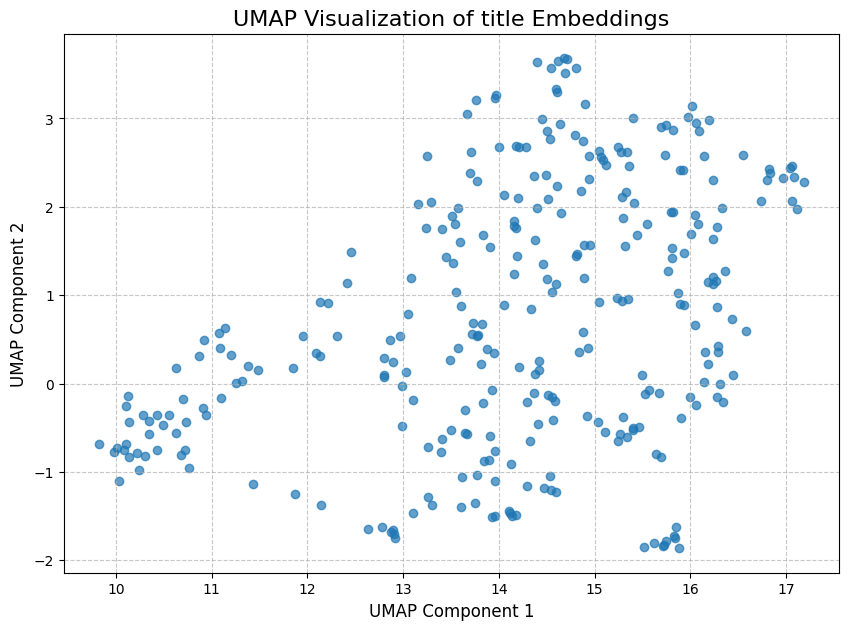

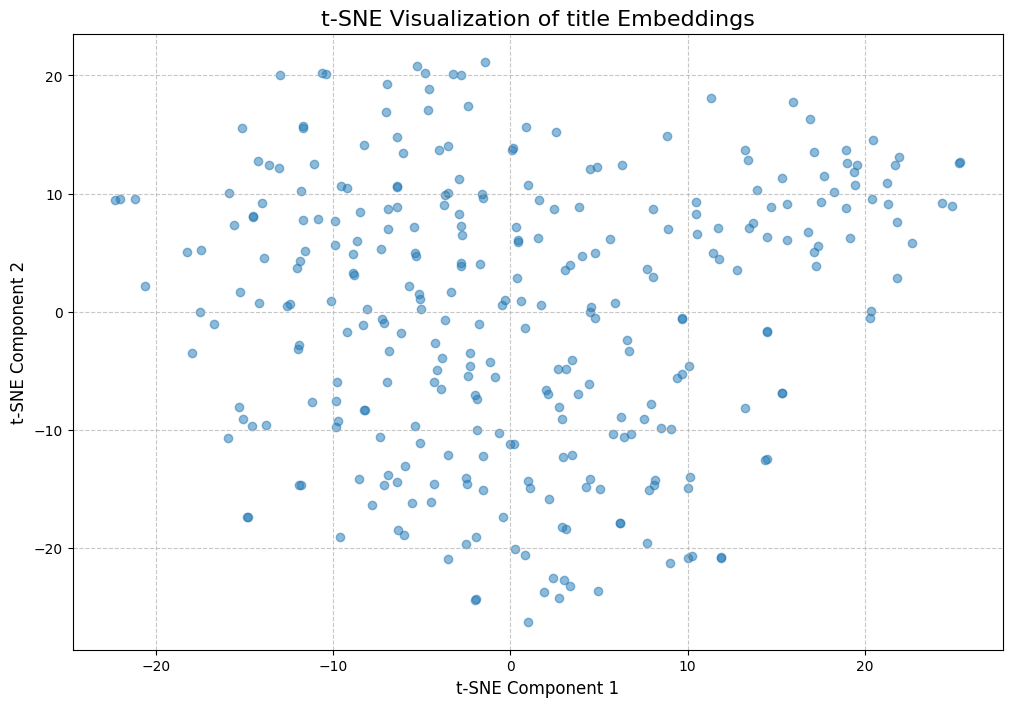

In [78]:
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

embeddings = np.stack(filtered_meta['title_embeddings'])

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Add PCA results to the DataFrame
filtered_meta['pca_1'] = reduced_embeddings[:, 0]
filtered_meta['pca_2'] = reduced_embeddings[:, 1]

# Visualize the reduced embeddings
plt.figure(figsize=(12, 8))
plt.scatter(filtered_meta['pca_1'], filtered_meta['pca_2'], alpha=0.5)
plt.title('PCA Visualization of title Embeddings', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Apply UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# Add UMAP results to DataFrame
filtered_meta['umap_1'] = umap_embeddings[:, 0]
filtered_meta['umap_2'] = umap_embeddings[:, 1]

# Plot UMAP results
plt.figure(figsize=(10, 7))
plt.scatter(filtered_meta['umap_1'], filtered_meta['umap_2'], alpha=0.7)
plt.title('UMAP Visualization of title Embeddings', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Reduce dimensions to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_embeddings = tsne.fit_transform(embeddings)

# Add t-SNE results back to the DataFrame
filtered_meta['tsne_1'] = tsne_embeddings[:, 0]
filtered_meta['tsne_2'] = tsne_embeddings[:, 1]

# Plot the embeddings
plt.figure(figsize=(12, 8))
plt.scatter(filtered_meta['tsne_1'], filtered_meta['tsne_2'], alpha=0.5)
plt.title('t-SNE Visualization of title Embeddings', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

UMAP appears to offer the most clarity in terms of potential clustering, as it highlights subtle separations in a better way compared to the PCA and t-SNE presentations.

We well use statistical tests with the later found ideal number of clusters to determine the best visualization for us to continue with:

In [79]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import f_oneway
from scipy.spatial.distance import pdist
import numpy as np

# Extract embeddings
pca_embeddings = filtered_meta[['pca_1', 'pca_2']].values
tsne_embeddings = filtered_meta[['tsne_1', 'tsne_2']].values
umap_embeddings = filtered_meta[['umap_1', 'umap_2']].values

# Define number of clusters
num_clusters = 20

# Apply K-Means clustering to each embedding type
kmeans_pca = KMeans(n_clusters=num_clusters, random_state=42).fit(pca_embeddings)
kmeans_tsne = KMeans(n_clusters=num_clusters, random_state=42).fit(tsne_embeddings)
kmeans_umap = KMeans(n_clusters=num_clusters, random_state=42).fit(umap_embeddings)

# Extract cluster labels
labels_pca = kmeans_pca.labels_
labels_tsne = kmeans_tsne.labels_
labels_umap = kmeans_umap.labels_

# Compute clustering quality metrics
metrics = {
    'PCA': {
        'Silhouette Score': silhouette_score(pca_embeddings, labels_pca),
        'Calinski-Harabasz Index': calinski_harabasz_score(pca_embeddings, labels_pca),
        'Davies-Bouldin Index': davies_bouldin_score(pca_embeddings, labels_pca),
    },
    't-SNE': {
        'Silhouette Score': silhouette_score(tsne_embeddings, labels_tsne),
        'Calinski-Harabasz Index': calinski_harabasz_score(tsne_embeddings, labels_tsne),
        'Davies-Bouldin Index': davies_bouldin_score(tsne_embeddings, labels_tsne),
    },
    'UMAP': {
        'Silhouette Score': silhouette_score(umap_embeddings, labels_umap),
        'Calinski-Harabasz Index': calinski_harabasz_score(umap_embeddings, labels_umap),
        'Davies-Bouldin Index': davies_bouldin_score(umap_embeddings, labels_umap),
    }
}

# Pairwise Euclidean Distance Analysis
pca_distances = pdist(pca_embeddings)
tsne_distances = pdist(tsne_embeddings)
umap_distances = pdist(umap_embeddings)

# Display Results
print("Dimensionality Reduction Performance Metrics:")
for method, values in metrics.items():
    print(f"\n{method}:")
    for metric, score in values.items():
        print(f"  {metric}: {score:.4f}")

Dimensionality Reduction Performance Metrics:

PCA:
  Silhouette Score: 0.3581
  Calinski-Harabasz Index: 364.2027
  Davies-Bouldin Index: 0.8199

t-SNE:
  Silhouette Score: 0.3410
  Calinski-Harabasz Index: 282.8604
  Davies-Bouldin Index: 0.8057

UMAP:
  Silhouette Score: 0.4562
  Calinski-Harabasz Index: 516.6078
  Davies-Bouldin Index: 0.6428


The statistical results further reinforce that **UMAP** is the superior dimensionality reduction technique for our dataset. With the highest Silhouette Score (**0.4562**), best cluster compactness (Calinski-Harabasz Index: **516.61**), and lowest Davies-Bouldin Index (**0.6428**), **UMAP** demonstrates clearer, more meaningful separations compared to **PCA** and **t-SNE**.

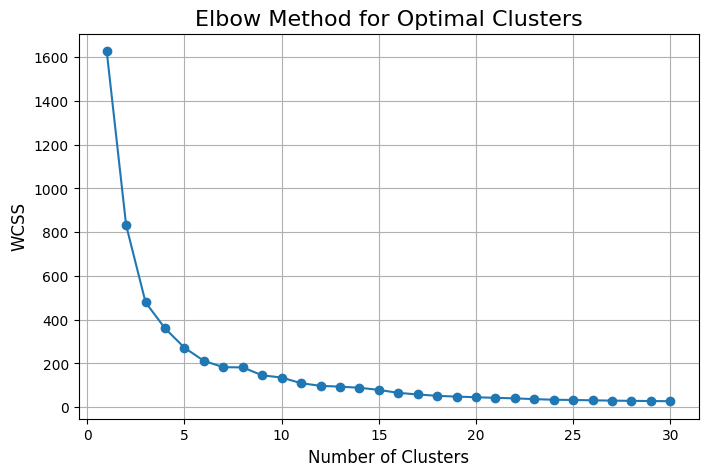

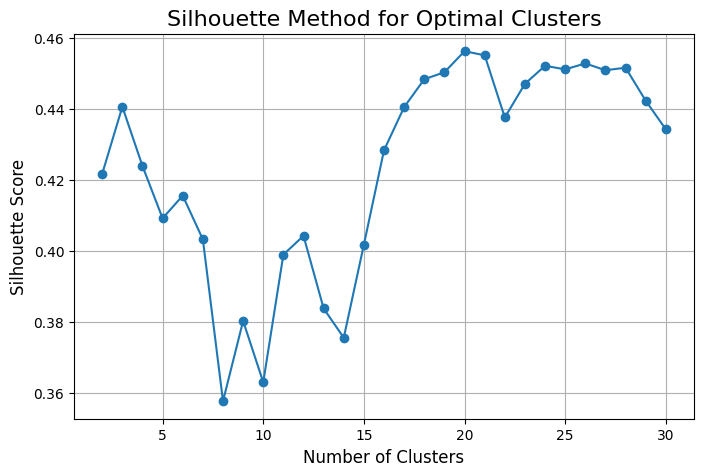

In [80]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Calculate WCSS for different numbers of clusters
wcss = []
for k in range(1, 31):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(umap_embeddings)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 31), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
plt.grid(True)
plt.show()

# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(umap_embeddings)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(umap_embeddings, labels))

# Plot the Silhouette Method
plt.figure(figsize=(8, 5))
plt.plot(range(2, 31), silhouette_scores, marker='o')
plt.title('Silhouette Method for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True)
plt.show()

From the elbow method the optimal value seems to be in the 4-6 range while the highest silhouette score is for 20 clusters.

Based on the elbow method, the optimal number of clusters appears to be in the range of 4-6, whereas the highest silhouette score is observed at 20 clusters.

We will explore both approaches, as the title_embeddings may contain crucial information that can help group games belonging to the same series. Identifying such relationships could be highly beneficial for targeting potential customers who are likely to be interested in other games within a specific series.

In [81]:
from sklearn.cluster import KMeans

# Apply KMeans with 4 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=42)
filtered_meta['title_4_cluster'] = kmeans_4.fit_predict(filtered_meta[['umap_1', 'umap_2']])

# Visualize clusters interactively
import plotly.express as px

fig = px.scatter(
    filtered_meta,
    x='umap_1',
    y='umap_2',
    color='title_4_cluster',
    title='Interactive KMeans (4 Clusters) Visualization',
    labels={'umap_1': 'UMAP Component 1', 'umap_2': 'UMAP Component 2', 'title_4_cluster': 'Cluster'},
    hover_data=['title', 'average_rating'],
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_layout(
    title_font_size=20,
    legend_title_text='Cluster',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)
fig.show()


In [82]:
from sklearn.cluster import KMeans

# Apply KMeans with 20 clusters
kmeans_20 = KMeans(n_clusters=20, random_state=42)
filtered_meta['title_20_cluster'] = kmeans_20.fit_predict(filtered_meta[['umap_1', 'umap_2']])

# Visualize clusters interactively
import plotly.express as px

fig = px.scatter(
    filtered_meta,
    x='umap_1',
    y='umap_2',
    color='title_20_cluster',
    title='Interactive KMeans (20 Clusters) Visualization',
    labels={'umap_1': 'UMAP Component 1', 'umap_2': 'UMAP Component 2', 'title_20_cluster': 'Cluster'},
    hover_data=['title', 'average_rating'],
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_layout(
    title_font_size=20,
    legend_title_text='Cluster',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)
fig.show()


In this case we will focus less on the charactrisitic of the games in each cluster and more on the game themself, due to the relative managable size of the data we will have a closer inspection into the games in each cluster.

for the 4-clusters we observe that generally games of the same game series are groupd together, but are with other games series or standalone games

In [83]:
# Group by cluster and display games in each cluster
for cluster_id in sorted(filtered_meta['title_20_cluster'].unique()):
    print(f"\nCluster {cluster_id}:")
    games_in_cluster = filtered_meta[filtered_meta['title_20_cluster'] == cluster_id]
    print(games_in_cluster[['title', 'Category_Group']])



Cluster 0:
                                                 title       Category_Group
2        LEGO Batman 2: DC Super Heroes - Nintendo 3DS     Nintendo Systems
38        LEGO Batman 3: Beyond Gotham - PlayStation 3  PlayStation Systems
51            LEGO Pirates of the Caribbean - Xbox 360         Xbox Systems
61   Batman: Arkham City - Game of The Year Edition...  PlayStation Systems
68   Disney Epic Mickey 2: The Power of Two - Plays...  PlayStation Systems
80                    Batman: Arkham Asylum - Xbox 360         Xbox Systems
89               Batman: Arkham Knight - Playstation 4  PlayStation Systems
93        Lego Star Wars: The Complete Saga - Xbox 360         Xbox Systems
113    Batman: Arkham Origins Collectible Case for PS3  PlayStation Systems
114  Batman: Arkham Asylum (Game of The Year Editio...  PlayStation Systems
115                                        Tomb Raider  PlayStation Systems
185           LEGO Marvel Super Heroes - PlayStation 4  PlayStation Systems


In [84]:
# Group by cluster and display games in each cluster
for cluster_id in sorted(filtered_meta['title_4_cluster'].unique()):
    print(f"\nCluster {cluster_id}:")
    games_in_cluster = filtered_meta[filtered_meta['title_4_cluster'] == cluster_id]
    print(games_in_cluster[['title', 'Category_Group']])


Cluster 0:
                                                 title       Category_Group
1              Mass Effect Andromeda Deluxe - Xbox One         Xbox Systems
3    Grand Theft Auto V: Premium Edition - Xbox One...         Xbox Systems
5                  Star Wars Battlefront II - Xbox One         Xbox Systems
6                Wolfenstein: The New Order - Xbox 360         Xbox Systems
7            Resident Evil 6 Anthology - Playstation 3  PlayStation Systems
..                                                 ...                  ...
286                   Halo: Combat Evolved Anniversary         Xbox Systems
291    Overwatch - Game of the Year Edition - Xbox One         Xbox Systems
292                  Saint's Row: The Third - Xbox 360         Xbox Systems
296                      Forza Motorsport 4 - Xbox 360         Xbox Systems
302                             Mass Effect - Xbox 360         Xbox Systems

[82 rows x 2 columns]

Cluster 1:
                                         

For the 4-cluster configuration, we observe that games belonging to the same series are generally grouped together, but these clusters also include many other unrelated games from different series or standalone titles. In contrast, the 20-cluster configuration demonstrates much more specific grouping (as expected) and effectively clusters games from the same series with minimal overlap with other series or standalone games.

For instance, **Cluster 15** consists exclusively of *Assassin's Creed* games, while **Cluster 19** includes only *Need for Speed* titles. This high degree of specificity and the precise identification of games within the same series make the 20-cluster configuration preferable. Therefore, we will proceed with the 20-cluster configuration.

#### Preparing The Data For Recommendation System

In [85]:
filtered_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         304 non-null    object 
 1   average_rating                304 non-null    float64
 2   rating_number                 304 non-null    int64  
 3   features                      304 non-null    object 
 4   description                   304 non-null    object 
 5   price                         304 non-null    float64
 6   store                         304 non-null    object 
 7   categories                    304 non-null    object 
 8   parent_asin                   304 non-null    object 
 9   price_numeric                 304 non-null    float64
 10  Category_Group                304 non-null    object 
 11  games_Group                   304 non-null    object 
 12  title_embeddings              304 non-null    object 
 13  parse

From this point forward, since we have already extracted embeddings from the textual data, we can drop the original text features and retain only their embeddings.

We will normalize numeric values and categorize categorical values. Additionally, features that will not be useful in the future (e.g., pca_1, umpa_1, etc.) will be removed.

**To summarize, we will:**

* **Remove**: title, rating_number, features, description, price, store, categories, games_Group, parsed_features, pca_1, pca_2, umpa_1, umpap_2, tsne_1, tsne_2, title_4_cluster.

* **Normalize**: average_rating, price_numeric.

* **Categorize**: Category_Group.

* **Keep as is**: parent_asin, title_embeddings, feature_embeddings, description_embeddings, feature_cluster, description_cluster, title_20_cluster.

* **Rename**: description_cluster_spectral, title_20_cluster.

Since prices range from approximately 10 to 750, a clear imbalance could occur during normalization. However, given that only four items have a price above 200, we will set 200 as the cap and normalize prices within the range of 0–200.

In [86]:
import pandas as pd

filtered_meta.drop(columns=["title", "features", "description",
    "price", "store", "categories", "games_Group", "description_cluster_kmeans",
    "parsed_features", "pca_1", "pca_2", 'rating_number',
    "umap_1", "umap_2", "tsne_1", "tsne_2", "title_4_cluster" ], inplace=True)


In [87]:
filtered_meta.rename(columns={"description_cluster_spectral": "description_cluster"}, inplace=True)
filtered_meta.rename(columns={"title_20_cluster": "title_cluster"}, inplace=True)


In [88]:
# Get unique values for categorical columns
categorical_cols = ["Category_Group"]

# Create mappings for each categorical column
category_mappings = {}
for col in categorical_cols:
    unique_values = sorted(filtered_meta[col].unique())  # Sorted for consistency
    category_mappings[col] = {val: i for i, val in enumerate(unique_values)}  # Mapping dictionary

# Apply encoding manually
for col in categorical_cols:
    filtered_meta[col] = filtered_meta[col].map(category_mappings[col])

In [89]:
from sklearn.preprocessing import MinMaxScaler

filtered_meta['price_numeric'] = filtered_meta['price_numeric'].clip(upper=200)
filtered_meta['price_numeric'] = filtered_meta['price_numeric'] / 200

scaler = MinMaxScaler()
filtered_meta['average_rating'] = scaler.fit_transform(filtered_meta[['average_rating']])

In [90]:
filtered_meta.head()

average_rating parent_asin  price_numeric  Category_Group  \
0        0.666667  B00BN5T30E        0.21945               1   
1        0.761905  B01GY35HKE        0.18475               3   
2        0.904762  B007YZCE94        0.14025               0   
3        0.904762  B0086VPUHI        0.07500               3   
4        0.666667  B008B3QCJQ        0.14490               2   

                                    title_embeddings  \
0  [-0.003220567014068365, 0.046798862516880035, ...   
1  [0.0469626821577549, -0.08388175070285797, 0.0...   
2  [-0.07791230827569962, 0.01947767660021782, -0...   
3  [-0.05649198591709137, 0.01896056719124317, -0...   
4  [-0.01736215502023697, -0.014361448585987091, ...   

                                 features_embeddings  \
0  [0.080163315, -0.052779596, 0.05158046, 0.0262...   
1  [0.005770601, -0.24006855, 0.15395077, -0.0382...   
2  [0.05597514, 0.009959414, 0.0060962546, -0.026...   
3  [0.0011726338, -0.17010686, 0.21740168, -0.146...   
4  [-0.0042527495, -0.048563775, 0.08905381, 0.00...   

                              description_embeddings  features_cluster  \
0  [0.09119907021522522, 0.10038165003061295, 0.0...                 1   
1  [-0.017229901626706123, -0.10814885795116425, ...                 2   
2  [0.13787400722503662, 0.01819632761180401, -0....                 0   
3  [0.008390186354517937, -0.030142607167363167, ...                 2   
4  [0.035485804080963135, -0.03860778361558914, 0...                 1   

   description_cluster  title_cluster  
0                    0             15  
1                    1             14  
2                    2              0  
3                    1             11  
4                    0             12

In [91]:
filtered_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   average_rating          304 non-null    float64
 1   parent_asin             304 non-null    object 
 2   price_numeric           304 non-null    float64
 3   Category_Group          304 non-null    int64  
 4   title_embeddings        304 non-null    object 
 5   features_embeddings     304 non-null    object 
 6   description_embeddings  304 non-null    object 
 7   features_cluster        304 non-null    int32  
 8   description_cluster     304 non-null    int32  
 9   title_cluster           304 non-null    int32  
dtypes: float64(2), int32(3), int64(1), object(4)
memory usage: 20.3+ KB


Next for the reviews:

In [92]:
filtered_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32323 entries, 0 to 32322
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   rating                     32323 non-null  int64         
 1   title                      32323 non-null  object        
 2   text                       32323 non-null  object        
 3   asin                       32323 non-null  object        
 4   parent_asin                32323 non-null  object        
 5   user_id                    32323 non-null  object        
 6   timestamp                  32323 non-null  datetime64[ns]
 7   helpful_vote               32323 non-null  int64         
 8   verified_purchase          32323 non-null  bool          
 9   review_length              32323 non-null  int64         
 10  year_month                 32323 non-null  period[M]     
 11  era                        32323 non-null  object        
 12  sent

* **Remove**: title, text, asin, year_month, sentiment_scores, positive_sentiment_prob, pca_1, pca_2.

* **Categorize**: helpful_vote, verified_purchase, era, review_length, predicted_sentiment, sentiment_category.

We will categorize the numeric values of review_length into four groups, considering the high variance in their values.

**review_length:**

* 0–99 (short)
* 100–499 (medium)
* 500–1999 (detailed)
* 2000+ (extremely detailed)

Eventually, we want to categorize numerically from 0 to 3.

In [93]:
filtered_reviews.drop(columns=["title", "text", "year_month", "sentiment_scores",
                "positive_sentiment_prob", "pca_1", "pca_2"], inplace=True)

In [94]:
# Categorize review_length into 4 groups
def categorize_review_length(length):
    if length < 100:
        return 0  # Short
    elif 100 <= length < 500:
        return 1  # Medium
    elif 500 <= length < 2000:
        return 2  # Detailed
    else:
        return 3  # Extremely detailed

filtered_reviews['review_length'] = filtered_reviews['review_length'].apply(categorize_review_length)

In [95]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["era", "predicted_sentiment", "sentiment_category"]

# Convert categorical values to numeric using Label Encoding
for col in categorical_cols:
    encoder = LabelEncoder()
    filtered_reviews[col] = encoder.fit_transform(filtered_reviews[col])

In [96]:
filtered_reviews.head()

rating        asin parent_asin                       user_id  \
0       3  B000FQBF1M  B000FQBF1M  AE25ZDXYBK3LHKCZ7XUODANPME4A   
1       4  B0016B28WU  B001EYUQTQ  AE25ZDXYBK3LHKCZ7XUODANPME4A   
2       3  B002BRZ6UE  B002BSH3KE  AE25ZDXYBK3LHKCZ7XUODANPME4A   
3       3  B002I0K6DG  B002I0K6DG  AE25ZDXYBK3LHKCZ7XUODANPME4A   
4       4  B003JVCA9Q  B003JVCA9Q  AE25ZDXYBK3LHKCZ7XUODANPME4A   

            timestamp  helpful_vote  verified_purchase  review_length  era  \
0 2010-10-10 21:35:07             0              False              1    2   
1 2011-03-31 21:38:08             0              False              1    2   
2 2011-03-31 21:35:00             2               True              2    2   
3 2011-03-01 01:28:28             0              False              1    2   
4 2010-11-11 20:19:26             0              False              1    2   

   predicted_sentiment                          title_and_text_embeddings  \
0                    0  [0.006147982, -0.0011016666, 0.006066651, -0.0...   
1                    1  [0.021358658, -0.0027868252, 0.0005032796, -0....   
2                    0  [-0.009511947, -0.012831048, 0.0153323095, -0....   
3                    0  [0.0013867164, -0.0135066835, -0.0007743977, -...   
4                    1  [-0.0047570067, 0.008976277, -0.00030486647, 0...   

   scaled_sentiment  adjusted_rating  sentiment_category  \
0          0.001749         2.100525                   2   
1          4.999833         4.299950                   3   
2          0.000192         2.100058                   2   
3          0.000468         2.100140                   2   
4          4.999238         4.299771                   3   

   title_and_text_cluster  
0                       3  
1                       0  
2                       3  
3                       3  
4                       3

In [97]:
# save the DataFrame as Parquet to Google Drive
filtered_reviews.to_parquet('/content/drive/My Drive/filtered_reviews_final.parquet', index=False, engine='pyarrow')
filtered_meta.to_parquet('/content/drive/My Drive/filtered_meta_final.parquet', index=False, engine='pyarrow')

In [98]:
# save the DataFrame as csv to Google Drive
filtered_reviews.to_csv('/content/drive/My Drive/filtered_reviews_final.csv', index=False)
filtered_meta.to_csv('/content/drive/My Drive/filtered_meta_final.csv', index=False)

# Recommendation Systems

In this project, we aim to develop a recommendation system that goes beyond simply predicting a user's rating for an unseen game—an existing problem with numerous solutions. Instead, our focus is on precisely identifying games a user is likely to be interested enough to buy, based on their past purchases.

The system will generate ten personalized game recommendations from a pool of 304 available titles. Our goal is to ensure that at least one of these ten recommendations aligns with the user's actual interests. To evaluate our model's effectiveness, we will use a test set where each user has at least 2 unseen reviews, that we will try to be able to reccomend him at least one of them.


Rather than solely predicting which games a user will rate the highest, our approach aims to predict which games they are most likely to purchase. This distinction is crucial for service providers, as it offers a more effective tool for encouraging user purchases—in this case, video games.

In [3]:
file_path_meta = '/content/drive/My Drive/filtered_meta_final.parquet'
file_path_reviews = '/content/drive/My Drive/filtered_reviews_final.parquet'

filtered_meta = pd.read_parquet(file_path_meta, engine="pyarrow", dtype_backend="numpy_nullable")
filtered_reviews = pd.read_parquet(file_path_reviews, engine="pyarrow", dtype_backend="numpy_nullable")


In [4]:
filtered_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   average_rating          304 non-null    Float64
 1   parent_asin             304 non-null    string 
 2   price_numeric           304 non-null    Float64
 3   Category_Group          304 non-null    Int64  
 4   title_embeddings        304 non-null    object 
 5   features_embeddings     304 non-null    object 
 6   description_embeddings  304 non-null    object 
 7   features_cluster        304 non-null    Int32  
 8   description_cluster     304 non-null    Int32  
 9   title_cluster           304 non-null    Int32  
dtypes: Float64(2), Int32(3), Int64(1), object(3), string(1)
memory usage: 22.1+ KB


In [5]:
filtered_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32323 entries, 0 to 32322
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   rating                     32323 non-null  Int64         
 1   asin                       32323 non-null  string        
 2   parent_asin                32323 non-null  string        
 3   user_id                    32323 non-null  string        
 4   timestamp                  32323 non-null  datetime64[ns]
 5   helpful_vote               32323 non-null  Int64         
 6   verified_purchase          32323 non-null  boolean       
 7   review_length              32323 non-null  Int64         
 8   era                        32323 non-null  Int64         
 9   predicted_sentiment        32323 non-null  Int64         
 10  title_and_text_embeddings  32323 non-null  object        
 11  scaled_sentiment           32323 non-null  Float64       
 12  adju

##**Train-Test Split Strategy**

To build a reliable and realistic recommendation system, we need an effective strategy for splitting our dataset into training and testing sets.

Initially, we considered a Leave-One-Out (LOO) approach, where we would retain a single review per user for testing while using the rest for training. However, upon further evaluation, we identified several issues with this approach and opted for a more suitable hybrid approach instead.

The reasons being that if a user's only test review happens to be negative, our model would be unfairly penalized for correctly identifying that the user would not have liked the item. This is particularly problematic because many users in our dataset have only 5 reviews (the minimum threshold in our dataset). If we pick just one review, we risk selecting a single negative review, making evaluation misleading.

To address these challenges, we adopted a hybrid approach that aim for a 80/20 split for each user if possible, while ensuring at least two reviews per user in the test set. This strategy helps reduce the likelihood of selecting only a single negative review, maintaining a fair evaluation.

This approach is best for our dataset and use case as its:

1. **Better represent users behavior**: Users  have multiple opportunities to be evaluated in test cases, not just one.

2. **Balancing data without leakage**: We do not pre-select positive reviews (which would create bias). Instead, we let the natural distribution of user behavior define the train-test split.

3. **Ensures our model predicts purchases accurately**: By guaranteeing at least one verified purchase in the test set, we ensure that evaluation is aligned with our real-world goal: predicting games a user will actually buy.

In [6]:
import pandas as pd
import numpy as np


filtered_reviews = filtered_reviews.sort_values(by=["user_id"])


# Define function for random train-test split per user
def random_split(user_df, train_ratio=0.8, min_test_reviews=2):
    """
    Splits a user's reviews into training and testing sets randomly.
    Ensures the test set contains at least one verified purchase and a mix of ratings.
    """
    total_reviews = len(user_df)
    test_size = max(min_test_reviews, int(total_reviews * (1 - train_ratio)))  # Ensure at least 2 in test

    # Randomly shuffle user reviews
    user_df = user_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Select random test reviews
    test_set = user_df.iloc[:test_size]
    train_set = user_df.iloc[test_size:]

    # Ensure at least one purchase in test set
    if not (test_set["verified_purchase"] == 1).any():
        purchase_in_train = train_set[train_set["verified_purchase"] == 1]
        if not purchase_in_train.empty:
            chosen_purchase = purchase_in_train.sample(1, random_state=42)  # Pick a random purchase
            train_set = train_set.drop(chosen_purchase.index)  # Remove from train
            test_set = pd.concat([test_set, chosen_purchase])  # Add to test

    return train_set, test_set

# Apply the split per user
train_list, test_list = [], []
for user, user_reviews in filtered_reviews.groupby("user_id"):
    train_data, test_data = random_split(user_reviews)
    train_list.append(train_data)
    test_list.append(test_data)

# Merge back into DataFrames
train_set = pd.concat(train_list)
test_set = pd.concat(test_list)

# Display the size of each split
train_set_size = train_set.shape[0]
test_set_size = test_set.shape[0]
train_set_size, test_set_size

(22624, 9699)

we get an eventual split of about 70/30 for the train/test sets.

## **Evaluation Metrics for Our Recommendation System**

To assess the effectiveness of our recommendation models, we use a combination of ranking-based and hit-based metrics. These metrics ensure that our recommendations are both accurate and practically useful for users.

1. **Hit Rate@10 (HR@10)** - This is **the most critical metric** for our project. It measures the proportion of users for whom **at least one** of the top 10 recommended games appears in their actual purchases. Since our primary objective is to recommend games that users are likely to buy, HR@10 directly reflects our success in achieving this goal.

2. **Precision@10** - This evaluates the proportion of recommended items that are actually relevant, adjusted based on how many true purchases a user has. Unlike HR@10, which only requires one correct recommendation, precision@10 penalizes irrelevant suggestions, ensuring that most of the recommended items are useful and well-targeted.

3. **NDCG@10 (Normalized Discounted Cumulative Gain)** - This metric assesses ranking quality, rewarding models that place purchased games higher in the recommendation list. Since a relevant game at rank #1 is much more valuable than at rank #10, NDCG@10 encourages models to prioritize the most relevant recommendations first, improving user engagement.

4. **MAP@10 (Mean Average Precision)** - This measures precision at multiple levels, averaging precision over all correct recommendations. Unlike HR@10, which focuses on any correct recommendation, or Precision@10, which focuses on individual relevance, MAP@10 considers the overall ranking performance, ensuring that multiple correct recommendations appear early in the list while maintaining diversity in recommendations.

By combining these metrics, we ensure a comprehensive evaluation of our recommendation system, balancing accuracy, ranking quality, and real-world effectiveness in helping users discover games they are likely to purchase.

In order to compare all models we will save our results in a data structure for later analysis

In [7]:
import time

# Dictionary to store all model results
model_results = {}

## Baseline Model - SVD (Singular Value Decomposition)

For this project, we selected Singular Value Decomposition (SVD) as our baseline model because it provides a simple, yet effective foundation for recommendation systems, particularly in matrix factorization approaches.

SVD is one of the most widely used techniques in recommendation systems. It decomposes the user-item interaction matrix into latent factors, capturing underlying relationships between users and games. This makes it a good benchmark to compare more advanced models against.

We start with creating the evaluation function we'll use on the final model.

In [8]:
from collections import defaultdict
import numpy as np

def get_top_k_recommendations(model, test_users, all_items, k=10):
    """ Generate top-K recommendations for each user """
    top_k_recommendations = defaultdict(list)

    for user_id in test_users:
        # Predict scores for all games
        predictions = [(game, model.predict(user_id, game).est) for game in all_items]

        # Sort by predicted score (descending) and take the top K
        sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:k]

        # Store only game IDs
        top_k_recommendations[user_id] = [game for game, _ in sorted_predictions]

    return top_k_recommendations

In [9]:
def evaluate_recommendations(top_k_recommendations, test_set, k=10):
    """ Evaluate the recommendations with adjusted metrics """

    hit_count = 0
    total_users = len(test_set['user_id'].unique())

    recall_scores = []
    precision_scores = []
    ndcg_scores = []
    average_precisions = []

    # Group test set by user to get all correct purchases
    user_true_games = test_set.groupby("user_id")["parent_asin"].apply(set).to_dict()

    for user_id, true_games in user_true_games.items():
        if user_id in top_k_recommendations:
            recommended_games = top_k_recommendations[user_id]

            # Count number of correct recommendations
            relevant_count = sum(1 for game in recommended_games if game in true_games)
            total_true_items = len(true_games)  # Number of actual purchases for the user

            # Hit Rate@K (1 if at least one correct recommendation was found)
            hit = 1 if relevant_count > 0 else 0
            hit_count += hit

            # Precision@K (correct recommendations / min(K, total_true_items))
            effective_k = min(k, total_true_items)  # Adjusted denominator
            precision_at_k = relevant_count / effective_k if effective_k > 0 else 0
            precision_scores.append(precision_at_k)

            # NDCG@K (adjusted to only consider available correct items)
            relevance = np.array([1 if game in true_games else 0 for game in recommended_games])
            ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(len(true_games), k)))  # IDCG only considers available true games
            dcg = sum(1 / np.log2(i + 2) if game in true_games else 0 for i, game in enumerate(recommended_games[:k]))
            ndcg_at_k = dcg / ideal_dcg if ideal_dcg > 0 else 0
            ndcg_scores.append(ndcg_at_k)

            # MAP@K (adjusted denominator)
            relevant_items = [1 if game in true_games else 0 for game in recommended_games]
            if sum(relevant_items) > 0:
                precision_at_ranks = [
                    sum(relevant_items[:i + 1]) / (i + 1) for i in range(len(relevant_items)) if relevant_items[i] == 1
                ]
                ap_at_k = np.mean(precision_at_ranks) if precision_at_ranks else 0
            else:
                ap_at_k = 0

            average_precisions.append(ap_at_k)

    # Compute final metrics
    hit_rate = hit_count / total_users
    precision_at_k = np.mean(precision_scores)
    ndcg_at_k = np.mean(ndcg_scores) if ndcg_scores else 0
    map_at_k = np.mean(average_precisions) if average_precisions else 0

    return {
        'Hit Rate@K': round(hit_rate, 4),
        'Precision@K': round(precision_at_k, 4),  # Uses min(K, total_true_items)
        'NDCG@K': round(ndcg_at_k, 4),  # IDCG is adjusted to the number of actual purchases
        'MAP@K': round(map_at_k, 4)  # Uses min(K, total_true_items)
    }

In [10]:
def evaluate_model(model, test_set, all_items, k=10):
    """ Main function to evaluate the model """

    test_users = test_set['user_id'].unique()
    top_k_recommendations = get_top_k_recommendations(model, test_users, all_items, k)
    results = evaluate_recommendations(top_k_recommendations, test_set, k)

    return results

In [11]:
!pip install scikit-surprise

  Using cached scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl


In [13]:
from surprise import SVD, Dataset, Reader

all_items = filtered_reviews['parent_asin'].unique()
reader = Reader(rating_scale=(filtered_reviews['rating'].min(), filtered_reviews['rating'].max()))
train_data = Dataset.load_from_df(train_set[['user_id', 'parent_asin', 'rating']], reader)
trainset = train_data.build_full_trainset()
testset = list(test_set[['user_id', 'parent_asin', 'rating']].itertuples(index=False, name=None))

start_time = time.time()
model = SVD()
model.fit(trainset)
svd_results = evaluate_model(model, test_set, all_items, k=10)
end_time = time.time()
runtime_svd = round(end_time - start_time, 2)

model_results["SVD"] = {
    "Hit Rate@K": svd_results["Hit Rate@K"],
    "Precision@K": svd_results["Precision@K"],
    "NDCG@K": svd_results["NDCG@K"],
    "MAP@K": svd_results["MAP@K"],
    "Runtime (s)": runtime_svd
}

# Print SVD results
print("SVD Model Results:")
for model_name, metrics in model_results.items():
    print(f"\n🔹 {model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

SVD Model Results:

🔹 SVD:
  Hit Rate@K: 0.0792
  Precision@K: 0.0386
  NDCG@K: 0.0231
  MAP@K: 0.0258
  Runtime (s): 30.6


For our baseline model we have a low score of about 8% success in recommending users with at least one item they will be intrested in. Our aim of course would be to surpass it.

First we will focus on Matrix Factorization oriented models that we will try and improve our results with:

## **SVD++**

SVD++ is an extension of Singular Value Decomposition (SVD) specifically designed to improve recommendation performance by incorporating implicit feedback from user interactions. While standard SVD relies only on explicit ratings to learn user and item embeddings, SVD++ enhances this by considering additional interactions, such as viewed but unrated items, clicks, and purchases, to better understand user preferences.

SVD++ extends traditional matrix factorization by introducing an additional latent factor term that captures user-item implicit interactions.

In [14]:
from surprise import SVDpp, Dataset, Reader
import pandas as pd


reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_set[['user_id', 'parent_asin', 'rating']], reader)
testset = list(test_set[['user_id', 'parent_asin', 'rating']].itertuples(index=False, name=None))
trainset = train_data.build_full_trainset()

start_time = time.time()
svdpp_model = SVDpp(n_factors=30, reg_all=0.02, n_epochs=20)
svdpp_model.fit(trainset)
predictions_svdpp = svdpp_model.test(testset)
svdpp_results = evaluate_model(svdpp_model, test_set, all_items, k=10)

end_time = time.time()
runtime_svdpp = round(end_time - start_time, 2)

model_results["SVD++"] = {
    "Hit Rate@K": svdpp_results["Hit Rate@K"],
    "Precision@K": svdpp_results["Precision@K"],
    "NDCG@K": svdpp_results["NDCG@K"],
    "MAP@K": svdpp_results["MAP@K"],
    "Runtime (s)": runtime_svdpp
}

model_name = "SVD++"

print(f"\n🔹 {model_name} Results:")
for metric, value in model_results[model_name].items():
  print(f"  {metric}: {value}")



🔹 SVD++ Results:
  Hit Rate@K: 0.114
  Precision@K: 0.055
  NDCG@K: 0.0327
  MAP@K: 0.037
  Runtime (s): 55.79


Compared to the baseline **SVD** model, **SVD++** demonstrates a clear improvement across all evaluation metrics. This increase aligns with expectations due to the fundamental differences between the two models, particularly **SVD++**'s ability to leverage implicit feedback, which allows it to better capture user preferences beyond explicit ratings.

While this improvement is a positive step, the overall success rate remains relatively modest when considering all users. Therefore, to further enhance recommendation accuracy, we will explore more advanced models and optimizations that can drive greater performance gains in subsequent iterations.

## **Implicit Factorization Models: Implicit ALS & BPR**

Since our goal is to predict which games a user is most likely to purchase, rather than just rate highly, traditional rating-based collaborative filtering methods (such as SVD) are not the best fit. Instead, we adopt an implicit feedback approach, which focuses on user-game interactions rather than explicit ratings.

To apply implicit factorization models, we must convert ratings into binary relevance values, as our objective is to identify the most relevant games for each user. In this context, the actual rating values become less important than the presence or absence of interactions.

Binary Relevance Definition:

1 → The user has interacted with the game (e.g., purchased, reviewed, played).

0 → No known interaction between the user and the game.

However, our dataset contains only positive interactions (games users have engaged with), which presents a challenge for training these models. To address this, we explore two different approaches:

1. **Negative Sampling:**

* We generate negative examples by assuming that games a user has not interacted with are unlikely to be relevant.

* This helps the model learn to distinguish between purchased and non-purchased games.

2. **Positive-Only Training:**

* Instead of artificially introducing negative samples, we train the model using only the observed interactions and let it infer missing preferences.
* This approach relies on implicit learning to capture user tendencies without explicitly labeling negative cases.

Although the test dataset remains unchanged (containing only positive interactions), the training dataset must be modified to either include negative samples or be structured for positive-only training. By comparing both approaches, we can assess which method better predicts user purchase behavior and leads to more effective recommendations.


**The Challenge: Selecting Negative Samples**

A key challenge arises:

* How do we determine which games should be assigned a "0" in our modified training set?

* How do we ensure that games appearing in the test set don't mistakenly receive a negative label in training—without using the test set itself (to avoid data leakage)?

To address this, we leverage our extensive preprocessing of game metadata, relationships, and embeddings. Using this knowledge, we can intelligently select negative samples that are likely to be outside a user's preferences.

We employ clustering and embeddings extracted from the title, description, and feature columns to identify games that a user is unlikely to purchase.

This ensures:

* **No test data leakage** → Negative samples are chosen without referencing the test set.

* **More realistic user-item interactions** → We assume a user is less likely to be interested in games that are semantically different from those they reviewed.

To further refine the negative sampling process, we incorporate popularity-based filtering, ensuring that highly popular games are not classified as negatives, as they tend to be of at least some interest to most users.

To create a more accurate and balanced dataset, we:

1. Use clustering to identify game categories that are distant from the user's known interests.
2. Filter out highly popular games from the negative samples, preventing bias.
3. Within the remaining candidates, select the least similar games to the user's historical interactions.

By implementing this strategy, we create a robust training dataset that better reflects real-world purchasing behavior, ultimately improving the accuracy and relevance of our recommendations.

**Negative Samples**

Lets use game clusters and popularity to decide what games we will sample negative for each use in the training set.

In [15]:
import numpy as np
import random

# Create mappings from game ID to clusters
game_clusters_title = dict(zip(filtered_meta["parent_asin"], filtered_meta["title_cluster"]))
game_clusters_description = dict(zip(filtered_meta["parent_asin"], filtered_meta["description_cluster"]))
game_clusters_features = dict(zip(filtered_meta["parent_asin"], filtered_meta["features_cluster"]))

# Compute game popularity (number of reviews)
game_popularity = train_set["parent_asin"].value_counts()

# Get all game IDs
game_ids = set(filtered_meta["parent_asin"])

def get_negative_samples_cluster_based(user, user_reviews, n_samples=5):
    """ Select negative samples using only game clusters. """

    # Identify clusters the user has interacted with
    user_clusters_title = {game_clusters_title[game] for game in user_reviews if game in game_clusters_title}
    user_clusters_description = {game_clusters_description[game] for game in user_reviews if game in game_clusters_description}
    user_clusters_features = {game_clusters_features[game] for game in user_reviews if game in game_clusters_features}

    # Find games from different clusters (distant games)
    distant_games = [
        game for game in game_ids
        if (game_clusters_title.get(game) not in user_clusters_title) and
           (game_clusters_description.get(game) not in user_clusters_description) and
           (game_clusters_features.get(game) not in user_clusters_features)
    ]

    # Remove highly popular games (keep only less popular ones)
    unpopular_games = game_popularity[game_popularity < game_popularity.median()].index.tolist()
    distant_unpopular_games = list(set(distant_games) & set(unpopular_games))

    # Randomly select negative samples
    negative_samples = random.sample(distant_unpopular_games, min(n_samples, len(distant_unpopular_games)))

    return negative_samples

# Generate negative samples
negative_samples = []

for user in train_set["user_id"].unique():
    user_reviews = train_set[train_set["user_id"] == user]["parent_asin"].tolist()
    negative_games = get_negative_samples_cluster_based(user, user_reviews, n_samples=len(user_reviews))

    for game in negative_games:
        negative_samples.append((user, game, 0))  # Label as negative

# Convert negative samples to DataFrame
negative_train_samples_df = pd.DataFrame(negative_samples, columns=["user_id", "parent_asin", "label"])

# Prepare positive samples
positive_train_samples_df = train_set[["user_id", "parent_asin"]].copy()
positive_train_samples_df["label"] = 1  # Mark as positive

# Combine positive and negative samples for training
final_train_set = pd.concat([positive_train_samples_df, negative_train_samples_df], ignore_index=True)
final_train_set = final_train_set.sample(frac=1, random_state=42).reset_index(drop=True)

# Test set remains unchanged
final_test_set = test_set.copy()
final_test_set["label"] = 1


we will create the user-item matrix

In [16]:
from scipy.sparse import coo_matrix

# Create user and item mappings
user_map = {user: i for i, user in enumerate(final_train_set['user_id'].unique())}
item_map = {item: i for i, item in enumerate(final_train_set['parent_asin'].unique())}

# Map dataset to numerical indices
final_train_set['user_idx'] = final_train_set['user_id'].map(user_map)
final_train_set['item_idx'] = final_train_set['parent_asin'].map(item_map)
final_test_set['user_idx'] = final_test_set['user_id'].map(user_map)
final_test_set['item_idx'] = final_test_set['parent_asin'].map(item_map)


user_item_matrix = coo_matrix(
    (final_train_set['label'], (final_train_set['user_idx'], final_train_set['item_idx']))
)
user_item_matrix = user_item_matrix.tocsr()

And now we will create the recommendation and evaluation functions fitted to these models.

In [17]:
# Create a reverse lookup dictionary for item index to game ID
reverse_item_map = {v: k for k, v in item_map.items()}

def get_recommendations(user_id, model, user_map, item_map, n=10):
    """Get top-N game recommendations for a user using BPR"""
    if user_id not in user_map:
        return []

    user_idx = user_map[user_id]
    user_vector = user_item_matrix[user_idx]
    item_indices, scores = model.recommend(user_idx, user_vector, N=n)
    recommended_games = [reverse_item_map[item] for item in item_indices]

    return recommended_games

In [18]:
from collections import defaultdict
import numpy as np
from sklearn.metrics import ndcg_score

def evaluate_model(model, test_set, user_map, item_map, k=10):
    hit_count = 0
    total_users = len(test_set['user_id'].unique())

    precision_scores = []
    ndcg_scores = []
    average_precisions = []
    user_true_games = test_set.groupby("user_id")["parent_asin"].apply(set).to_dict()

    for user_id, true_games in user_true_games.items():
        if user_id in user_map:
            recommended_games = get_recommendations(user_id, model, user_map, item_map, k)
            relevant_count = sum(1 for game in recommended_games if game in true_games)
            total_true_items = len(true_games)

            hit = 1 if relevant_count > 0 else 0
            hit_count += hit

            effective_k = min(k, total_true_items)
            precision_at_k = relevant_count / effective_k
            precision_scores.append(precision_at_k)

            relevance = np.array([1 if game in true_games else 0 for game in recommended_games])
            ndcg = ndcg_score([relevance], [np.arange(len(relevance), 0, -1)]) if np.any(relevance) else 0
            ndcg_scores.append(ndcg)

            relevant_items = [1 if game in true_games else 0 for game in recommended_games]
            if sum(relevant_items) > 0:
                precision_at_ranks = [
                    sum(relevant_items[:i + 1]) / (i + 1) for i in range(len(relevant_items)) if relevant_items[i] == 1
                ]
                ap_at_k = np.mean(precision_at_ranks) if precision_at_ranks else 0
            else:
                ap_at_k = 0

            average_precisions.append(ap_at_k)

    hit_rate = hit_count / total_users
    precision_at_k = np.mean(precision_scores)
    ndcg_at_k = np.mean(ndcg_scores) if ndcg_scores else 0
    map_at_k = np.mean(average_precisions) if average_precisions else 0

    return {
        'Hit Rate@K': round(hit_rate, 4),
        'Precision@K': round(precision_at_k, 4),
        'NDCG@K': round(ndcg_at_k, 4),
        'MAP@K': round(map_at_k, 4)
    }


From here we will create and evaluate the ALS and BPR models seperatly.

In [19]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 51.3 MB/s eta 0:00:00


### **ALS With Negative Samples**

In [20]:
from implicit.als import AlternatingLeastSquares

start_time = time.time()
als_model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=15)
als_model.fit(user_item_matrix)
als_with_N_results = evaluate_model(als_model, final_test_set, user_map, item_map, k=10)
end_time = time.time()
runtime_als_with_N = round(end_time - start_time, 2)

model_results["ALS With Negative Samples"] = {
    "Hit Rate@K": als_with_N_results["Hit Rate@K"],
    "Precision@K": als_with_N_results["Precision@K"],
    "NDCG@K": als_with_N_results["NDCG@K"],
    "MAP@K": als_with_N_results["MAP@K"],
    "Runtime (s)": runtime_als_with_N
}

model_name = "ALS With Negative Samples"

print(f"\n🔹 {model_name} Results:")
for metric, value in model_results[model_name].items():
  print(f"  {metric}: {value}")


/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]


🔹 ALS With Negative Samples Results:
  Hit Rate@K: 0.318
  Precision@K: 0.168
  NDCG@K: 0.1782
  MAP@K: 0.1337
  Runtime (s): 20.77


### **BPR With Negative Samples**

In [21]:
from implicit.bpr import BayesianPersonalizedRanking

start_time = time.time()
bpr_model = BayesianPersonalizedRanking(factors=200, learning_rate=0.05, regularization=0.05, iterations=150)
bpr_model.fit(user_item_matrix)
bpr_with_N_results = evaluate_model(bpr_model, final_test_set, user_map, item_map, k=10)
end_time = time.time()
runtime_bpr_with_N = round(end_time - start_time, 2)

model_results["BPR With Negative Samples"] = {
    "Hit Rate@K": bpr_with_N_results["Hit Rate@K"],
    "Precision@K": bpr_with_N_results["Precision@K"],
    "NDCG@K": bpr_with_N_results["NDCG@K"],
    "MAP@K": bpr_with_N_results["MAP@K"],
    "Runtime (s)": runtime_bpr_with_N
}

model_name = "BPR With Negative Samples"

print(f"\n🔹 {model_name} Results:")
for metric, value in model_results[model_name].items():
  print(f"  {metric}: {value}")


  0%|          | 0/150 [00:00<?, ?it/s]


🔹 BPR With Negative Samples Results:
  Hit Rate@K: 0.2858
  Precision@K: 0.1508
  NDCG@K: 0.1429
  MAP@K: 0.0981
  Runtime (s): 32.41


Both models demonstrate a significant improvement compared to the baseline, with ALS achieving nearly four times the performance of our initial model. However, their results vary considerably in effectiveness.

The Alternating Least Squares (ALS) model with negative sampling performs exceptionally well, particularly in Hit Rate and NDCG. This indicates that ALS effectively ranks purchased games within the top 10 recommendations, ensuring they are noticed by users.

Additionally, ALS maintains a low runtime, demonstrating its efficiency in handling sparse user-item interactions, making it a strong candidate for scalability and real-world deployment.

On the other hand, the Bayesian Personalized Ranking (BPR) model struggles in comparison. Despite being designed to optimize ranking, it fails to correctly prioritize relevant purchases, as indicated by lower Hit Rate and NDCG scores. The lower precision and MAP scores suggest that BPR generates more irrelevant recommendations, leading to weaker overall ranking quality.

Furthermore, BPR takes nearly twice as long to train (23.42s vs. 13.05s for ALS), emphasizing its inefficiency in this context.

Now, we will analyze how both models perform when trained without negative sampling to determine whether the artificially generated negative interactions enhance or degrade their performance.

In [22]:
final_train_set = train_set.copy()
final_train_set["label"] = 1

final_test_set = test_set.copy()
final_test_set["label"] = 1

In [23]:
from scipy.sparse import coo_matrix

user_map = {user: i for i, user in enumerate(final_train_set['user_id'].unique())}
item_map = {item: i for i, item in enumerate(final_train_set['parent_asin'].unique())}

final_train_set['user_idx'] = final_train_set['user_id'].map(user_map)
final_train_set['item_idx'] = final_train_set['parent_asin'].map(item_map)
final_test_set['user_idx'] = final_test_set['user_id'].map(user_map)
final_test_set['item_idx'] = final_test_set['parent_asin'].map(item_map)


user_item_matrix = coo_matrix(
    (final_train_set['label'], (final_train_set['user_idx'], final_train_set['item_idx']))
)
user_item_matrix = user_item_matrix.tocsr()

reverse_item_map = {v: k for k, v in item_map.items()}

### **ALS Without Negative Samples**

In [24]:
from implicit.als import AlternatingLeastSquares

start_time = time.time()
als_model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=15)
als_model.fit(user_item_matrix)
als_without_N_results = evaluate_model(als_model, test_set, user_map, item_map, k=10)
end_time = time.time()
runtime_als_without_N = round(end_time - start_time, 2)

model_results["ALS Without Negative Samples"] = {
    "Hit Rate@K": als_without_N_results["Hit Rate@K"],
    "Precision@K": als_without_N_results["Precision@K"],
    "NDCG@K": als_without_N_results["NDCG@K"],
    "MAP@K": als_without_N_results["MAP@K"],
    "Runtime (s)": runtime_als_without_N
}

model_name = "ALS Without Negative Samples"

print(f"\n🔹 {model_name} Results:")
for metric, value in model_results[model_name].items():
  print(f"  {metric}: {value}")

  0%|          | 0/15 [00:00<?, ?it/s]


🔹 ALS Without Negative Samples Results:
  Hit Rate@K: 0.3126
  Precision@K: 0.1661
  NDCG@K: 0.1745
  MAP@K: 0.1305
  Runtime (s): 17.19


### **BPR Without Negative Samples**

In [25]:
from implicit.bpr import BayesianPersonalizedRanking
from implicit.als import AlternatingLeastSquares

start_time = time.time()
bpr_model = BayesianPersonalizedRanking(factors=200, learning_rate=0.05, regularization=0.05, iterations=150)
bpr_model.fit(user_item_matrix)
bpr_without_N_results = evaluate_model(bpr_model, final_test_set, user_map, item_map, k=10)
end_time = time.time()
runtime_bpr_without_N = round(end_time - start_time, 2)

model_results["BPR Without Negative Samples"] = {
    "Hit Rate@K": bpr_without_N_results["Hit Rate@K"],
    "Precision@K": bpr_without_N_results["Precision@K"],
    "NDCG@K": bpr_without_N_results["NDCG@K"],
    "MAP@K": bpr_without_N_results["MAP@K"],
    "Runtime (s)": runtime_bpr_without_N
}

model_name = "BPR Without Negative Samples"

print(f"\n🔹 {model_name} Results:")
for metric, value in model_results[model_name].items():
  print(f"  {metric}: {value}")

  0%|          | 0/150 [00:00<?, ?it/s]


🔹 BPR Without Negative Samples Results:
  Hit Rate@K: 0.3619
  Precision@K: 0.1995
  NDCG@K: 0.193
  MAP@K: 0.1386
  Runtime (s): 23.98


We see an improvement or similar results over both models without negative sampling, while this time  we observe contrasting effects on the two models.

**ALS** has shown a slight decrease accross all metrics suggesting that it still preform well and that could indicate our negative sampling tactic could be improved as it didnt lead to the increase in results we aimed for, its runtime decrease as expected when using far less examples.

We conclude that **ALS** does not rely heavily on negative sampling, and its effectiveness remains stable regardless of whether we introduce artificial negatives.

On the contrast weve seen a significant with the **BPR** model withou negative samples, as Hit Rate jumped from 0.2858 to 0.3619, while Precision and NDCG increased notably. runtime decreased as well, again as expected, and MAP also improved, indicating that removing negative samples led to more relevant top-ranked recommendations.

we can conclude from this that the BPR model can generalize and detact implicit data much better for our data by its own than with our negative sampling approach

These results are better understood when taking into consideration of ALS and BPR models, where ALS doesnt naturally require negative samples and will consider all other relationships not found as missing data and not regard them. While BPR does require negative samples (as it uses pairwise comparisions for ranking) but when not provided will move to try and interpret implicit relationships of unseen examples.

it is evident that bpr is managing to capture these implicit relations much better than with our provided examples.

To this point our **BPR Without Negative Samples** model has shown the best results


We observe an improvement in both models when trained without negative sampling, but with contrasting effects on their performance.

**ALS** showed a small but consistent decrease across all metrics, suggesting that it performs well even without explicit negative samples. This indicates that our negative sampling strategy may not have been optimal, as it failed to improve performance over the baseline model.

Additionally, the runtime decreased as expected due to the reduced number of training examples.

In conclusion **ALS** does not rely on negative sampling for learning and remains effective even when trained purely on positive interactions.

In contrast, **BPR** experienced a significant boost in performance. Hit Rate increased dramatically from 0.2858 → 0.3619, Precision and NDCG improved notably, showing that BPR ranked relevant games higher. MAP also improved, meaning more relevant recommendations appeared earlier in the ranked list, and runtime decreased, again as expected reinforcing that negative sampling introduced unnecessary complexity.

in conclusion **BPR** learned implicit preferences better without negative samples.

These results are better understood when taking into consideration of **ALS** and **BPR** works.

**ALS** does not inherently require negative samples, treating unobserved interactions as missing data rather than explicit negatives. This makes it robust even without negative sampling.

**BPR**, on the other hand, is designed for pairwise ranking, where it learns to rank positive interactions higher than negative ones. However, in this case, **BPR** managed to infer negative relationships implicitly, performing better without artificial negatives than with them

This suggests that **BPR** is highly capable of capturing implicit user-game relationships naturally and that our negative sampling strategy may have introduced noise rather than improving learning.

To this point our **BPR Without Negative Samples** model has shown the best results

Now, we will attempt to combine the strengths of both models that have achieved the best results so far. Our goal is to create a hybrid model that leverages the advantages of ALS and BPR to further improve recommendation accuracy and ranking quality. By integrating these models, we aim to outperform both individually and achieve a more effective recommendation system.

In [26]:
final_train_set = train_set.copy()
final_train_set["label"] = 1

final_test_set = test_set.copy()
final_test_set["label"] = 1


In [27]:
from scipy.sparse import coo_matrix


user_map = {user: i for i, user in enumerate(final_train_set['user_id'].unique())}
item_map = {item: i for i, item in enumerate(final_train_set['parent_asin'].unique())}

final_train_set['user_idx'] = final_train_set['user_id'].map(user_map)
final_train_set['item_idx'] = final_train_set['parent_asin'].map(item_map)
final_test_set['user_idx'] = final_test_set['user_id'].map(user_map)
final_test_set['item_idx'] = final_test_set['parent_asin'].map(item_map)


user_item_matrix = coo_matrix(
    (final_train_set['label'], (final_train_set['user_idx'], final_train_set['item_idx']))
)
user_item_matrix = user_item_matrix.tocsr()

reverse_item_map = {v: k for k, v in item_map.items()}

In [28]:
import numpy as np

def hybrid_recommendation(user_id, als_model, bpr_model, user_map, item_map, reverse_item_map, k=10, alpha=0.5):

    if user_id not in user_map:
        return []

    user_idx = user_map[user_id]

    recommended_items, scores = als_model.recommend(user_idx, user_item_matrix[user_idx], N=len(item_map))
    als_scores = {item: score for item, score in zip(recommended_items, scores)}


    user_factors = bpr_model.user_factors[user_idx]
    item_factors = bpr_model.item_factors
    bpr_scores = {item_idx: np.dot(user_factors, item_factors[item_idx]) for item_idx in item_map.values()}

    # Combine scores using weighted averaging
    hybrid_scores = {}
    for item in item_map.values():
        als_score = als_scores.get(item, 0)
        bpr_score = bpr_scores.get(item, 0)
        hybrid_scores[item] = alpha * als_score + (1 - alpha) * bpr_score

    # Get top-K recommended items
    sorted_items = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)
    top_k_items = [reverse_item_map[item] for item, _ in sorted_items[:k]]

    return top_k_items




In [29]:
def evaluate_hybrid_model(test_set, als_model, bpr_model, user_map, item_map, reverse_item_map, k=10, alpha=0.8):

    hit_count = 0
    total_users = len(test_set['user_id'].unique())

    recall_scores = []
    precision_scores = []
    ndcg_scores = []
    average_precisions = []

    user_true_games = test_set.groupby("user_id")["parent_asin"].apply(set).to_dict()

    for user_id, true_games in user_true_games.items():
        if user_id in user_map:
            recommended_games = hybrid_recommendation(user_id, als_model, bpr_model, user_map, item_map, reverse_item_map, k, alpha)

            relevant_count = sum(1 for game in recommended_games if game in true_games)
            total_true_items = len(true_games)

            hit = 1 if relevant_count > 0 else 0
            hit_count += hit

            effective_k = min(k, total_true_items)
            precision_at_k = relevant_count / effective_k if effective_k > 0 else 0
            precision_scores.append(precision_at_k)

            relevance = np.array([1 if game in true_games else 0 for game in recommended_games])
            ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(len(true_games), k)))
            dcg = sum(1 / np.log2(i + 2) if game in true_games else 0 for i, game in enumerate(recommended_games[:k]))
            ndcg_at_k = dcg / ideal_dcg if ideal_dcg > 0 else 0
            ndcg_scores.append(ndcg_at_k)

            relevant_items = [1 if game in true_games else 0 for game in recommended_games]
            if sum(relevant_items) > 0:
                precision_at_ranks = [
                    sum(relevant_items[:i + 1]) / (i + 1) for i in range(len(relevant_items)) if relevant_items[i] == 1
                ]
                ap_at_k = np.mean(precision_at_ranks) if precision_at_ranks else 0
            else:
                ap_at_k = 0

            average_precisions.append(ap_at_k)

    hit_rate = hit_count / total_users
    precision_at_k = np.mean(precision_scores)
    ndcg_at_k = np.mean(ndcg_scores) if ndcg_scores else 0
    map_at_k = np.mean(average_precisions) if average_precisions else 0

    return {
        'Hit Rate@K': round(hit_rate, 4),
        'Precision@K': round(precision_at_k, 4),
        'NDCG@K': round(ndcg_at_k, 4),
        'MAP@K': round(map_at_k, 4)
    }



And after combined fine tune on the models together we achived:

In [30]:
from implicit.bpr import BayesianPersonalizedRanking
from implicit.als import AlternatingLeastSquares

start_time = time.time()
# ALS part
als_model = AlternatingLeastSquares(factors=16, regularization=0.01, iterations=50)
als_model.fit(user_item_matrix)

# BPR part
bpr_model = BayesianPersonalizedRanking(factors=200, learning_rate=0.05, regularization=0.05, iterations=200)
bpr_model.fit(user_item_matrix)

hybrid_results = evaluate_hybrid_model(final_test_set, als_model, bpr_model, user_map, item_map, reverse_item_map, k=10, alpha=0.5)
end_time = time.time()
runtime_hybrid_als_and_bpr = round(end_time - start_time, 2)

model_results["Hybrid ALS & BPR"] = {
    "Hit Rate@K": hybrid_results["Hit Rate@K"],
    "Precision@K": hybrid_results["Precision@K"],
    "NDCG@K": hybrid_results["NDCG@K"],
    "MAP@K": hybrid_results["MAP@K"],
    "Runtime (s)": runtime_hybrid_als_and_bpr
}

model_name = "Hybrid ALS & BPR"

print(f"\n🔹 {model_name} Results:")
for metric, value in model_results[model_name].items():
  print(f"  {metric}: {value}")



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]


🔹 Hybrid ALS & BPR Results:
  Hit Rate@K: 0.3856
  Precision@K: 0.2142
  NDCG@K: 0.1394
  MAP@K: 0.1522
  Runtime (s): 33.02


We successfully combined ALS (Alternating Least Squares) and BPR (Bayesian Personalized Ranking) into a hybrid recommendation model, and the results show improvement over individual models.


Significant improvement over ALS alone, as Hit Rate and Precision increased significantly. And stronger overall preformences than BPR alone, as Hit Rate slightly improved over BPR, showing a better balance in ranking. And MAP also improved, confirming that the hybrid model prioritizes relevant recommendations more effectively.

But not all metrics shown improvement as NDCG dropped slightly, meaning the model isn't ranking the most relevant items as optimally as BPR alone. And unsupprisingly the model takes more time to compute compare to each model alone but also compare to the two of them together.

Eventually this is the best preforming model so far and we will look for exploring models in the Matrix Factorization family.

We successfully combined **ALS** and **BPR** into a hybrid recommendation model, demonstrating improvements over each individual approach.

The hybrid model significantly outperforms ALS alone, with notable gains in Hit Rate and Precision. Additionally, it outperforms BPR alone by achieving a better balance between ranking and coverage, leading to an overall more effective recommendation system. The increase in MAP further confirms that the hybrid model prioritizes relevant recommendations more effectively than either model alone.

However, not all metrics improved. NDCG dropped slightly, indicating that while the model increases the number of correct recommendations, it doesn't rank them as optimally as BPR alone. The hybrid model takes longer to compute, as expected, given the increased complexity compared to each model individually. The runtime is even higher than the sum of both models.

Ultimately, this hybrid model is the best-performing approach so far. Given its success, our next step will be to further explore models within the Matrix Factorization family.

## **WALS**

**Weighted Alternating Least Squares (WALS)** is an improved version of **ALS (Alternating Least Squares)** that is specifically designed to handle highly sparse implicit feedback datasets like ours. Unlike standard ALS, WALS assigns different weights to observed and unobserved interactions, allowing it to better handle missing data and reduce bias introduced by the absence of explicit negative feedback.

In [31]:
import implicit
import numpy as np
import scipy.sparse as sp

user_mapping = {user: idx for idx, user in enumerate(train_set["user_id"].unique())}
item_mapping = {item: idx for idx, item in enumerate(train_set["parent_asin"].unique())}

train_user_indices = train_set["user_id"].map(user_mapping).values
train_item_indices = train_set["parent_asin"].map(item_mapping).values
train_ratings = train_set["adjusted_rating"].values  # Use adjusted rating as weight

interaction_matrix = sp.csr_matrix(
    (train_ratings, (train_user_indices, train_item_indices)),
    shape=(len(user_mapping), len(item_mapping))
)

print(f"Interaction Matrix Shape: {interaction_matrix.shape}")

Interaction Matrix Shape: (4510, 304)


In [32]:
def recommend_wals(user_id, model, top_k=10):
    """
    Recommend games for a given user using the trained WALS model.
    """
    if user_id not in user_mapping:
        return []

    user_idx = user_mapping[user_id]
    user_interactions = interaction_matrix[user_idx]
    recommended_item_ids, _ = model.recommend(user_idx, user_interactions, N=top_k)
    recommended_games = [list(item_mapping.keys())[list(item_mapping.values()).index(idx)] for idx in recommended_item_ids]

    return recommended_games

In [33]:
import implicit

start_time = time.time()
wals_model = implicit.als.AlternatingLeastSquares(
    factors=16,
    regularization=0.05,
    iterations=100,
)

wals_model.fit(interaction_matrix)
wals_results = evaluate_model(wals_model, test_set, user_map, item_map, k=10)
end_time = time.time()
runtime_wals = round(end_time - start_time, 2)

model_results["WALS"] = {
    "Hit Rate@K": wals_results["Hit Rate@K"],
    "Precision@K": wals_results["Precision@K"],
    "NDCG@K": wals_results["NDCG@K"],
    "MAP@K": wals_results["MAP@K"],
    "Runtime (s)": runtime_wals
}

model_name = "WALS"

print(f"\n🔹 {model_name} Results:")
for metric, value in model_results[model_name].items():
  print(f"  {metric}: {value}")

  0%|          | 0/100 [00:00<?, ?it/s]


🔹 WALS Results:
  Hit Rate@K: 0.4175
  Precision@K: 0.2305
  NDCG@K: 0.2325
  MAP@K: 0.1723
  Runtime (s): 4.8


Implementing Weighted Alternating Least Squares (WALS) has resulted in a notable improvement over standard ALS, making it the best-performing model so far across multiple evaluation metrics.

we see an increase of roughly 30% across all metrics from als to wals, with runtime that is twice as fast. Clearly WALS approach of handling missing data has concluded in much stronger model with WALS:

* Adjusts regularization dynamically, leading to better generalization, whereas ALS can overfit on sparse data.

* Weights missing interactions adaptively, reducing bias. Unlike ALS, which treats all unobserved interactions equally.


WALS has outperformed ALS in every metric, proving to be a more efficient, accurate, and scalable matrix factorization model for our sparse dataset. but more than that he outpreformed all models we implemented thus far and stands as our best model yet on all existing metrics.

Implementing **Weighted Alternating Least Squares (WALS)** has led to a significant improvement over standard **ALS**, making it the best-performing model across all evaluation metrics so far.

We observe an increase of approximately 30% across all key metrics compared to ALS, while also achieving twice the speed in runtime. This highlights how WALS's adaptive handling of missing data results in a much stronger model.

WALS improvement compare to standard ALS can be contributed to:

* **Better Generalization**: WALS dynamically adjusts regularization, preventing overfitting, whereas ALS can struggle with sparse data.

* **Reduced Bias in Missing Data**: Unlike ALS, which treats all unobserved interactions equally, WALS weighs missing interactions adaptively, leading to more accurate predictions.

Not only has WALS outperformed ALS in every metric, but it has also outperformed all previously implemented models, establishing itself as the strongest model so far in terms of efficiency, accuracy, and ranking effectiveness.

Next we move to explore Collabrative filtering models.

## **Collaborative Filtering Models**

In this section we would want to explore collaborative filtering models, with item-based, user-based and hybrid models combining them both, and try to add additional content to further improve them.

Well use **k-Nearest Neighbors (kNN)**-based recommendation approach, leveraging similarity-based filtering to generate personalized game recommendations. kNN operates by identifying similar items or users based on predefined similarity metrics, allowing us to make recommendations by extrapolating preferences from similar entities.

By implementing item-based, user-based, and hybrid kNN models, we aim to determine the most effective approach for leveraging interaction patterns and content-based relationships to enhance recommendation accuracy.

Initially, our experiments revealed that incorporating metadata features could enhance the performance of our item-based model and user-based model.

Based on this insight, we integrated item metadata embeddings into our item similarity calculations and user reviews data (clustrings, era of most reviews by user, user usual review length) into our user similarity calculations, aiming to improve recommendation accuracy by leveraging additional content-based information.

In [34]:
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Convert all embeddings to NumPy arrays
for col in ["title_embeddings", "features_embeddings", "description_embeddings"]:
    filtered_meta[col] = filtered_meta[col].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else np.array(x))

# Stack all embeddings into a single feature matrix per game
game_embeddings = np.hstack([
    np.vstack(filtered_meta["title_embeddings"].values),
    np.vstack(filtered_meta["features_embeddings"].values),
    np.vstack(filtered_meta["description_embeddings"].values)
])

# Normalize vectors
game_embeddings_normalized = normalize(game_embeddings)
feature_similarity_matrix = cosine_similarity(game_embeddings_normalized)

feature_similarity_df = pd.DataFrame(
    feature_similarity_matrix,
    index=filtered_meta["parent_asin"],
    columns=filtered_meta["parent_asin"]
)

In [35]:
from scipy.sparse import csr_matrix

user_item_matrix = train_set.pivot_table(
    index="user_id", columns="parent_asin", values="adjusted_rating", fill_value=0
)

user_item_matrix_sentiment = train_set.pivot_table(
    index="user_id", columns="parent_asin",
    values="scaled_sentiment", fill_value=0  # Use sentiment scores instead of ratings
)

# Convert the matrix to float32
user_item_matrix = user_item_matrix.astype("float32")
sparse_user_item = csr_matrix(user_item_matrix.values)

In [36]:
from collections import defaultdict
import numpy as np
from sklearn.metrics import ndcg_score

def evaluate_recommendation_model(recommendations, test_set, k=10):

    hit_count = 0
    total_users = len(test_set['user_id'].unique())

    precision_scores = []
    ndcg_scores = []
    average_precisions = []

    user_true_games = test_set.groupby("user_id")["parent_asin"].apply(set).to_dict()

    for user_id, true_games in user_true_games.items():
        if user_id in recommendations:
            recommended_games = recommendations[user_id][:k]

            relevant_count = sum(1 for game in recommended_games if game in true_games)
            total_true_items = len(true_games)

            hit = 1 if relevant_count > 0 else 0
            hit_count += hit

            effective_k = min(k, total_true_items)
            precision_at_k = relevant_count / effective_k if effective_k > 0 else 0
            precision_scores.append(precision_at_k)

            relevance = np.array([1 if game in true_games else 0 for game in recommended_games])
            ndcg = ndcg_score([relevance], [np.arange(len(relevance), 0, -1)]) if np.any(relevance) else 0
            ndcg_scores.append(ndcg)

            relevant_items = [1 if game in true_games else 0 for game in recommended_games]
            if sum(relevant_items) > 0:
                precision_at_ranks = [
                    sum(relevant_items[:i + 1]) / (i + 1) for i in range(len(relevant_items)) if relevant_items[i] == 1
                ]
                ap_at_k = np.mean(precision_at_ranks) if precision_at_ranks else 0
            else:
                ap_at_k = 0

            average_precisions.append(ap_at_k)

    hit_rate = hit_count / total_users
    precision_at_k = np.mean(precision_scores)
    ndcg_at_k = np.mean(ndcg_scores) if ndcg_scores else 0
    map_at_k = np.mean(average_precisions) if average_precisions else 0

    return {
        'Hit Rate@K': round(hit_rate, 4),
        'Precision@K': round(precision_at_k, 4),
        'NDCG@K': round(ndcg_at_k, 4),
        'MAP@K': round(map_at_k, 4)
    }

###Item-Based Collaborative Filtering

In [37]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between items
item_similarity = cosine_similarity(sparse_user_item.T)
item_similarity_df = pd.DataFrame(item_similarity,
                                  index=user_item_matrix.columns,
                                  columns=user_item_matrix.columns)

In [38]:
import numpy as np
import pandas as pd

def recommend_games_item(user_id, user_item_matrix, item_similarity_df, top_n=10):
    """
    Recommend games for a user based on item-based collaborative filtering.
    Uses the item similarity matrix to compute scores.
    """
    if user_id not in user_item_matrix.index:
        return []

    user_ratings = user_item_matrix.loc[user_id]
    interacted_games = user_ratings[user_ratings > 0].index.tolist()

    game_scores = np.dot(item_similarity_df.loc[interacted_games].T, user_ratings[interacted_games])
    game_scores = pd.Series(game_scores, index=item_similarity_df.index)
    recommended_games = game_scores.sort_values(ascending=False).index.tolist()

    return recommended_games[:top_n]

In [39]:
start_time = time.time()

user_recommendations_item = {
    user: recommend_games_item(user, user_item_matrix, item_similarity_df)
    for user in test_set["user_id"].unique()
}

item_based_results = evaluate_recommendation_model(user_recommendations_item, test_set)
end_time = time.time()
runtime_item_based = round(end_time - start_time, 2)

model_results["Item-Based Collaborative Filtering"] = {
    "Hit Rate@K": item_based_results["Hit Rate@K"],
    "Precision@K": item_based_results["Precision@K"],
    "NDCG@K": item_based_results["NDCG@K"],
    "MAP@K": item_based_results["MAP@K"],
    "Runtime (s)": runtime_item_based
}

model_name = "Item-Based Collaborative Filtering"

print(f"\n🔹 {model_name} Results:")
for metric, value in model_results[model_name].items():
  print(f"  {metric}: {value}")


🔹 Item-Based Collaborative Filtering Results:
  Hit Rate@K: 0.2902
  Precision@K: 0.156
  NDCG@K: 0.1038
  MAP@K: 0.0488
  Runtime (s): 16.19


### User-Based Collaborative Filtering

In [40]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# One-hot encode user attributes (categorical)
user_features_df = train_set.groupby("user_id").agg({
    "title_and_text_cluster": lambda x: x.mode()[0],  # Most common cluster
    "era": lambda x: x.mode()[0],  # Most common era
    "review_length": lambda x: x.mode()[0]  # Most common review length category
}).reset_index()

# Convert categorical features to one-hot encoding
user_features_df = pd.get_dummies(user_features_df, columns=["title_and_text_cluster", "era", "review_length"])

# Compute user similarity based on categorical attributes
user_similarity_matrix = cosine_similarity(user_features_df.drop(columns=["user_id"]))
user_similarity_df = pd.DataFrame(user_similarity_matrix, index=user_features_df["user_id"], columns=user_features_df["user_id"])

# Create user-item interaction matrix
user_item_matrix = train_set.pivot_table(
    index="user_id", columns="parent_asin", values="adjusted_rating", fill_value=0
).astype("float32")

# Convert to sparse format
sparse_user_item = csr_matrix(user_item_matrix.values)

def recommend_games_user_based(user_id, user_item_matrix, user_similarity_df, top_n=10):
    """
    Recommend games using user-based collaborative filtering based on user similarity.
    """
    if user_id not in user_item_matrix.index:
        return []

    # Get similar users
    similar_users = user_similarity_df.loc[user_id].sort_values(ascending=False).index.tolist()

    # Aggregate ratings from similar users
    user_ratings = user_item_matrix.loc[similar_users].mean()

    # Exclude games the user has already interacted with
    interacted_games = user_item_matrix.loc[user_id]
    user_ratings = user_ratings[interacted_games == 0]

    recommended_games = user_ratings.sort_values(ascending=False).index.tolist()

    return recommended_games[:top_n]


In [41]:
import time

start_time = time.time()

# Generate recommendations for all users in the test set
user_recommendations_user = {
    user: recommend_games_user_based(user, user_item_matrix, user_similarity_df)
    for user in test_set["user_id"].unique()
}

# Evaluate the model using predefined evaluation metrics
user_based_results = evaluate_recommendation_model(user_recommendations_user, test_set)

end_time = time.time()
runtime_user_based = round(end_time - start_time, 2)

# Store results
model_results["User-Based Collaborative Filtering (Cluster-Based)"] = {
    "Hit Rate@K": user_based_results["Hit Rate@K"],
    "Precision@K": user_based_results["Precision@K"],
    "NDCG@K": user_based_results["NDCG@K"],
    "MAP@K": user_based_results["MAP@K"],
    "Runtime (s)": runtime_user_based
}

# Print evaluation results
model_name = "User-Based Collaborative Filtering (Cluster-Based)"
print(f"\n🔹 {model_name} Results:")
for metric, value in model_results[model_name].items():
    print(f"  {metric}: {value}")




🔹 User-Based Collaborative Filtering (Cluster-Based) Results:
  Hit Rate@K: 0.2636
  Precision@K: 0.1357
  NDCG@K: 0.1332
  MAP@K: 0.0924
  Runtime (s): 289.52


### Hybrid User & Item Based Collaborative Filtering

Now, we combine both game-based kNN and user-based kNN using a weighted hybrid model.

In [45]:
def recommend_games_hybrid(user_id, user_item_matrix, item_similarity_df, user_similarity_df, alpha=0.85, top_n=10):
    """
    Recommend games using a hybrid approach that combines:
    - Item-based kNN
    - User-based kNN
    with `alpha` as the weight factor:
    """
    item_recs = recommend_games_item(user_id, user_item_matrix, item_similarity_df, top_n)
    user_recs = recommend_games_user_based(user_id, user_item_matrix, user_similarity_df, top_n)

    rec_scores = {}

    for idx, game in enumerate(item_recs):
        rec_scores[game] = rec_scores.get(game, 0) + alpha * (top_n - idx)
    for idx, game in enumerate(user_recs):
        rec_scores[game] = rec_scores.get(game, 0) + (1 - alpha) * (top_n - idx)

    final_recommendations = sorted(rec_scores.keys(), key=lambda x: rec_scores[x], reverse=True)

    return final_recommendations[:top_n]

In [46]:
# Set weight factors
alpha_item = 0.35  # 35% feature-based similarity, 65% item-based similarity

common_games = set(item_similarity_df.index) & set(feature_similarity_df.index)
common_games_list = list(common_games)

item_similarity_df = item_similarity_df.loc[common_games_list, common_games_list]
feature_similarity_df = feature_similarity_df.loc[common_games_list, common_games_list]

# Compute the final item similarity matrix
final_item_similarity_df = alpha_item * feature_similarity_df + (1 - alpha_item) * item_similarity_df

In [47]:
start_time = time.time()

user_recommendations_hybrid = {
    user: recommend_games_hybrid(user, user_item_matrix, final_item_similarity_df, user_similarity_df, alpha=0.85)
    for user in test_set["user_id"].unique()
}

hybrid_user_and_item_based_results = evaluate_recommendation_model(user_recommendations_hybrid, test_set)
end_time = time.time()
runtime_hybrid_user_and_item = round(end_time - start_time, 2)

model_results["Hybrid User & Item Based Collaborative Filtering"] = {
    "Hit Rate@K": hybrid_user_and_item_based_results["Hit Rate@K"],
    "Precision@K": hybrid_user_and_item_based_results["Precision@K"],
    "NDCG@K": hybrid_user_and_item_based_results["NDCG@K"],
    "MAP@K": hybrid_user_and_item_based_results["MAP@K"],
    "Runtime (s)": runtime_hybrid_user_and_item
}

model_name = "Hybrid User & Item Based Collaborative Filtering"

print(f"\n🔹 {model_name} Results:")
for metric, value in model_results[model_name].items():
  print(f"  {metric}: {value}")


🔹 Hybrid User & Item Based Collaborative Filtering Results:
  Hit Rate@K: 0.2796
  Precision@K: 0.1491
  NDCG@K: 0.1014
  MAP@K: 0.0486
  Runtime (s): 245.63


Our evaluation confirms that item-based collaborative filtering is the most effective approach, while user-based collaborative filtering performs the worst. The hybrid model, which combines both, does not significantly improve upon item-based filtering, suggesting that user-based filtering does not contribute meaningful additional value in our dataset.

Furthermore, user-based filtering is exceptionally slow, with runtime nearly 10x higher than item-based filtering. This inefficiency is likely due to the large user similarity matrix, which grows exponentially as the number of users increases, making the approach computationally impractical for large-scale recommendations.

To further improve our recommendation system, we will explore an alternative approach to k-Nearest Neighbors (kNN) by replacing cosine similarity with Jaccard similarity.

Unlike cosine similarity, which measures the angle between vectors, Jaccard similarity measures set overlap, making it well-suited for binary interaction data. Since our dataset is based on user-item interactions rather than explicit ratings (as our goal is to prioritize predicting interactions over ratings), Jaccard similarity could provide a more accurate representation of user behavior by capturing which users interacted with which items, rather than focusing on numerical rating patterns.

By implementing Jaccard similarity, we aim to better understand user-item relationships and improve recommendation accuracy in an implicit feedback setting.

### Item-Based Collaborative Filtering With Jaccard

In [49]:
user_item_matrix = train_set.pivot_table(
    index="user_id", columns="parent_asin", values="adjusted_rating", fill_value=0
)

# Convert user-item matrix to binary (1 if interaction exists, 0 otherwise)
binary_user_item_matrix = (user_item_matrix > 0).astype(int)
binary_user_item_matrix_np = binary_user_item_matrix.to_numpy()

In [50]:
from sklearn.metrics import pairwise_distances
import pandas as pd

# Compute Jaccard similarity between items
item_similarity_jaccard = 1 - pairwise_distances(binary_user_item_matrix_np.T, metric="jaccard")
item_similarity_jaccard_df = pd.DataFrame(item_similarity_jaccard,
                                          index=user_item_matrix.columns,
                                          columns=user_item_matrix.columns)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [51]:
def recommend_games_item_jaccard(user_id, user_item_matrix, item_similarity_jaccard_df, top_n=10):
    """
    Recommend games for a user based on item-based collaborative filtering using Jaccard similarity.
    """
    if user_id not in user_item_matrix.index:
        return []

    user_ratings = user_item_matrix.loc[user_id]
    interacted_games = user_ratings[user_ratings > 0].index.tolist()

    if not interacted_games:
        return []

    game_scores = item_similarity_jaccard_df.loc[interacted_games].sum(axis=0)
    game_scores = game_scores.drop(interacted_games, errors='ignore')
    recommended_games = game_scores.sort_values(ascending=False).index.tolist()

    return recommended_games[:top_n]

In [52]:
start_time = time.time()

# Generate item-based recommendations using Jaccard
user_recommendations_item_jaccard = {
    user: recommend_games_item_jaccard(user, user_item_matrix, item_similarity_jaccard_df)
    for user in test_set["user_id"].unique()
}

item_based_jaccard_results = evaluate_recommendation_model(user_recommendations_item_jaccard, test_set, k=10)
end_time = time.time()
runtime_item_jaccard = round(end_time - start_time, 2)

model_results["Item-Based Collaborative Filtering With Jaccard"] = {
    "Hit Rate@K": item_based_jaccard_results["Hit Rate@K"],
    "Precision@K": item_based_jaccard_results["Precision@K"],
    "NDCG@K": item_based_jaccard_results["NDCG@K"],
    "MAP@K": item_based_jaccard_results["MAP@K"],
    "Runtime (s)": runtime_item_jaccard
}

model_name = "Item-Based Collaborative Filtering With Jaccard"

print(f"\n🔹 {model_name} Results:")
for metric, value in model_results[model_name].items():
  print(f"  {metric}: {value}")


🔹 Item-Based Collaborative Filtering With Jaccard Results:
  Hit Rate@K: 0.4497
  Precision@K: 0.2509
  NDCG@K: 0.2489
  MAP@K: 0.1834
  Runtime (s): 23.31


### User-Based Collaborative Filtering With Jaccard

In [53]:
# Compute Jaccard similarity between users
user_similarity_jaccard = 1 - pairwise_distances(binary_user_item_matrix_np, metric="jaccard")
user_similarity_jaccard_df = pd.DataFrame(user_similarity_jaccard,
                                          index=user_item_matrix.index,
                                          columns=user_item_matrix.index)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [54]:
def recommend_games_user_jaccard(user_id, user_item_matrix, user_similarity_jaccard_df, top_n=10):
    """
    Recommend games for a user based on user-based collaborative filtering using Jaccard similarity.
    """

    if user_id not in user_item_matrix.index:
        return []

    similar_users = user_similarity_jaccard_df[user_id].sort_values(ascending=False).index.tolist()
    game_scores = user_item_matrix.loc[similar_users].mean().sort_values(ascending=False)
    interacted_games = user_item_matrix.loc[user_id]
    game_scores = game_scores.drop(interacted_games[interacted_games > 0].index, errors='ignore')

    return game_scores.index[:top_n].tolist()

In [55]:
start_time = time.time()

# Generate user-based recommendations using Jaccard
user_recommendations_user_jaccard = {
    user: recommend_games_user_jaccard(user, user_item_matrix, user_similarity_jaccard_df)
    for user in test_set["user_id"].unique()
}

user_based_jaccard_results = evaluate_recommendation_model(user_recommendations_user_jaccard, test_set, k=10)
end_time = time.time()
runtime_user_jaccard = round(end_time - start_time, 2)

model_results["User-Based Collaborative Filtering With Jaccard"] = {
    "Hit Rate@K": user_based_jaccard_results["Hit Rate@K"],
    "Precision@K": user_based_jaccard_results["Precision@K"],
    "NDCG@K": user_based_jaccard_results["NDCG@K"],
    "MAP@K": user_based_jaccard_results["MAP@K"],
    "Runtime (s)": runtime_user_jaccard
}

model_name = "User-Based Collaborative Filtering With Jaccard"

print(f"\n🔹 {model_name} Results:")
for metric, value in model_results[model_name].items():
  print(f"  {metric}: {value}")


🔹 User-Based Collaborative Filtering With Jaccard Results:
  Hit Rate@K: 0.2636
  Precision@K: 0.1357
  NDCG@K: 0.1332
  MAP@K: 0.0924
  Runtime (s): 283.44


### Hybrid Collaborative Filtering With Jaccard

In [56]:
def recommend_games_hybrid(user_id, user_item_matrix, item_similarity_df, user_similarity_df, alpha=0.85, top_n=10):

    if user_id not in user_item_matrix.index:
        return []


    item_recs = recommend_games_item_jaccard(user_id, user_item_matrix, item_similarity_df, top_n)
    user_recs = recommend_games_user_jaccard(user_id, user_item_matrix, user_similarity_df, top_n)

    rec_scores = {}

    for idx, game in enumerate(item_recs):
        rec_scores[game] = rec_scores.get(game, 0) + alpha * (top_n - idx)
    for idx, game in enumerate(user_recs):
        rec_scores[game] = rec_scores.get(game, 0) + (1 - alpha) * (top_n - idx)

    final_recommendations = sorted(rec_scores.keys(), key=lambda x: rec_scores[x], reverse=True)

    return final_recommendations[:top_n]

In [57]:
start_time = time.time()

# Generate hybrid recommendations using Jaccard similarity
user_recommendations_hybrid_jaccard = {
    user: recommend_games_hybrid(user, user_item_matrix, item_similarity_jaccard_df, user_similarity_jaccard_df, alpha=0.85)
    for user in test_set["user_id"].unique()
}

hybrid_jaccard_results = evaluate_recommendation_model(user_recommendations_hybrid_jaccard, test_set, k=10)
end_time = time.time()
runtime_hybrid_jaccard = round(end_time - start_time, 2)

model_results["Hybrid Collaborative Filtering With Jaccard"] = {
    "Hit Rate@K": hybrid_jaccard_results["Hit Rate@K"],
    "Precision@K": hybrid_jaccard_results["Precision@K"],
    "NDCG@K": hybrid_jaccard_results["NDCG@K"],
    "MAP@K": hybrid_jaccard_results["MAP@K"],
    "Runtime (s)": runtime_hybrid_jaccard
}

model_name = "Hybrid Collaborative Filtering With Jaccard"

print(f"\n🔹 {model_name} Results:")
for metric, value in model_results[model_name].items():
  print(f"  {metric}: {value}")


🔹 Hybrid Collaborative Filtering With Jaccard Results:
  Hit Rate@K: 0.4541
  Precision@K: 0.2521
  NDCG@K: 0.251
  MAP@K: 0.1851
  Runtime (s): 284.93


Our results show an overall improvement across all models, with the most significant gains observed in the item-based and hybrid approaches.

Unlike our previous experiments, where item-based filtering was the dominant approach, we now find that the hybrid model achieves the highest performance, albeit with only a slight improvement over the item-based model. This suggests that user-based recommendations can add value when used appropriately, even though they remain less effective as a standalone method.

The small but measurable gain from the hybrid approach indicates that while user similarity alone is not highly informative, it can provide additional context when combined with item-based filtering. This highlights the potential of carefully balancing user and item-based methods to further enhance recommendation quality.

Our results indicate a notable improvement across all models, with the most significant gains observed in the item-based and hybrid approaches.

Unlike previous experiments, where item-based filtering consistently outperformed other methods, the hybrid model has now achieved the highest overall performance. However, the improvement over item-based filtering alone remains marginal, suggesting that user-based recommendations can add value when carefully integrated but remain suboptimal as a standalone method.

Our key takeaways from these results are that:

* Item-based Jaccard CF remains the best standalone model

* Hybrid CF provides slight additional gains but at a computational cost

* User-based CF is still too weak to justify using it alone

Overall we found our best model yet with the **Hybrid CF With Jaccard** but as already said it preforms the best with a price to pay in the runtime duration.


Next we explore a diffrent type of structure with Graph type model.

## Personalized PageRank (PPR)

Personalized PageRank (PPR) is a graph-based recommendation algorithm that ranks items based on their connectivity within a user-item interaction graph. Unlike collaborative filtering and matrix factorization models, PPR leverages the structural relationships between users and items, rather than learning latent factors

In our dataset, where sparsity is a major challenge, PPR is an appealing choice because:

* It personalizes rankings by performing random walks biased toward the target user, ensuring that recommendations reflect a user's specific interactions.

* It is robust to cold-start issues, since it can still rank items based on connectivity, even when a user has limited historical data.

By implementing PPR, we aimed to explore how well a graph-based method performs compared to collaborative filtering and matrix factorization approaches.



In [59]:
import networkx as nx

# Initialize a graph
G = nx.Graph()

# Add users and games as nodes
users = train_set["user_id"].unique()
games = train_set["parent_asin"].unique()

G.add_nodes_from(users, bipartite=0)  # Users as one set of nodes
G.add_nodes_from(games, bipartite=1)  # Games as the other set of nodes

for _, row in train_set.iterrows():
    # Weight = Adjusted Rating * Log(Number of Reviews for Game)
    game_popularity = np.log1p(train_set[train_set["parent_asin"] == row["parent_asin"]].shape[0])
    adjusted_weight = row["adjusted_rating"] * (1 / game_popularity)  # Reduce influence of super-popular games

    G.add_edge(row["user_id"], row["parent_asin"], weight=adjusted_weight)


print(f"Graph has {len(G.nodes())} nodes and {len(G.edges())} edges.")

Graph has 4814 nodes and 22624 edges.


In [60]:
from networkx.algorithms.link_analysis.pagerank_alg import pagerank

def recommend_ppr(user_id, G, top_k=10):
    """
    Recommend games using Personalized PageRank, ensuring we do NOT recommend games already reviewed by the user.
    """
    if user_id not in G.nodes:
        return []


    ppr_scores = pagerank(G, personalization={user_id: 1})
    sorted_games = sorted(ppr_scores.items(), key=lambda x: x[1], reverse=True)
    user_reviewed_games = set(train_set[train_set["user_id"] == user_id]["parent_asin"])

    # Filter only NEW games (not reviewed before)
    recommended_games = [game for game, score in sorted_games if game in games and game not in user_reviewed_games][:top_k]

    return recommended_games

In [61]:
import numpy as np
from sklearn.metrics import ndcg_score

def evaluate_ppr(test_set, G, k=10):
    """
    Evaluate Personalized PageRank-based recommendations using multiple metrics:
    - Hit Rate@K
    - Precision@K
    - NDCG@K
    - MAP@K
    """
    hits = 0
    total_users = 0

    precision_scores = []
    ndcg_scores = []
    average_precisions = []

    user_true_games = test_set.groupby("user_id")["parent_asin"].apply(set).to_dict()

    for user_id, true_games in user_true_games.items():
        recommended_games = recommend_ppr(user_id, G, top_k=k)

        if not recommended_games:
            continue

        relevant_count = sum(1 for game in recommended_games if game in true_games)
        total_true_items = len(true_games)

        hit = 1 if relevant_count > 0 else 0
        hits += hit
        total_users += 1

        effective_k = min(k, total_true_items)
        precision_at_k = relevant_count / effective_k if effective_k > 0 else 0
        precision_scores.append(precision_at_k)

        relevance = np.array([1 if game in true_games else 0 for game in recommended_games])
        ndcg = ndcg_score([relevance], [np.arange(len(relevance), 0, -1)]) if np.any(relevance) else 0
        ndcg_scores.append(ndcg)

        relevant_items = [1 if game in true_games else 0 for game in recommended_games]
        if sum(relevant_items) > 0:
            precision_at_ranks = [
                sum(relevant_items[:i + 1]) / (i + 1) for i in range(len(relevant_items)) if relevant_items[i] == 1
            ]
            ap_at_k = np.mean(precision_at_ranks) if precision_at_ranks else 0
        else:
            ap_at_k = 0

        average_precisions.append(ap_at_k)

    hr_at_k = hits / total_users if total_users > 0 else 0.0
    precision_at_k = np.mean(precision_scores)
    ndcg_at_k = np.mean(ndcg_scores) if ndcg_scores else 0
    map_at_k = np.mean(average_precisions) if average_precisions else 0

    return {
        "Hit Rate@K": round(hr_at_k, 4),
        "Precision@K": round(precision_at_k, 4),
        "NDCG@K": round(ndcg_at_k, 4),
        "MAP@K": round(map_at_k, 4)
    }


In [62]:
start_time = time.time()

ppr_results = evaluate_ppr(test_set, G, k=10)

end_time = time.time()
runtime_ppr = round(end_time - start_time, 2)

model_results["Personalized PageRank (PPR)"] = {
    "Hit Rate@K": ppr_results["Hit Rate@K"],
    "Precision@K": ppr_results["Precision@K"],
    "NDCG@K": ppr_results["NDCG@K"],
    "MAP@K": ppr_results["MAP@K"],
    "Runtime (s)": runtime_ppr
}

model_name = "Personalized PageRank (PPR)"

print(f"\n🔹 {model_name} Results:")
for metric, value in model_results[model_name].items():
  print(f"  {metric}: {value}")


🔹 Personalized PageRank (PPR) Results:
  Hit Rate@K: 0.404
  Precision@K: 0.2204
  NDCG@K: 0.2113
  MAP@K: 0.1498
  Runtime (s): 1773.37


Despite achieving strong performance, correctly recommending items for over a third of users, PPR comes with a significant computational cost. Its runtime is substantially longer than other models we have explored, making it impractical for large-scale deployment.

When considering both performance and efficiency, PPR's high computational demands outweigh its benefits, making it a less suitable choice for our use case compared to other models that offer similar or better results with significantly lower processing time.

# Comparing Recommendation Models

In [63]:
import pandas as pd

df_results = pd.DataFrame(model_results).T
df_results = df_results.sort_values(by="Hit Rate@K", ascending=False)

df_results

Hit Rate@K  Precision@K  \
Hybrid Collaborative Filtering With Jaccard             0.4541       0.2521   
Item-Based Collaborative Filtering With Jaccard         0.4497       0.2509   
WALS                                                    0.4175       0.2305   
Personalized PageRank (PPR)                             0.4040       0.2204   
Hybrid ALS & BPR                                        0.3856       0.2142   
BPR Without Negative Samples                            0.3619       0.1995   
ALS With Negative Samples                               0.3180       0.1680   
ALS Without Negative Samples                            0.3126       0.1661   
Item-Based Collaborative Filtering                      0.2902       0.1560   
BPR With Negative Samples                               0.2858       0.1508   
Hybrid User & Item Based Collaborative Filtering        0.2796       0.1491   
User-Based Collaborative Filtering (Cluster-Based)      0.2636       0.1357   
User-Based Collaborative Filtering With Jaccard         0.2636       0.1357   
SVD++                                                   0.1140       0.0550   
SVD                                                     0.0792       0.0386   

                                                    NDCG@K   MAP@K  \
Hybrid Collaborative Filtering With Jaccard         0.2510  0.1851   
Item-Based Collaborative Filtering With Jaccard     0.2489  0.1834   
WALS                                                0.2325  0.1723   
Personalized PageRank (PPR)                         0.2113  0.1498   
Hybrid ALS & BPR                                    0.1394  0.1522   
BPR Without Negative Samples                        0.1930  0.1386   
ALS With Negative Samples                           0.1782  0.1337   
ALS Without Negative Samples                        0.1745  0.1305   
Item-Based Collaborative Filtering                  0.1038  0.0488   
BPR With Negative Samples                           0.1429  0.0981   
Hybrid User & Item Based Collaborative Filtering    0.1014  0.0486   
User-Based Collaborative Filtering (Cluster-Based)  0.1332  0.0924   
User-Based Collaborative Filtering With Jaccard     0.1332  0.0924   
SVD++                                               0.0327  0.0370   
SVD                                                 0.0231  0.0258   

                                                    Runtime (s)  
Hybrid Collaborative Filtering With Jaccard              284.93  
Item-Based Collaborative Filtering With Jaccard           23.31  
WALS                                                       4.80  
Personalized PageRank (PPR)                             1773.37  
Hybrid ALS & BPR                                          33.02  
BPR Without Negative Samples                              23.98  
ALS With Negative Samples                                 20.77  
ALS Without Negative Samples                              17.19  
Item-Based Collaborative Filtering                        16.19  
BPR With Negative Samples                                 32.41  
Hybrid User & Item Based Collaborative Filtering         245.63  
User-Based Collaborative Filtering (Cluster-Based)       289.52  
User-Based Collaborative Filtering With Jaccard          283.44  
SVD++                                                     55.79  
SVD                                                       30.60

From our extensive evaluation, three models stand out as the most effective in terms of both accuracy and efficiency:

1. **Hybrid Collaborative Filtering with Jaccard** (Best Overall Performance)

2. **Item-Based Collaborative Filtering with Jaccard** (Strong Standalone Model)

3. **WALS** (Best Trade-off Between Performance & Efficiency)



---


**WALS: The Best Trade-Off Between Speed & Accuracy**

* Hit Rate@10: 0.4175 (better than ALS & BPR)

* Runtime: 4.80s (Fastest model by a huge margin)

* 5x the hit rate of our baseline SVD while running 6x faster than it.

WALS strikes the best balance between efficiency and accuracy. While it is slightly behind Hybrid-Jaccard in overall performance, its near-instant execution time makes it an ideal candidate for large-scale deployment. If runtime is a critical factor, WALS is the best model to use.

---

**Item-Based CF with Jaccard: The Best Non-Hybrid Model**

* Hit Rate@10: 0.4497 (Only slightly behind the hybrid approach)

* Precision, NDCG, and MAP are among the highest

* Runtime: 23.31s (Much faster than hybrid or user based models)

Item-based filtering with Jaccard achieves the best results for a single-method approach. It performs nearly as well as the hybrid model while requiring less computational effort, making it a strong contender for real-world applications.
Additionally, its reliance on item similarities rather than user-user interactions avoids the inefficiencies of user-based filtering, which we found to be computationally expensive and ineffective.

---

**Hybrid CF with Jaccard: The Best Overall Model**

* Hit Rate@10: 0.4541 (Best-performing model across all evaluations)

* Precision@10: 0.2521 (Highest)

* NDCG@10 & MAP@10: Best ranking performance

* Runtime: 284.93s (Slower but manageable)

This model leverages both user-user and item-item similarities, making it the most robust against biases that can arise when considering only one of these factors.
While the improvement over Item-Based Jaccard is relatively small (~1.0% better HR@10), the hybrid approach ensures a better generalization across different user behaviors.

If the goal is the best possible recommendation quality, this is the ideal choice. However, it requires significantly more computational resources, so it may not be suitable for real-time deployment at scale.

**To conclude:**

If we prioritize accuracy, the Hybrid CF with Jaccard is our best option.

If we want strong accuracy but lower computation costs, Item-Based Jaccard is a great alternative.

And if we need a scalable, fast model for real-world use, WALS is the best choice.




# Project Summary


In this project, we developed a personalized video game recommendation system with the goal of predicting which games a user is most likely to purchase. Instead of relying on traditional rating-based recommendation models, we focused on a success-driven approach—aiming to maximize the effectiveness of recommendations by ensuring that out of 10 suggested games, at least one results in a purchase.

## Key Insights Gained During Development

Throughout the process, we uncovered several important insights related to user behavior and recommendation effectiveness:

1. Game Descriptions & Metadata Improve Predictions
  * Using game embeddings (e.g., text embeddings from descriptions) improved recommendation accuracy compared to just collaborative filtering.

  * This highlights the importance of leveraging rich textual metadata in recommendation models.

2. Purchase Behavior Varies by User Type
  * Highly engaged users exhibited more predictable purchase patterns, making recommendations easier.

  * Casual gamers, on the other hand, displayed noisy purchase behavior, making their preferences harder to model.
  
  * This suggests that handling cold-start users effectively is essential for improving recommendations.

3. Traditional Popularity-Based Recommendations Are Not Optimal

  * While popular games were frequently purchased, many users sought out niche titles, which were better captured by advanced machine learning models.
  
  * This reinforces the need for personalized recommendations rather than relying on generalized popularity rankings.


## Business Insights from Data Exploration

In addition to optimizing recommendation accuracy, our exploratory analysis of the data yielded several valuable business insights:

1. Mixed-score reviews tend to be longer and provide more balanced feedback
  * Reviews with moderate ratings (3-4 stars) are typically more detailed and informative than extreme ratings (1-star or 5-star).
  
  * This makes them particularly valuable for game developers looking to identify specific issues, improve gameplay mechanics, and enhance player satisfaction.

  * Companies can prioritize analyzing these reviews to gain actionable insights for game updates and future releases.

2. Games released in Q1 and Q4 receive the most user attention
  * Based on the number of reviews per quarter, games launched in Q1 (January-March) and Q4 (October-December) tend to attract more engagement and purchases.

  * AAA studios can benefit from launching during these high-visibility periods to maximize exposure and sales.

  * Indie developers may consider Q2-Q3 launches (April-September), where competition is lower, allowing them to stand out in a less crowded market.

3. Positive sentiment in reviews correlates with increased future engagement
  * Games with a high volume of positive sentiment reviews tend to experience sustained engagement and ongoing sales.

  * User-generated content, such as detailed positive reviews, acts as organic marketing, influencing undecided buyers.

  * Developers can leverage sentiment analysis to identify which game aspects resonate most with players and highlight these in marketing campaigns.

## Conclusion

In this project we successfully built a personalized video game recommendation system that enhances traditional recommendation methods by:

* Leveraging advanced machine learning techniques (e.g., User and Item based Collaborative Filtering) to improve ranking accuracy.

* Enhancing predictions with sentiment analysis and embeddings, capturing richer game-related information.

* Validating key decisions with statistical tests, ensuring that the methodology behind embedding usage was grounded in data-driven insights rather than visual assumptions.

By integrating data science and gaming analytics, this project demonstrates how AI-driven recommendations can improve player experiences while providing meaningful business insights for the gaming industry.